## Experiments for binary treatment effect estimation comparison

In [1]:
import sys, os

# add the project root to sys.path
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root not in sys.path:
    sys.path.insert(0, root)

from data_causl.utils import *
from data_causl.data import *
from frengression import *

device = torch.device('cpu')

import CausalEGM as cegm
# import the module
from models import *

import numpy as np
import pickle
import os
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)



np.random.seed(42)
n_tr = 1000
n_p = 1000

nI = 2
nX = 2
nO = 2
nS= 2
p = nI+nX+nO+nS
ate = 2
beta_cov = 0
strength_instr = 1
strength_conf = 1
strength_outcome = 1
binary_intervention=True

## Example of hyperparameter tuning

In [2]:
from functools import lru_cache

def tune_and_eval(model_name,
                  X_train, t_train, y_train,
                  X_val,   t_val,   y_val,
                  X_test,  t_test,  y_test,
                  provided_params=None,
                  n_trials=10):
    """
    If best_params is None: runs Optuna, returns (ITE_array, best_params).
    If best_params is given: skips Optuna, returns ITE_array only.
    """
    # 1) hyperparam search
    if provided_params is None:
        import optuna
        study = optuna.create_study(direction="minimize",
                                    study_name=f"{model_name}_tune")
        def objective(trial):
            # common
            lr     = trial.suggest_loguniform("lr", 1e-5, 1e-2)
            wd     = trial.suggest_loguniform("wd", 1e-5, 1e-2)
            bs     = trial.suggest_categorical("bs", [32, 128, 256])
            epochs = trial.suggest_int("epochs", 200, 600)

            # model‐specific
            if model_name == "tarnet":
                rep1 = trial.suggest_int("rep1", 20, 50 )
                rep2 = trial.suggest_int("rep2", 50, 100)
                head = trial.suggest_int("head", 50, 100)
                drop = trial.suggest_uniform("drop", 0.0, 0.001)
                trainer = TARNetTrainer(X_train.shape[1], [rep1,rep2], [head], drop)

            elif model_name == "cfrnet":
                rep1   = trial.suggest_int("rep1", 50, 200)
                rep2   = trial.suggest_int("rep2", 50, 200)
                head   = trial.suggest_int("head", 50, 200)
                drop   = trial.suggest_uniform("drop", 0.0, 0.001)
                ipm_w  = trial.suggest_loguniform("ipm_weight", 0.01, 10.0)
                trainer = CFRNetTrainer(X_train.shape[1], [rep1,rep2], [head], drop, ipm_w)

            elif model_name == "cevae":
                ld = trial.suggest_int("latent_dim", 10, 200)
                hd = trial.suggest_int("hidden_dim", 20, 400)
                nl = trial.suggest_int("num_layers", 2, 5)     # note: 2→5 to avoid pop error
                ns = trial.suggest_categorical("num_samples", [10,50,100,200])
                trainer = CEVAETrainer(X_train.shape[1], ld, hd, nl, ns)

            else:  # dragonnet
                sh = trial.suggest_int("shared_hidden", 50, 200)
                oh = trial.suggest_int("outcome_hidden", 50, 200)
                trainer = DragonNetTrainer(X_train.shape[1], sh, oh)

            return trainer.fit(
                X_train, t_train, y_train,
                X_val,   t_val,   y_val,
                lr=lr, weight_decay=wd,
                batch_size=bs, epochs=epochs
            )

        study.optimize(objective, n_trials=n_trials)
        best_params = study.best_params
        print(f"🔍 Best params for {model_name}: {best_params}")
    else:
        best_params = provided_params
    # 2) retrain on combined train+val
    X_trn = np.vstack([X_train, X_val])
    t_trn = np.concatenate([t_train, t_val])
    y_trn = np.concatenate([y_train, y_val])

    if model_name == "tarnet":
        trainer = TARNetTrainer(
            X_trn.shape[1],
            [best_params['rep1'], best_params['rep2']],
            [best_params['head']],
            best_params['drop']
        )
    elif model_name == "cfrnet":
        trainer = CFRNetTrainer(
            X_trn.shape[1],
            [best_params['rep1'], best_params['rep2']],
            [best_params['head']],
            best_params['drop'],
            best_params['ipm_weight']
        )
    elif model_name == "cevae":
        trainer = CEVAETrainer(
            X_trn.shape[1],
            best_params['latent_dim'],
            best_params['hidden_dim'],
            best_params['num_layers'],
            best_params['num_samples']
        )
    else:
        trainer = DragonNetTrainer(
            X_trn.shape[1],
            best_params['shared_hidden'],
            best_params['outcome_hidden']
        )

    trainer.fit(
        X_trn, t_trn, y_trn,
        X_test, t_test, y_test,
        lr=best_params['lr'],
        weight_decay=best_params['wd'],
        batch_size=best_params['bs'],
        epochs=best_params['epochs']
    )

    if model_name == "cevae":
        ite = trainer.predict(X_test)
    else:
        y0p, y1p = trainer.predict(X_test)
        ite = y1p - y0p

    return (ite, best_params) if provided_params is None else ite


## Fitting synthetic data generated by causl

### Data generation

In [22]:
nrep = 30  # Number of repetitions
n_tr = 500  # Training sample size
n_val = 400
n_te = 400  # Testing sample size
strength_instr_values = np.arange(0,2.5,0.5)  # Varying strength of instrumental variables
nI = 2 # Fixed number of instrumental variables
nX = 2
nO = 2
nS = 3
binary_intervention = True
num_iters = 400 # Fixed number of training iterations
ate = 2
strength_conf = 1
strength_outcome = 1

# Initialize tracker for strength_instr
# tracker = {strength_instr: {"fr": [], "dr": [], "causalegm":[], "tarnet":[], "cfrnet":[], "cevae":[], "dragonnet":[]}
#            for strength_instr in strength_instr_values}
tracker = {strength_instr: {"fr": [], "dr": [], "causalegm":[], "dragonnet":[]}
for strength_instr in strength_instr_values}
# best_hps = {model: None for model in ["tarnet","cfrnet","cevae","dragonnet"]}
best_hps = {model: None for model in ["dragonnet"]}
# Begin loop over strength_instr
for strength_instr in strength_instr_values:
    print(f"Running experiments for strength_instr = {strength_instr}")
    p = nI + nX + nO + nS  # Update the number of covariates
    
    for rep in tqdm(range(nrep)):
        # Generate training and testing data
        df_tr = generate_data_causl(n=n_tr, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome, 
                                    binary_intervention=binary_intervention)
        z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
        x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
            torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)
        y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)
        
        z_tr_np = df_tr[[f"X{i}" for i in range(1, p + 1)]].values
        x_tr_np = df_tr['A'].values
        y_tr_np = df_tr['y'].values

        df_val = generate_data_causl(n=n_val, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome, 
                                    binary_intervention=binary_intervention)


        z_val_np = df_val[[f"X{i}" for i in range(1, p + 1)]].values
        x_val_np = df_val['A'].values
        y_val_np = df_val['y'].values

        df_te = generate_data_causl(n=n_te, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome, 
                                    binary_intervention=binary_intervention)

        z_te_np = df_te[[f"X{i}" for i in range(1, p + 1)]].values
        x_te_np = df_te['A'].values
        y_te_np = df_te['y'].values
        z_te = torch.tensor(z_te_np, dtype=torch.float32)

        # model = Frengression(x_dim = x_tr.shape[1], y_dim = 1, z_dim =z_tr.shape[1], 
        #                      noise_dim=1, num_layer=3, hidden_dim=100, 
        #                      device=device, x_binary=binary_intervention, z_binary_dims=0)

        # # Train Frengression model
        # model.train_y(x=x_tr,
        #               z=z_tr, 
        #               y=y_tr, 
        #               num_iters=num_iters, lr=1e-4, print_every_iter=1000)

        # # Sample model distributions
        # P0 = model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=n_te).numpy().reshape(-1, 1)
        # P1 = model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=n_te).numpy().reshape(-1, 1)
        ate_fr = cross_fit_frengression(df_tr, binary_intervention, p, outcome_reg=False, k_folds=5, num_iters=1000, lr=1e-4, sample_size=1000)['ATE_marginal']

        # DR Estimation
        ate_dr, _ = dr_ate(x_tr_np, y_tr_np, z_tr_np ,x_te_np, y_te_np, z_te_np)

        # for model in ["tarnet","cfrnet","cevae","dragonnet"]:
        for model in ["dragonnet"]:
            if rep == 0:
                ite, best_hps[model] = tune_and_eval(
                    model,
                    z_tr_np, x_tr_np, y_tr_np,
                    z_val_np, x_val_np, y_val_np,
                    z_te_np, x_te_np,y_te_np,
                    provided_params=None,
                    n_trials=10
                )
            else:
                ite = tune_and_eval(
                    model,
                    z_tr_np, x_tr_np, y_tr_np,
                    z_val_np, x_val_np, y_val_np,
                    z_te_np, x_te_np,y_te_np,
                    provided_params=best_hps[model]
                )
            tracker[strength_instr][model].append(ite.mean())


        cegm_params = {'dataset': 'Semi_acic', 
                        'output_dir': '.', 
                        'v_dim': z_tr.shape[1], 
                        'z_dims': [1, 1, 1, 1], 
                        'lr': 0.0002, 
                        'alpha': 1, 
                        'beta': 1, 
                        'gamma': 10, 
                        'g_d_freq': 5, 
                        'g_units': [64, 64, 64, 64, 64], 
                        'e_units': [64, 64, 64, 64, 64], 
                        'f_units': [64, 32, 8], 
                        'h_units': [64, 32, 8], 
                        'dz_units': [64, 32, 8], 
                        'dv_units': [64, 32, 8], 'save_res': False, 'save_model': False, 'binary_treatment': True, 'use_z_rec': True, 'use_v_gan': True}
        egm_model = cegm.CausalEGM(params=cegm_params, random_seed=42)
        egm_model.train(data=[x_tr,y_tr,z_tr],n_iter=800, verbose=False)
        ate_causalegm=egm_model.getCATE(z_te).mean()

        # Log results
        tracker[strength_instr]["fr"].append(ate_fr)
        tracker[strength_instr]["dr"].append(ate_dr)
        tracker[strength_instr]["causalegm"].append(ate_causalegm)
    
        

Running experiments for strength_instr = 0.0


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 2.8784, loss1 3.0189, loss2 0.2811
Epoch 400: loss 2.1694, loss1 3.9730, loss2 3.6073
Epoch 800: loss 2.1133, loss1 4.1299, loss2 4.0333
Epoch 1: loss 2.2734,	loss_y 1.4894, 1.5232, 0.0675,	loss_eta 0.7840, 0.8190, 0.0700
Stopping at iter 271: |Δy|=9.5319e-03, |Δη|=5.4373e-03
Epoch 1: loss 2.8714, loss1 3.0196, loss2 0.2965
Epoch 400: loss 2.1825, loss1 3.9301, loss2 3.4951
Epoch 800: loss 2.1569, loss1 4.2199, loss2 4.1259
Epoch 1: loss 2.2380,	loss_y 1.4707, 1.4799, 0.0183,	loss_eta 0.7673, 0.8049, 0.0751
Stopping at iter 345: |Δy|=-5.5124e-03, |Δη|=1.4533e-03
Epoch 1: loss 2.8294, loss1 2.9794, loss2 0.3000
Epoch 400: loss 2.0918, loss1 3.8178, loss2 3.4520
Epoch 800: loss 2.1290, loss1 4.1985, loss2 4.1391
Epoch 1: loss 2.3470,	loss_y 1.5793, 1.5946, 0.0306,	loss_eta 0.7677, 0.8032, 0.0710
Stopping at iter 259: |Δy|=-4.5997e-03, |Δη|=-7.4016e-03
Epoch 1: loss 2.8502, loss1 3.0100, loss2 0.3195
Epoch 400: loss 2.1344, loss1 3.9605, loss2 3.6521
Epoch 800: loss 2.1438, 

[I 2025-04-27 11:46:13,131] A new study created in memory with name: dragonnet_tune
[I 2025-04-27 11:46:14,913] Trial 0 finished with value: 0.41764840483665466 and parameters: {'lr': 0.0011737235741145213, 'wd': 5.3164264088253505e-05, 'bs': 256, 'epochs': 388, 'shared_hidden': 190, 'outcome_hidden': 119}. Best is trial 0 with value: 0.41764840483665466.
[I 2025-04-27 11:46:22,371] Trial 1 finished with value: 0.40785548090934753 and parameters: {'lr': 0.00047470902127699, 'wd': 1.3225852288044323e-05, 'bs': 32, 'epochs': 588, 'shared_hidden': 116, 'outcome_hidden': 83}. Best is trial 1 with value: 0.40785548090934753.
[I 2025-04-27 11:46:25,660] Trial 2 finished with value: 0.4060431718826294 and parameters: {'lr': 0.0015550545310827834, 'wd': 0.0006458262376670405, 'bs': 128, 'epochs': 474, 'shared_hidden': 193, 'outcome_hidden': 151}. Best is trial 2 with value: 0.4060431718826294.
[I 2025-04-27 11:46:27,164] Trial 3 finished with value: 0.39820438623428345 and parameters: {'lr': 0

🔍 Best params for dragonnet: {'lr': 0.00010429488251355324, 'wd': 0.0019495264293155903, 'bs': 128, 'epochs': 501, 'shared_hidden': 85, 'outcome_hidden': 78}


2025-04-27 11:46:56.022170: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:46:56.022456: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7671856
Epoch 1: loss 2.8319, loss1 2.9709, loss2 0.2780
Epoch 400: loss 2.1750, loss1 3.8946, loss2 3.4391
Epoch 800: loss 2.0607, loss1 4.0456, loss2 3.9697
Epoch 1: loss 2.2487,	loss_y 1.4714, 1.4798, 0.0167,	loss_eta 0.7773, 0.8083, 0.0621
Stopping at iter 293: |Δy|=4.0426e-03, |Δη|=-1.5175e-03
Epoch 1: loss 2.7855, loss1 2.9387, loss2 0.3064
Epoch 400: loss 2.1005, loss1 3.8777, loss2 3.5544
Epoch 800: loss 2.0919, loss1 4.0265, loss2 3.8692
Epoch 1: loss 2.3345,	loss_y 1.5737, 1.5927, 0.0380,	loss_eta 0.7608, 0.7935, 0.0654
Stopping at iter 373: |Δy|=-2.0236e-03, |Δη|=3.3047e-03
Epoch 1: loss 2.8246, loss1 2.9764, loss2 0.3035
Epoch 400: loss 2.1681, loss1 3.9296, loss2 3.5231
Epoch 800: loss 2.1466, loss1 4.0688, loss2 3.8444
Epoch 1: loss 2.3514,	loss_y 1.5172, 1.5475, 0.0606,	loss_eta 0.8342, 0.8681, 0.0678
Stopping at iter 286: |Δy|=-6.5743e-03, |Δη|=8.9394e-03
Epoch 1: loss 2.8414, loss1 2.9765, loss2 0.2704
Epoch 400: loss 2.1142, los

2025-04-27 11:47:18.292696: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:47:18.292994: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.8547521
Epoch 1: loss 2.8189, loss1 2.9666, loss2 0.2954
Epoch 400: loss 2.1456, loss1 3.8498, loss2 3.4083
Epoch 800: loss 2.1435, loss1 4.0375, loss2 3.7880
Epoch 1: loss 2.2292,	loss_y 1.4867, 1.5003, 0.0272,	loss_eta 0.7425, 0.7872, 0.0894
Stopping at iter 319: |Δy|=-6.3714e-03, |Δη|=-1.1902e-03
Epoch 1: loss 2.8448, loss1 3.0078, loss2 0.3260
Epoch 400: loss 2.2451, loss1 3.9881, loss2 3.4860
Epoch 800: loss 2.1533, loss1 4.1618, loss2 4.0171
Epoch 1: loss 2.3933,	loss_y 1.6493, 1.6762, 0.0538,	loss_eta 0.7440, 0.7670, 0.0461
Stopping at iter 322: |Δy|=-6.6770e-03, |Δη|=8.5318e-04
Epoch 1: loss 2.8865, loss1 3.0314, loss2 0.2897
Epoch 400: loss 2.1584, loss1 3.9180, loss2 3.5191
Epoch 800: loss 2.1538, loss1 4.1791, loss2 4.0506
Epoch 1: loss 2.1950,	loss_y 1.4297, 1.4450, 0.0307,	loss_eta 0.7653, 0.8053, 0.0801
Stopping at iter 298: |Δy|=1.7155e-03, |Δη|=9.6402e-03
Epoch 1: loss 2.8776, loss1 3.0137, loss2 0.2722
Epoch 400: loss 2.1736, los

2025-04-27 11:47:40.425566: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:47:40.425855: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.57649
Epoch 1: loss 2.7940, loss1 2.9327, loss2 0.2773
Epoch 400: loss 2.1125, loss1 3.8719, loss2 3.5187
Epoch 800: loss 2.0991, loss1 4.0758, loss2 3.9535
Epoch 1: loss 2.3627,	loss_y 1.5995, 1.6233, 0.0476,	loss_eta 0.7632, 0.8105, 0.0947
Stopping at iter 266: |Δy|=-3.4943e-03, |Δη|=-4.0641e-03
Epoch 1: loss 2.8290, loss1 2.9571, loss2 0.2562
Epoch 400: loss 2.1553, loss1 3.9080, loss2 3.5055
Epoch 800: loss 2.0860, loss1 4.0431, loss2 3.9140
Epoch 1: loss 2.2995,	loss_y 1.5484, 1.5727, 0.0485,	loss_eta 0.7511, 0.8002, 0.0983
Stopping at iter 275: |Δy|=4.6874e-03, |Δη|=1.7923e-03
Epoch 1: loss 2.8332, loss1 2.9763, loss2 0.2860
Epoch 400: loss 2.2003, loss1 3.8888, loss2 3.3770
Epoch 800: loss 2.1182, loss1 4.0831, loss2 3.9299
Epoch 1: loss 2.3707,	loss_y 1.5837, 1.5954, 0.0233,	loss_eta 0.7870, 0.8166, 0.0593
Stopping at iter 301: |Δy|=4.2477e-03, |Δη|=9.7246e-03
Epoch 1: loss 2.8425, loss1 2.9777, loss2 0.2704
Epoch 400: loss 2.1875, loss1 

2025-04-27 11:48:02.376367: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:48:02.376701: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.9199766
Epoch 1: loss 2.8001, loss1 2.9460, loss2 0.2919
Epoch 400: loss 2.1236, loss1 3.8965, loss2 3.5457
Epoch 800: loss 2.0585, loss1 4.0382, loss2 3.9593
Epoch 1: loss 2.3576,	loss_y 1.5581, 1.5896, 0.0630,	loss_eta 0.7996, 0.8346, 0.0699
Stopping at iter 356: |Δy|=-5.4237e-03, |Δη|=1.9108e-03
Epoch 1: loss 2.8460, loss1 2.9817, loss2 0.2715
Epoch 400: loss 2.1442, loss1 3.9136, loss2 3.5386
Epoch 800: loss 2.1743, loss1 4.1289, loss2 3.9092
Epoch 1: loss 2.3055,	loss_y 1.5379, 1.5551, 0.0344,	loss_eta 0.7676, 0.8081, 0.0811
Epoch 400: loss 0.9404,	loss_y 0.3744, 0.6842, 0.6197,	loss_eta 0.5661, 1.1425, 1.1530
Stopping at iter 437: |Δy|=7.2375e-03, |Δη|=-6.5081e-03
Epoch 1: loss 2.8449, loss1 2.9958, loss2 0.3017
Epoch 400: loss 2.0909, loss1 3.9091, loss2 3.6364
Epoch 800: loss 2.0712, loss1 4.0842, loss2 4.0259
Epoch 1: loss 2.2415,	loss_y 1.5329, 1.5436, 0.0214,	loss_eta 0.7086, 0.7598, 0.1024
Stopping at iter 379: |Δy|=-2.5629e-03, |Δη|=

2025-04-27 11:48:25.084312: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:48:25.084601: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7270848
Epoch 1: loss 2.8361, loss1 2.9671, loss2 0.2618
Epoch 400: loss 2.1558, loss1 3.8395, loss2 3.3675
Epoch 800: loss 2.0983, loss1 4.1267, loss2 4.0569
Epoch 1: loss 2.3321,	loss_y 1.4977, 1.5298, 0.0641,	loss_eta 0.8344, 0.8797, 0.0906
Stopping at iter 356: |Δy|=-7.3078e-03, |Δη|=9.6565e-03
Epoch 1: loss 2.7992, loss1 2.9399, loss2 0.2813
Epoch 400: loss 2.1660, loss1 3.8878, loss2 3.4437
Epoch 800: loss 2.1125, loss1 4.0906, loss2 3.9561
Epoch 1: loss 2.2240,	loss_y 1.4490, 1.4654, 0.0329,	loss_eta 0.7750, 0.8173, 0.0845
Stopping at iter 301: |Δy|=-5.1595e-03, |Δη|=2.8229e-04
Epoch 1: loss 2.8085, loss1 2.9541, loss2 0.2912
Epoch 400: loss 2.1857, loss1 3.8437, loss2 3.3159
Epoch 800: loss 2.0796, loss1 4.0989, loss2 4.0384
Epoch 1: loss 2.2256,	loss_y 1.4909, 1.5061, 0.0304,	loss_eta 0.7348, 0.7667, 0.0638
Stopping at iter 265: |Δy|=-7.0542e-04, |Δη|=1.5216e-03
Epoch 1: loss 2.7791, loss1 2.9329, loss2 0.3078
Epoch 400: loss 2.1018, los

2025-04-27 11:48:47.445536: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:48:47.445818: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.821691
Epoch 1: loss 2.8715, loss1 3.0029, loss2 0.2628
Epoch 400: loss 2.1402, loss1 3.8631, loss2 3.4460
Epoch 800: loss 2.1539, loss1 4.1787, loss2 4.0495
Epoch 1: loss 2.1931,	loss_y 1.4247, 1.4331, 0.0167,	loss_eta 0.7684, 0.8132, 0.0897
Stopping at iter 267: |Δy|=-9.4441e-03, |Δη|=-2.8903e-03
Epoch 1: loss 2.8375, loss1 2.9999, loss2 0.3247
Epoch 400: loss 2.2112, loss1 3.9064, loss2 3.3906
Epoch 800: loss 2.1649, loss1 4.1223, loss2 3.9147
Epoch 1: loss 2.2037,	loss_y 1.3964, 1.4170, 0.0413,	loss_eta 0.8074, 0.8428, 0.0708
Stopping at iter 310: |Δy|=4.3632e-03, |Δη|=-8.4165e-03
Epoch 1: loss 2.8523, loss1 3.0182, loss2 0.3318
Epoch 400: loss 2.1275, loss1 3.9615, loss2 3.6681
Epoch 800: loss 2.1166, loss1 4.1819, loss2 4.1307
Epoch 1: loss 2.1059,	loss_y 1.3764, 1.4112, 0.0695,	loss_eta 0.7295, 0.7667, 0.0744
Epoch 400: loss 0.9007,	loss_y 0.3820, 0.7613, 0.7586,	loss_eta 0.5187, 1.1172, 1.1970
Stopping at iter 413: |Δy|=-5.9718e-04, |Δη|=

2025-04-27 11:49:24.759393: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:49:24.759712: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.8379766
Epoch 1: loss 2.7792, loss1 2.9310, loss2 0.3034
Epoch 400: loss 2.1295, loss1 3.8572, loss2 3.4555
Epoch 800: loss 2.0640, loss1 4.0037, loss2 3.8796
Epoch 1: loss 2.1898,	loss_y 1.4003, 1.4215, 0.0425,	loss_eta 0.7895, 0.8223, 0.0656
Stopping at iter 287: |Δy|=-3.8496e-03, |Δη|=3.3829e-03
Epoch 1: loss 2.8091, loss1 2.9483, loss2 0.2784
Epoch 400: loss 2.1822, loss1 3.8495, loss2 3.3346
Epoch 800: loss 2.0385, loss1 4.0744, loss2 4.0719
Epoch 1: loss 2.3172,	loss_y 1.5932, 1.6086, 0.0307,	loss_eta 0.7240, 0.7583, 0.0686
Epoch 400: loss 1.0993,	loss_y 0.5502, 1.0382, 0.9760,	loss_eta 0.5492, 1.1058, 1.1133
Stopping at iter 407: |Δy|=-7.7732e-03, |Δη|=3.8246e-03
Epoch 1: loss 2.8224, loss1 2.9620, loss2 0.2793
Epoch 400: loss 2.1352, loss1 3.8714, loss2 3.4724
Epoch 800: loss 2.1269, loss1 4.1397, loss2 4.0256
Epoch 1: loss 2.2957,	loss_y 1.5197, 1.5322, 0.0251,	loss_eta 0.7761, 0.8102, 0.0682
Stopping at iter 315: |Δy|=-2.7007e-03, |Δη|=

2025-04-27 11:49:47.688874: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:49:47.689183: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.769061
Epoch 1: loss 2.8598, loss1 2.9969, loss2 0.2742
Epoch 400: loss 2.1498, loss1 3.9281, loss2 3.5566
Epoch 800: loss 2.1566, loss1 4.1648, loss2 4.0165
Epoch 1: loss 2.3420,	loss_y 1.5357, 1.5418, 0.0123,	loss_eta 0.8063, 0.8397, 0.0667
Stopping at iter 317: |Δy|=9.5118e-03, |Δη|=2.0486e-03
Epoch 1: loss 2.8669, loss1 3.0173, loss2 0.3010
Epoch 400: loss 2.1339, loss1 3.9368, loss2 3.6059
Epoch 800: loss 2.1380, loss1 4.2057, loss2 4.1355
Epoch 1: loss 2.2978,	loss_y 1.5383, 1.5505, 0.0245,	loss_eta 0.7595, 0.7943, 0.0696
Stopping at iter 327: |Δy|=-6.6150e-03, |Δη|=-3.7527e-04
Epoch 1: loss 2.8464, loss1 2.9891, loss2 0.2854
Epoch 400: loss 2.1139, loss1 3.9347, loss2 3.6417
Epoch 800: loss 2.1133, loss1 4.0993, loss2 3.9721
Epoch 1: loss 2.2443,	loss_y 1.4003, 1.4153, 0.0299,	loss_eta 0.8440, 0.8813, 0.0747
Epoch 400: loss 0.9650,	loss_y 0.3622, 0.7987, 0.8731,	loss_eta 0.6029, 1.1663, 1.1269
Stopping at iter 436: |Δy|=7.6980e-03, |Δη|=-2

2025-04-27 11:50:10.711790: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:50:10.712113: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.8105005
Epoch 1: loss 2.8537, loss1 2.9934, loss2 0.2794
Epoch 400: loss 2.1450, loss1 3.9150, loss2 3.5399
Epoch 800: loss 2.1116, loss1 4.1582, loss2 4.0933
Epoch 1: loss 2.2320,	loss_y 1.5100, 1.5209, 0.0218,	loss_eta 0.7220, 0.7530, 0.0620
Stopping at iter 388: |Δy|=5.2195e-03, |Δη|=7.4362e-03
Epoch 1: loss 2.8100, loss1 2.9591, loss2 0.2982
Epoch 400: loss 2.1501, loss1 3.9090, loss2 3.5179
Epoch 800: loss 2.1275, loss1 4.1244, loss2 3.9938
Epoch 1: loss 2.2642,	loss_y 1.5051, 1.5137, 0.0170,	loss_eta 0.7590, 0.8138, 0.1095
Stopping at iter 262: |Δy|=1.8229e-03, |Δη|=-1.6248e-04
Epoch 1: loss 2.8457, loss1 3.0125, loss2 0.3336
Epoch 400: loss 2.1259, loss1 3.9162, loss2 3.5806
Epoch 800: loss 2.1141, loss1 4.1283, loss2 4.0284
Epoch 1: loss 2.2582,	loss_y 1.4736, 1.4957, 0.0442,	loss_eta 0.7846, 0.8247, 0.0801
Stopping at iter 259: |Δy|=-9.8330e-03, |Δη|=-2.9995e-03
Epoch 1: loss 2.8280, loss1 2.9673, loss2 0.2785
Epoch 400: loss 2.0893, los

2025-04-27 11:50:33.145754: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:50:33.146025: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7353212
Epoch 1: loss 2.8183, loss1 2.9622, loss2 0.2878
Epoch 400: loss 2.0884, loss1 3.8300, loss2 3.4832
Epoch 800: loss 2.1317, loss1 4.0549, loss2 3.8464
Epoch 1: loss 2.3557,	loss_y 1.5695, 1.5885, 0.0379,	loss_eta 0.7862, 0.8229, 0.0734
Stopping at iter 344: |Δy|=7.7529e-03, |Δη|=-6.4632e-03
Epoch 1: loss 2.8343, loss1 2.9796, loss2 0.2906
Epoch 400: loss 2.1557, loss1 3.8748, loss2 3.4382
Epoch 800: loss 2.0935, loss1 4.0750, loss2 3.9630
Epoch 1: loss 2.3920,	loss_y 1.6130, 1.6325, 0.0390,	loss_eta 0.7790, 0.8098, 0.0615
Stopping at iter 220: |Δy|=4.9763e-03, |Δη|=5.7362e-03
Epoch 1: loss 2.8626, loss1 3.0003, loss2 0.2754
Epoch 400: loss 2.2011, loss1 3.9381, loss2 3.4741
Epoch 800: loss 2.1572, loss1 4.1348, loss2 3.9551
Epoch 1: loss 2.3400,	loss_y 1.6283, 1.6406, 0.0247,	loss_eta 0.7118, 0.7487, 0.0739
Stopping at iter 262: |Δy|=-2.6883e-03, |Δη|=2.8808e-03
Epoch 1: loss 2.8766, loss1 3.0151, loss2 0.2771
Epoch 400: loss 2.2204, loss

2025-04-27 11:50:55.250244: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:50:55.250538: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7947239
Epoch 1: loss 2.8245, loss1 2.9532, loss2 0.2574
Epoch 400: loss 2.1269, loss1 3.8095, loss2 3.3651
Epoch 800: loss 2.1186, loss1 4.0715, loss2 3.9059
Epoch 1: loss 2.3050,	loss_y 1.5139, 1.5216, 0.0155,	loss_eta 0.7911, 0.8322, 0.0822
Stopping at iter 270: |Δy|=8.4943e-03, |Δη|=-3.9357e-03
Epoch 1: loss 2.8168, loss1 2.9448, loss2 0.2559
Epoch 400: loss 2.1215, loss1 3.7975, loss2 3.3520
Epoch 800: loss 2.0994, loss1 4.0172, loss2 3.8357
Epoch 1: loss 2.1577,	loss_y 1.3832, 1.4136, 0.0608,	loss_eta 0.7745, 0.8078, 0.0667
Stopping at iter 260: |Δy|=3.7266e-03, |Δη|=3.6073e-03
Epoch 1: loss 2.7994, loss1 2.9422, loss2 0.2856
Epoch 400: loss 2.0723, loss1 3.7861, loss2 3.4277
Epoch 800: loss 2.0915, loss1 4.0566, loss2 3.9303
Epoch 1: loss 2.1204,	loss_y 1.3514, 1.3694, 0.0359,	loss_eta 0.7690, 0.7994, 0.0609
Stopping at iter 309: |Δy|=-9.8910e-03, |Δη|=6.1493e-03
Epoch 1: loss 2.7733, loss1 2.9118, loss2 0.2770
Epoch 400: loss 2.1042, loss

2025-04-27 11:51:17.819500: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:51:17.819844: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.714444
Epoch 1: loss 2.8292, loss1 2.9788, loss2 0.2993
Epoch 400: loss 2.1454, loss1 3.9125, loss2 3.5342
Epoch 800: loss 2.1073, loss1 4.1391, loss2 4.0635
Epoch 1: loss 2.3129,	loss_y 1.5465, 1.5642, 0.0354,	loss_eta 0.7664, 0.7985, 0.0642
Stopping at iter 327: |Δy|=6.5358e-03, |Δη|=-3.0119e-03
Epoch 1: loss 2.8548, loss1 2.9935, loss2 0.2774
Epoch 400: loss 2.1096, loss1 3.8371, loss2 3.4551
Epoch 800: loss 2.1468, loss1 4.1298, loss2 3.9661
Epoch 1: loss 2.4644,	loss_y 1.6617, 1.6861, 0.0488,	loss_eta 0.8026, 0.8405, 0.0758
Stopping at iter 305: |Δy|=9.3767e-03, |Δη|=7.3802e-03
Epoch 1: loss 2.8761, loss1 3.0079, loss2 0.2636
Epoch 400: loss 2.1015, loss1 3.8657, loss2 3.5284
Epoch 800: loss 2.1701, loss1 4.1647, loss2 3.9891
Epoch 1: loss 2.2948,	loss_y 1.5353, 1.5438, 0.0169,	loss_eta 0.7594, 0.7980, 0.0772
Stopping at iter 395: |Δy|=-2.1263e-03, |Δη|=-2.6041e-03
Epoch 1: loss 2.8918, loss1 3.0169, loss2 0.2501
Epoch 400: loss 2.1985, loss

2025-04-27 11:51:40.386204: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:51:40.386487: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6468685
Epoch 1: loss 2.8176, loss1 2.9458, loss2 0.2564
Epoch 400: loss 2.1323, loss1 3.8566, loss2 3.4488
Epoch 800: loss 2.0905, loss1 4.1018, loss2 4.0227
Epoch 1: loss 2.1791,	loss_y 1.4370, 1.4583, 0.0426,	loss_eta 0.7421, 0.7807, 0.0772
Stopping at iter 242: |Δy|=-4.9254e-03, |Δη|=-2.5653e-03
Epoch 1: loss 2.7901, loss1 2.9343, loss2 0.2885
Epoch 400: loss 2.1362, loss1 3.8067, loss2 3.3411
Epoch 800: loss 2.0230, loss1 4.0573, loss2 4.0686
Epoch 1: loss 2.1712,	loss_y 1.4185, 1.4336, 0.0302,	loss_eta 0.7526, 0.7885, 0.0718
Stopping at iter 329: |Δy|=3.7493e-03, |Δη|=4.7263e-03
Epoch 1: loss 2.7894, loss1 2.9346, loss2 0.2903
Epoch 400: loss 2.1100, loss1 3.8370, loss2 3.4540
Epoch 800: loss 2.1536, loss1 4.0799, loss2 3.8527
Epoch 1: loss 2.1903,	loss_y 1.4308, 1.4455, 0.0294,	loss_eta 0.7595, 0.7908, 0.0626
Stopping at iter 256: |Δy|=-8.5205e-03, |Δη|=-5.4672e-03
Epoch 1: loss 2.8181, loss1 2.9721, loss2 0.3080
Epoch 400: loss 2.1204, lo

2025-04-27 11:52:02.498774: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:52:02.499056: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7837646
Epoch 1: loss 2.8061, loss1 2.9618, loss2 0.3115
Epoch 400: loss 2.1840, loss1 3.9079, loss2 3.4478
Epoch 800: loss 2.1072, loss1 4.0372, loss2 3.8600
Epoch 1: loss 2.2081,	loss_y 1.4762, 1.5325, 0.1126,	loss_eta 0.7319, 0.7798, 0.0959
Stopping at iter 284: |Δy|=-2.0124e-03, |Δη|=-3.7408e-03
Epoch 1: loss 2.8234, loss1 2.9626, loss2 0.2784
Epoch 400: loss 2.1426, loss1 3.8215, loss2 3.3578
Epoch 800: loss 2.0935, loss1 4.0955, loss2 4.0040
Epoch 1: loss 2.3233,	loss_y 1.5343, 1.5556, 0.0425,	loss_eta 0.7890, 0.8299, 0.0819
Stopping at iter 295: |Δy|=6.7905e-03, |Δη|=-7.6466e-03
Epoch 1: loss 2.8401, loss1 2.9757, loss2 0.2711
Epoch 400: loss 2.1099, loss1 3.8670, loss2 3.5142
Epoch 800: loss 2.1793, loss1 4.1293, loss2 3.9000
Epoch 1: loss 2.2546,	loss_y 1.5269, 1.5462, 0.0387,	loss_eta 0.7278, 0.7728, 0.0901
Stopping at iter 261: |Δy|=5.0968e-04, |Δη|=4.4841e-03
Epoch 1: loss 2.8331, loss1 2.9744, loss2 0.2826
Epoch 400: loss 2.1575, los

2025-04-27 11:52:24.602470: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:52:24.602727: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.8733896
Epoch 1: loss 2.8781, loss1 3.0319, loss2 0.3077
Epoch 400: loss 2.2429, loss1 4.0034, loss2 3.5211
Epoch 800: loss 2.1302, loss1 4.2115, loss2 4.1624
Epoch 1: loss 2.1582,	loss_y 1.4497, 1.4885, 0.0775,	loss_eta 0.7085, 0.7509, 0.0849
Stopping at iter 294: |Δy|=-4.5514e-03, |Δη|=-7.7355e-04
Epoch 1: loss 2.8630, loss1 2.9967, loss2 0.2673
Epoch 400: loss 2.2400, loss1 3.9846, loss2 3.4890
Epoch 800: loss 2.1525, loss1 4.0706, loss2 3.8363
Epoch 1: loss 2.2438,	loss_y 1.4848, 1.4937, 0.0178,	loss_eta 0.7590, 0.7935, 0.0691
Stopping at iter 291: |Δy|=-6.6605e-03, |Δη|=-3.5532e-03
Epoch 1: loss 2.9099, loss1 3.0447, loss2 0.2696
Epoch 400: loss 2.2003, loss1 3.9344, loss2 3.4682
Epoch 800: loss 2.1556, loss1 4.1831, loss2 4.0550
Epoch 1: loss 2.1799,	loss_y 1.4887, 1.5219, 0.0663,	loss_eta 0.6912, 0.7302, 0.0781
Stopping at iter 289: |Δy|=-7.3338e-04, |Δη|=-5.8230e-03
Epoch 1: loss 2.9018, loss1 3.0572, loss2 0.3108
Epoch 400: loss 2.1321, 

2025-04-27 11:52:46.730229: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:52:46.730512: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.9582459
Epoch 1: loss 2.8318, loss1 2.9899, loss2 0.3161
Epoch 400: loss 2.1765, loss1 3.9111, loss2 3.4693
Epoch 800: loss 2.1293, loss1 4.1742, loss2 4.0899
Epoch 1: loss 2.2482,	loss_y 1.5226, 1.5477, 0.0501,	loss_eta 0.7256, 0.7642, 0.0773
Stopping at iter 329: |Δy|=9.7581e-03, |Δη|=9.5539e-03
Epoch 1: loss 2.8297, loss1 2.9772, loss2 0.2951
Epoch 400: loss 2.1508, loss1 3.8650, loss2 3.4284
Epoch 800: loss 2.1380, loss1 4.0990, loss2 3.9220
Epoch 1: loss 2.3036,	loss_y 1.5487, 1.5693, 0.0413,	loss_eta 0.7549, 0.7885, 0.0673
Stopping at iter 329: |Δy|=9.6586e-03, |Δη|=-1.7930e-03
Epoch 1: loss 2.8637, loss1 2.9948, loss2 0.2622
Epoch 400: loss 2.2038, loss1 3.9400, loss2 3.4724
Epoch 800: loss 2.0786, loss1 4.1641, loss2 4.1709
Epoch 1: loss 2.1853,	loss_y 1.4487, 1.4601, 0.0228,	loss_eta 0.7366, 0.7669, 0.0606
Stopping at iter 352: |Δy|=-5.0446e-03, |Δη|=-5.7334e-03
Epoch 1: loss 2.8579, loss1 2.9958, loss2 0.2757
Epoch 400: loss 2.1725, los

2025-04-27 11:53:09.554540: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:53:09.554833: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7450823
Epoch 1: loss 2.8640, loss1 3.0100, loss2 0.2921
Epoch 400: loss 2.1272, loss1 3.8949, loss2 3.5354
Epoch 800: loss 2.2048, loss1 4.2135, loss2 4.0174
Epoch 1: loss 2.2300,	loss_y 1.4953, 1.5306, 0.0705,	loss_eta 0.7347, 0.7710, 0.0727
Stopping at iter 240: |Δy|=-9.2950e-03, |Δη|=-9.3524e-03
Epoch 1: loss 2.8847, loss1 3.0114, loss2 0.2535
Epoch 400: loss 2.1551, loss1 3.8868, loss2 3.4636
Epoch 800: loss 2.1565, loss1 4.1716, loss2 4.0303
Epoch 1: loss 2.2901,	loss_y 1.4806, 1.4911, 0.0209,	loss_eta 0.8095, 0.8451, 0.0712
Stopping at iter 257: |Δy|=-7.3868e-03, |Δη|=-1.2547e-03
Epoch 1: loss 2.8773, loss1 3.0024, loss2 0.2503
Epoch 400: loss 2.1387, loss1 3.8821, loss2 3.4868
Epoch 800: loss 2.1000, loss1 4.1555, loss2 4.1110
Epoch 1: loss 2.2248,	loss_y 1.4717, 1.4939, 0.0443,	loss_eta 0.7531, 0.7912, 0.0762
Stopping at iter 234: |Δy|=8.3833e-03, |Δη|=-8.0769e-03
Epoch 1: loss 2.8194, loss1 2.9615, loss2 0.2843
Epoch 400: loss 2.1612, l

2025-04-27 11:53:31.326047: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:53:31.326335: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6147327
Epoch 1: loss 2.8309, loss1 2.9574, loss2 0.2530
Epoch 400: loss 2.1461, loss1 3.8305, loss2 3.3687
Epoch 800: loss 2.1102, loss1 4.1264, loss2 4.0323
Epoch 1: loss 2.3979,	loss_y 1.6134, 1.6232, 0.0197,	loss_eta 0.7845, 0.8161, 0.0633
Stopping at iter 243: |Δy|=-4.3725e-03, |Δη|=2.3417e-03
Epoch 1: loss 2.8014, loss1 2.9533, loss2 0.3038
Epoch 400: loss 2.1503, loss1 3.8921, loss2 3.4836
Epoch 800: loss 2.0797, loss1 4.0892, loss2 4.0189
Epoch 1: loss 2.3698,	loss_y 1.5776, 1.6018, 0.0484,	loss_eta 0.7922, 0.8214, 0.0584
Stopping at iter 255: |Δy|=-3.4489e-03, |Δη|=5.0879e-03
Epoch 1: loss 2.8379, loss1 2.9878, loss2 0.2998
Epoch 400: loss 2.1619, loss1 3.8941, loss2 3.4644
Epoch 800: loss 2.1510, loss1 4.1564, loss2 4.0108
Epoch 1: loss 2.4800,	loss_y 1.7210, 1.7501, 0.0582,	loss_eta 0.7590, 0.8048, 0.0917
Epoch 400: loss 0.9068,	loss_y 0.3591, 0.7542, 0.7902,	loss_eta 0.5477, 1.1435, 1.1915
Stopping at iter 415: |Δy|=3.6665e-03, |Δη|=3

2025-04-27 11:53:53.594316: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:53:53.594647: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.9558414
Epoch 1: loss 2.8554, loss1 2.9761, loss2 0.2414
Epoch 400: loss 2.1478, loss1 3.8300, loss2 3.3644
Epoch 800: loss 2.0925, loss1 4.1266, loss2 4.0682
Epoch 1: loss 2.2491,	loss_y 1.4731, 1.4989, 0.0516,	loss_eta 0.7759, 0.8034, 0.0549
Stopping at iter 384: |Δy|=-1.5351e-03, |Δη|=6.8085e-03
Epoch 1: loss 2.8491, loss1 2.9899, loss2 0.2816
Epoch 400: loss 2.1602, loss1 3.9074, loss2 3.4943
Epoch 800: loss 2.1048, loss1 4.0653, loss2 3.9211
Epoch 1: loss 2.3376,	loss_y 1.5636, 1.6151, 0.1030,	loss_eta 0.7740, 0.8122, 0.0764
Stopping at iter 355: |Δy|=-3.8745e-03, |Δη|=-6.7270e-04
Epoch 1: loss 2.8464, loss1 2.9834, loss2 0.2741
Epoch 400: loss 2.1795, loss1 3.9263, loss2 3.4936
Epoch 800: loss 2.0847, loss1 4.1103, loss2 4.0513
Epoch 1: loss 2.3707,	loss_y 1.6109, 1.6268, 0.0316,	loss_eta 0.7598, 0.7955, 0.0714
Stopping at iter 241: |Δy|=9.1249e-04, |Δη|=-8.4391e-03
Epoch 1: loss 2.8267, loss1 2.9736, loss2 0.2939
Epoch 400: loss 2.1138, lo

2025-04-27 11:54:16.262511: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:54:16.262792: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.694109
Epoch 1: loss 2.8464, loss1 2.9867, loss2 0.2807
Epoch 400: loss 2.0845, loss1 3.8557, loss2 3.5424
Epoch 800: loss 2.1467, loss1 4.1938, loss2 4.0942
Epoch 1: loss 2.2728,	loss_y 1.5002, 1.5073, 0.0143,	loss_eta 0.7726, 0.8165, 0.0878
Stopping at iter 345: |Δy|=-3.7947e-03, |Δη|=-6.9910e-03
Epoch 1: loss 2.8589, loss1 3.0054, loss2 0.2930
Epoch 400: loss 2.2187, loss1 3.8671, loss2 3.2967
Epoch 800: loss 2.1210, loss1 4.1143, loss2 3.9867
Epoch 1: loss 2.3687,	loss_y 1.5910, 1.6132, 0.0444,	loss_eta 0.7777, 0.8139, 0.0724
Stopping at iter 281: |Δy|=3.1349e-03, |Δη|=4.2256e-03
Epoch 1: loss 2.8640, loss1 2.9899, loss2 0.2517
Epoch 400: loss 2.1449, loss1 3.9311, loss2 3.5724
Epoch 800: loss 2.1511, loss1 4.1677, loss2 4.0333
Epoch 1: loss 2.2907,	loss_y 1.5267, 1.5353, 0.0172,	loss_eta 0.7640, 0.8043, 0.0805
Stopping at iter 267: |Δy|=-6.8033e-03, |Δη|=3.6577e-03
Epoch 1: loss 2.8249, loss1 2.9665, loss2 0.2832
Epoch 400: loss 2.1101, loss

2025-04-27 11:54:38.528530: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:54:38.528819: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.848679
Epoch 1: loss 2.8677, loss1 3.0104, loss2 0.2853
Epoch 400: loss 2.1944, loss1 4.0061, loss2 3.6234
Epoch 800: loss 2.1251, loss1 4.1768, loss2 4.1034
Epoch 1: loss 2.2333,	loss_y 1.4807, 1.5080, 0.0546,	loss_eta 0.7526, 0.7793, 0.0536
Stopping at iter 348: |Δy|=-8.2059e-03, |Δη|=4.0967e-03
Epoch 1: loss 2.8456, loss1 2.9894, loss2 0.2877
Epoch 400: loss 2.2329, loss1 3.9964, loss2 3.5270
Epoch 800: loss 2.1394, loss1 4.1301, loss2 3.9813
Epoch 1: loss 2.3784,	loss_y 1.6088, 1.6423, 0.0670,	loss_eta 0.7696, 0.8168, 0.0943
Stopping at iter 237: |Δy|=6.1178e-03, |Δη|=6.0272e-04
Epoch 1: loss 2.8422, loss1 2.9931, loss2 0.3016
Epoch 400: loss 2.1656, loss1 3.8741, loss2 3.4170
Epoch 800: loss 2.1773, loss1 4.1706, loss2 3.9865
Epoch 1: loss 2.2948,	loss_y 1.5655, 1.5891, 0.0472,	loss_eta 0.7292, 0.7756, 0.0928
Stopping at iter 374: |Δy|=5.3344e-03, |Δη|=-3.7314e-03
Epoch 1: loss 2.8278, loss1 2.9811, loss2 0.3065
Epoch 400: loss 2.1575, loss1

2025-04-27 11:55:00.977737: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:55:00.978028: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6322187
Epoch 1: loss 2.8680, loss1 3.0196, loss2 0.3033
Epoch 400: loss 2.2110, loss1 3.9269, loss2 3.4317
Epoch 800: loss 2.1192, loss1 4.1795, loss2 4.1206
Epoch 1: loss 2.1621,	loss_y 1.4648, 1.4802, 0.0307,	loss_eta 0.6973, 0.7557, 0.1168
Stopping at iter 323: |Δy|=2.5146e-03, |Δη|=-8.3686e-03
Epoch 1: loss 2.9120, loss1 3.0616, loss2 0.2992
Epoch 400: loss 2.2288, loss1 4.0423, loss2 3.6270
Epoch 800: loss 2.1655, loss1 4.2009, loss2 4.0708
Epoch 1: loss 2.2483,	loss_y 1.4703, 1.4837, 0.0269,	loss_eta 0.7780, 0.8068, 0.0577
Stopping at iter 274: |Δy|=3.6759e-03, |Δη|=-8.4654e-03
Epoch 1: loss 2.8822, loss1 3.0118, loss2 0.2592
Epoch 400: loss 2.1993, loss1 3.9624, loss2 3.5263
Epoch 800: loss 2.1396, loss1 4.1540, loss2 4.0287
Epoch 1: loss 2.2311,	loss_y 1.5230, 1.5446, 0.0432,	loss_eta 0.7081, 0.7547, 0.0933
Epoch 400: loss 1.1470,	loss_y 0.5725, 0.9599, 0.7749,	loss_eta 0.5745, 1.0713, 0.9935
Stopping at iter 515: |Δy|=3.6846e-03, |Δη|=6

2025-04-27 11:55:23.858498: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:55:23.858769: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.8456286
Epoch 1: loss 2.8319, loss1 2.9790, loss2 0.2943
Epoch 400: loss 2.1510, loss1 3.8918, loss2 3.4817
Epoch 800: loss 2.1830, loss1 4.1414, loss2 3.9169
Epoch 1: loss 2.4145,	loss_y 1.6118, 1.6459, 0.0683,	loss_eta 0.8027, 0.8383, 0.0711
Stopping at iter 321: |Δy|=1.8269e-03, |Δη|=-4.2996e-03
Epoch 1: loss 2.8667, loss1 2.9886, loss2 0.2438
Epoch 400: loss 2.1659, loss1 3.8006, loss2 3.2694
Epoch 800: loss 2.1487, loss1 4.1278, loss2 3.9583
Epoch 1: loss 2.3064,	loss_y 1.5544, 1.5603, 0.0118,	loss_eta 0.7521, 0.8017, 0.0994
Stopping at iter 295: |Δy|=-4.1950e-04, |Δη|=5.8634e-03
Epoch 1: loss 2.8365, loss1 3.0003, loss2 0.3276
Epoch 400: loss 2.1861, loss1 3.9282, loss2 3.4843
Epoch 800: loss 2.1251, loss1 4.1074, loss2 3.9647
Epoch 1: loss 2.4100,	loss_y 1.6378, 1.6484, 0.0211,	loss_eta 0.7722, 0.8066, 0.0689
Stopping at iter 286: |Δy|=8.3678e-03, |Δη|=-7.7229e-03
Epoch 1: loss 2.9093, loss1 3.0417, loss2 0.2649
Epoch 400: loss 2.2237, los

2025-04-27 11:55:46.820025: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:55:46.820301: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.717261
Epoch 1: loss 2.8152, loss1 2.9614, loss2 0.2926
Epoch 400: loss 2.2118, loss1 3.9015, loss2 3.3794
Epoch 800: loss 2.0568, loss1 4.0808, loss2 4.0481
Epoch 1: loss 2.2243,	loss_y 1.4857, 1.4987, 0.0259,	loss_eta 0.7386, 0.7746, 0.0720
Stopping at iter 312: |Δy|=-3.4075e-03, |Δη|=-4.4972e-03
Epoch 1: loss 2.8329, loss1 2.9790, loss2 0.2924
Epoch 400: loss 2.1234, loss1 3.9063, loss2 3.5658
Epoch 800: loss 2.1499, loss1 4.1052, loss2 3.9107
Epoch 1: loss 2.2308,	loss_y 1.4638, 1.5075, 0.0874,	loss_eta 0.7669, 0.8065, 0.0792
Stopping at iter 334: |Δy|=4.2195e-03, |Δη|=6.0331e-03
Epoch 1: loss 2.8135, loss1 2.9526, loss2 0.2783
Epoch 400: loss 2.1200, loss1 3.9068, loss2 3.5736
Epoch 800: loss 2.1523, loss1 4.0972, loss2 3.8899
Epoch 1: loss 2.2367,	loss_y 1.5171, 1.5276, 0.0210,	loss_eta 0.7196, 0.7727, 0.1062
Stopping at iter 249: |Δy|=-9.8414e-03, |Δη|=-9.0363e-03
Epoch 1: loss 2.8254, loss1 2.9598, loss2 0.2687
Epoch 400: loss 2.1449, los

2025-04-27 11:56:09.292244: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:56:09.292520: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6599429
Epoch 1: loss 2.7616, loss1 2.9265, loss2 0.3297
Epoch 400: loss 2.0715, loss1 3.8197, loss2 3.4964
Epoch 800: loss 2.0813, loss1 4.0718, loss2 3.9809
Epoch 1: loss 2.1656,	loss_y 1.4191, 1.4295, 0.0208,	loss_eta 0.7466, 0.7885, 0.0839
Stopping at iter 215: |Δy|=2.2229e-03, |Δη|=-9.9558e-03
Epoch 1: loss 2.7767, loss1 2.9489, loss2 0.3443
Epoch 400: loss 2.1386, loss1 3.8511, loss2 3.4251
Epoch 800: loss 2.0401, loss1 4.0664, loss2 4.0525
Epoch 1: loss 2.1943,	loss_y 1.4254, 1.4443, 0.0378,	loss_eta 0.7689, 0.8059, 0.0741
Stopping at iter 336: |Δy|=-2.0762e-03, |Δη|=7.3826e-03
Epoch 1: loss 2.8123, loss1 2.9417, loss2 0.2586
Epoch 400: loss 2.1124, loss1 3.8149, loss2 3.4050
Epoch 800: loss 2.0405, loss1 4.0856, loss2 4.0904
Epoch 1: loss 2.1173,	loss_y 1.3763, 1.4101, 0.0675,	loss_eta 0.7410, 0.7769, 0.0718
Stopping at iter 277: |Δy|=-8.3478e-03, |Δη|=1.7476e-04
Epoch 1: loss 2.8145, loss1 2.9542, loss2 0.2794
Epoch 400: loss 2.1331, los

2025-04-27 11:56:31.447040: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:56:31.447306: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.760898
Epoch 1: loss 2.8459, loss1 2.9972, loss2 0.3026
Epoch 400: loss 2.0964, loss1 3.8926, loss2 3.5923
Epoch 800: loss 2.1375, loss1 4.1139, loss2 3.9529
Epoch 1: loss 2.2972,	loss_y 1.5332, 1.5542, 0.0419,	loss_eta 0.7640, 0.8090, 0.0900
Stopping at iter 263: |Δy|=-2.0654e-03, |Δη|=-2.2376e-03
Epoch 1: loss 2.8189, loss1 2.9728, loss2 0.3079
Epoch 400: loss 2.1368, loss1 3.8091, loss2 3.3445
Epoch 800: loss 2.0992, loss1 4.1313, loss2 4.0641
Epoch 1: loss 2.2008,	loss_y 1.3998, 1.4153, 0.0309,	loss_eta 0.8010, 0.8382, 0.0744
Stopping at iter 229: |Δy|=8.8087e-03, |Δη|=-2.9050e-03
Epoch 1: loss 2.7928, loss1 2.9384, loss2 0.2912
Epoch 400: loss 2.0782, loss1 3.8416, loss2 3.5269
Epoch 800: loss 2.0608, loss1 4.0472, loss2 3.9729
Epoch 1: loss 2.4202,	loss_y 1.6051, 1.6138, 0.0175,	loss_eta 0.8151, 0.8450, 0.0597
Epoch 400: loss 1.0572,	loss_y 0.5256, 0.9946, 0.9381,	loss_eta 0.5316, 1.1334, 1.2035
Stopping at iter 408: |Δy|=-7.2771e-03, |Δη|=

2025-04-27 11:56:53.474465: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:56:53.474822: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6991258
Epoch 1: loss 2.8392, loss1 2.9844, loss2 0.2904
Epoch 400: loss 2.1347, loss1 3.9042, loss2 3.5390
Epoch 800: loss 2.0656, loss1 4.1251, loss2 4.1191
Epoch 1: loss 2.4543,	loss_y 1.6609, 1.6766, 0.0314,	loss_eta 0.7935, 0.8254, 0.0639
Stopping at iter 339: |Δy|=-4.9609e-03, |Δη|=9.2582e-03
Epoch 1: loss 2.8391, loss1 2.9811, loss2 0.2840
Epoch 400: loss 2.1087, loss1 3.8488, loss2 3.4803
Epoch 800: loss 2.1354, loss1 4.1414, loss2 4.0119
Epoch 1: loss 2.2662,	loss_y 1.5187, 1.5366, 0.0359,	loss_eta 0.7475, 0.7975, 0.1000
Epoch 400: loss 0.9578,	loss_y 0.3547, 0.7319, 0.7545,	loss_eta 0.6031, 1.1620, 1.1178
Stopping at iter 401: |Δy|=-2.9281e-03, |Δη|=4.0661e-03
Epoch 1: loss 2.8707, loss1 3.0162, loss2 0.2911
Epoch 400: loss 2.1338, loss1 3.9591, loss2 3.6505
Epoch 800: loss 2.1833, loss1 4.2121, loss2 4.0575
Epoch 1: loss 2.1275,	loss_y 1.3962, 1.4194, 0.0463,	loss_eta 0.7312, 0.7646, 0.0668
Stopping at iter 318: |Δy|=-4.3684e-03, |Δη|=

2025-04-27 11:57:15.930879: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:57:15.931169: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7119073
Epoch 1: loss 2.7884, loss1 2.9370, loss2 0.2972
Epoch 400: loss 2.1710, loss1 3.8866, loss2 3.4313
Epoch 800: loss 2.0936, loss1 4.1039, loss2 4.0207
Epoch 1: loss 2.1923,	loss_y 1.4789, 1.4912, 0.0247,	loss_eta 0.7135, 0.7519, 0.0769
Stopping at iter 315: |Δy|=5.5588e-03, |Δη|=-3.0333e-03
Epoch 1: loss 2.8185, loss1 2.9459, loss2 0.2548
Epoch 400: loss 2.0790, loss1 3.8198, loss2 3.4815
Epoch 800: loss 2.1018, loss1 4.0374, loss2 3.8712
Epoch 1: loss 2.2462,	loss_y 1.4258, 1.4381, 0.0246,	loss_eta 0.8205, 0.8674, 0.0939
Epoch 400: loss 0.9032,	loss_y 0.3860, 0.7254, 0.6789,	loss_eta 0.5172, 1.0946, 1.1548
Stopping at iter 407: |Δy|=-7.5636e-03, |Δη|=-6.3530e-03
Epoch 1: loss 2.8331, loss1 2.9594, loss2 0.2527
Epoch 400: loss 2.0606, loss1 3.7939, loss2 3.4665
Epoch 800: loss 2.1044, loss1 4.0799, loss2 3.9509
Epoch 1: loss 2.2327,	loss_y 1.4625, 1.4795, 0.0340,	loss_eta 0.7702, 0.8032, 0.0660
Stopping at iter 262: |Δy|=8.9648e-03, |Δη|=

2025-04-27 11:57:38.793968: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:57:38.794249: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7708305
Epoch 1: loss 2.8425, loss1 2.9827, loss2 0.2805
Epoch 400: loss 2.1814, loss1 3.8780, loss2 3.3931
Epoch 800: loss 2.1783, loss1 4.1571, loss2 3.9575
Epoch 1: loss 2.2736,	loss_y 1.5151, 1.5311, 0.0318,	loss_eta 0.7584, 0.7910, 0.0652
Stopping at iter 304: |Δy|=4.2226e-03, |Δη|=-8.0326e-03
Epoch 1: loss 2.8214, loss1 2.9694, loss2 0.2960
Epoch 400: loss 2.1850, loss1 3.9416, loss2 3.5131
Epoch 800: loss 2.0868, loss1 4.0756, loss2 3.9775
Epoch 1: loss 2.2698,	loss_y 1.5324, 1.5439, 0.0231,	loss_eta 0.7374, 0.7705, 0.0662
Stopping at iter 386: |Δy|=7.8899e-03, |Δη|=-7.3787e-03
Epoch 1: loss 2.8418, loss1 2.9745, loss2 0.2654
Epoch 400: loss 2.0818, loss1 3.9181, loss2 3.6726
Epoch 800: loss 2.1674, loss1 4.1210, loss2 3.9073
Epoch 1: loss 2.3834,	loss_y 1.5989, 1.6250, 0.0522,	loss_eta 0.7845, 0.8273, 0.0857
Stopping at iter 269: |Δy|=3.6836e-03, |Δη|=9.9872e-03
Epoch 1: loss 2.8723, loss1 3.0141, loss2 0.2836
Epoch 400: loss 2.1115, loss

2025-04-27 11:58:01.205098: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:58:01.205405: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7054375
Running experiments for strength_instr = 0.5


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 2.8866, loss1 3.0465, loss2 0.3197
Epoch 400: loss 2.2076, loss1 4.0320, loss2 3.6488
Epoch 800: loss 2.2067, loss1 4.2199, loss2 4.0264
Epoch 1: loss 2.4642,	loss_y 1.6596, 1.6673, 0.0155,	loss_eta 0.8046, 0.8424, 0.0756
Stopping at iter 266: |Δy|=2.2283e-03, |Δη|=2.1876e-03
Epoch 1: loss 2.8765, loss1 3.0322, loss2 0.3114
Epoch 400: loss 2.1736, loss1 3.9018, loss2 3.4564
Epoch 800: loss 2.1280, loss1 4.1946, loss2 4.1332
Epoch 1: loss 2.3155,	loss_y 1.5293, 1.5551, 0.0516,	loss_eta 0.7862, 0.8326, 0.0928
Stopping at iter 388: |Δy|=-4.3460e-03, |Δη|=-8.7621e-03
Epoch 1: loss 2.9049, loss1 3.0511, loss2 0.2923
Epoch 400: loss 2.1984, loss1 4.0359, loss2 3.6750
Epoch 800: loss 2.1291, loss1 4.1969, loss2 4.1356
Epoch 1: loss 2.2858,	loss_y 1.5019, 1.5129, 0.0221,	loss_eta 0.7839, 0.8114, 0.0549
Stopping at iter 399: |Δy|=1.5347e-03, |Δη|=1.0285e-03
Epoch 1: loss 2.8914, loss1 3.0364, loss2 0.2901
Epoch 400: loss 2.1808, loss1 3.9529, loss2 3.5442
Epoch 800: loss 2.1175, l

[I 2025-04-27 11:58:15,187] A new study created in memory with name: dragonnet_tune
[I 2025-04-27 11:58:16,376] Trial 0 finished with value: 0.41440877318382263 and parameters: {'lr': 0.0009874915328470066, 'wd': 0.000568962992422119, 'bs': 256, 'epochs': 271, 'shared_hidden': 108, 'outcome_hidden': 146}. Best is trial 0 with value: 0.41440877318382263.
[I 2025-04-27 11:58:22,850] Trial 1 finished with value: 0.42247292399406433 and parameters: {'lr': 7.24721765259957e-05, 'wd': 0.00959179694891553, 'bs': 32, 'epochs': 483, 'shared_hidden': 149, 'outcome_hidden': 54}. Best is trial 0 with value: 0.41440877318382263.
[I 2025-04-27 11:58:23,773] Trial 2 finished with value: 0.4168752431869507 and parameters: {'lr': 0.0014976343549337903, 'wd': 2.861563859330511e-05, 'bs': 256, 'epochs': 204, 'shared_hidden': 136, 'outcome_hidden': 170}. Best is trial 0 with value: 0.41440877318382263.
[I 2025-04-27 11:58:29,896] Trial 3 finished with value: 0.3945711851119995 and parameters: {'lr': 0.000

🔍 Best params for dragonnet: {'lr': 0.0008017217079091773, 'wd': 1.1614786271298213e-05, 'bs': 32, 'epochs': 525, 'shared_hidden': 80, 'outcome_hidden': 77}


2025-04-27 11:58:56.108125: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:58:56.108394: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7035136
Epoch 1: loss 2.8764, loss1 3.0247, loss2 0.2967
Epoch 400: loss 2.1149, loss1 3.9479, loss2 3.6661
Epoch 800: loss 2.1082, loss1 4.1554, loss2 4.0943
Epoch 1: loss 2.4074,	loss_y 1.6316, 1.6583, 0.0535,	loss_eta 0.7758, 0.8291, 0.1066
Stopping at iter 368: |Δy|=2.0207e-03, |Δη|=7.6417e-03
Epoch 1: loss 2.9261, loss1 3.0658, loss2 0.2794
Epoch 400: loss 2.1997, loss1 4.0244, loss2 3.6494
Epoch 800: loss 2.1467, loss1 4.1855, loss2 4.0777
Epoch 1: loss 2.3913,	loss_y 1.6483, 1.6748, 0.0529,	loss_eta 0.7430, 0.7767, 0.0675
Stopping at iter 279: |Δy|=-9.4929e-03, |Δη|=-3.1542e-03
Epoch 1: loss 2.8809, loss1 3.0256, loss2 0.2894
Epoch 400: loss 2.1783, loss1 3.9184, loss2 3.4803
Epoch 800: loss 2.1733, loss1 4.2326, loss2 4.1185
Epoch 1: loss 2.3906,	loss_y 1.6273, 1.6332, 0.0119,	loss_eta 0.7633, 0.8029, 0.0793
Stopping at iter 265: |Δy|=3.5045e-03, |Δη|=-4.9634e-03
Epoch 1: loss 2.8584, loss1 3.0155, loss2 0.3141
Epoch 400: loss 2.1814, los

2025-04-27 11:59:25.077323: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:59:25.077685: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6797364
Epoch 1: loss 2.8244, loss1 2.9465, loss2 0.2443
Epoch 400: loss 2.0465, loss1 3.8028, loss2 3.5126
Epoch 800: loss 2.1190, loss1 4.0404, loss2 3.8427
Epoch 1: loss 2.4329,	loss_y 1.6734, 1.6846, 0.0224,	loss_eta 0.7595, 0.7943, 0.0695
Stopping at iter 263: |Δy|=5.2614e-03, |Δη|=8.7719e-03
Epoch 1: loss 2.8328, loss1 2.9843, loss2 0.3030
Epoch 400: loss 2.1296, loss1 3.8449, loss2 3.4306
Epoch 800: loss 2.0685, loss1 4.0923, loss2 4.0474
Epoch 1: loss 2.4717,	loss_y 1.6867, 1.7072, 0.0412,	loss_eta 0.7850, 0.8120, 0.0539
Stopping at iter 293: |Δy|=-8.9912e-03, |Δη|=5.3178e-03
Epoch 1: loss 2.8413, loss1 2.9805, loss2 0.2782
Epoch 400: loss 2.1161, loss1 3.8921, loss2 3.5520
Epoch 800: loss 2.1204, loss1 4.1022, loss2 3.9635
Epoch 1: loss 2.3889,	loss_y 1.6211, 1.6337, 0.0251,	loss_eta 0.7678, 0.8068, 0.0780
Stopping at iter 250: |Δy|=-2.0080e-03, |Δη|=8.7452e-03
Epoch 1: loss 2.8304, loss1 2.9691, loss2 0.2774
Epoch 400: loss 2.1506, loss

2025-04-27 11:59:53.470194: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 11:59:53.470451: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7486362
Epoch 1: loss 2.8423, loss1 2.9798, loss2 0.2749
Epoch 400: loss 2.1322, loss1 3.9234, loss2 3.5823
Epoch 800: loss 2.0952, loss1 4.1069, loss2 4.0234
Epoch 1: loss 2.3392,	loss_y 1.5939, 1.6209, 0.0540,	loss_eta 0.7453, 0.7782, 0.0658
Stopping at iter 252: |Δy|=-8.4321e-03, |Δη|=-6.2827e-03
Epoch 1: loss 2.8382, loss1 2.9849, loss2 0.2935
Epoch 400: loss 2.1567, loss1 3.9052, loss2 3.4970
Epoch 800: loss 2.1046, loss1 4.0940, loss2 3.9789
Epoch 1: loss 2.3776,	loss_y 1.6215, 1.6356, 0.0281,	loss_eta 0.7560, 0.7915, 0.0709
Stopping at iter 272: |Δy|=9.8414e-03, |Δη|=-6.7064e-03
Epoch 1: loss 2.8347, loss1 2.9690, loss2 0.2685
Epoch 400: loss 2.1398, loss1 3.8700, loss2 3.4605
Epoch 800: loss 2.0451, loss1 4.0434, loss2 3.9966
Epoch 1: loss 2.4184,	loss_y 1.6020, 1.6182, 0.0323,	loss_eta 0.8164, 0.8587, 0.0846
Stopping at iter 331: |Δy|=-8.3613e-03, |Δη|=-5.6562e-03
Epoch 1: loss 2.8221, loss1 2.9737, loss2 0.3033
Epoch 400: loss 2.1189, l

2025-04-27 12:00:21.854389: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:00:21.854677: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.889689
Epoch 1: loss 2.8091, loss1 2.9588, loss2 0.2994
Epoch 400: loss 2.1162, loss1 3.8523, loss2 3.4722
Epoch 800: loss 2.0745, loss1 4.0389, loss2 3.9289
Epoch 1: loss 2.4147,	loss_y 1.6335, 1.6689, 0.0709,	loss_eta 0.7812, 0.8147, 0.0670
Stopping at iter 260: |Δy|=-1.1536e-03, |Δη|=6.7753e-03
Epoch 1: loss 2.8650, loss1 2.9994, loss2 0.2688
Epoch 400: loss 2.1558, loss1 3.8905, loss2 3.4695
Epoch 800: loss 2.0767, loss1 4.1427, loss2 4.1319
Epoch 1: loss 2.4048,	loss_y 1.6037, 1.6122, 0.0170,	loss_eta 0.8011, 0.8458, 0.0895
Stopping at iter 237: |Δy|=6.3429e-03, |Δη|=-5.9061e-03
Epoch 1: loss 2.8398, loss1 2.9838, loss2 0.2881
Epoch 400: loss 2.1448, loss1 3.8574, loss2 3.4253
Epoch 800: loss 2.1315, loss1 4.1010, loss2 3.9390
Epoch 1: loss 2.3154,	loss_y 1.5782, 1.5844, 0.0124,	loss_eta 0.7372, 0.7631, 0.0517
Stopping at iter 301: |Δy|=-3.7891e-04, |Δη|=2.4037e-03
Epoch 1: loss 2.7979, loss1 2.9529, loss2 0.3100
Epoch 400: loss 2.1132, loss

2025-04-27 12:00:50.513756: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:00:50.514055: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7489235
Epoch 1: loss 2.8734, loss1 3.0108, loss2 0.2748
Epoch 400: loss 2.2338, loss1 3.9904, loss2 3.5132
Epoch 800: loss 2.1189, loss1 4.1388, loss2 4.0398
Epoch 1: loss 2.1847,	loss_y 1.4913, 1.5134, 0.0443,	loss_eta 0.6933, 0.7367, 0.0866
Stopping at iter 307: |Δy|=6.5738e-03, |Δη|=2.5743e-03
Epoch 1: loss 2.8467, loss1 2.9970, loss2 0.3006
Epoch 400: loss 2.0909, loss1 3.8448, loss2 3.5079
Epoch 800: loss 1.9738, loss1 4.0521, loss2 4.1564
Epoch 1: loss 2.2749,	loss_y 1.5359, 1.5582, 0.0446,	loss_eta 0.7390, 0.7901, 0.1023
Stopping at iter 276: |Δy|=9.3018e-03, |Δη|=-8.8990e-03
Epoch 1: loss 2.7872, loss1 2.9498, loss2 0.3252
Epoch 400: loss 2.0949, loss1 3.8309, loss2 3.4720
Epoch 800: loss 2.0620, loss1 4.0438, loss2 3.9637
Epoch 1: loss 2.2592,	loss_y 1.5161, 1.5431, 0.0541,	loss_eta 0.7432, 0.7898, 0.0932
Stopping at iter 280: |Δy|=-1.3291e-03, |Δη|=-1.2536e-03
Epoch 1: loss 2.8343, loss1 2.9799, loss2 0.2912
Epoch 400: loss 2.1947, los

2025-04-27 12:01:19.641730: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:01:19.642020: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.9082767
Epoch 1: loss 2.8500, loss1 2.9942, loss2 0.2884
Epoch 400: loss 2.1460, loss1 3.8943, loss2 3.4966
Epoch 800: loss 2.1579, loss1 4.1349, loss2 3.9539
Epoch 1: loss 2.3367,	loss_y 1.5955, 1.6306, 0.0703,	loss_eta 0.7412, 0.7876, 0.0927
Stopping at iter 306: |Δy|=4.3455e-03, |Δη|=3.3684e-03
Epoch 1: loss 2.8719, loss1 2.9857, loss2 0.2275
Epoch 400: loss 2.1376, loss1 3.8256, loss2 3.3760
Epoch 800: loss 2.0754, loss1 4.1192, loss2 4.0875
Epoch 1: loss 2.3068,	loss_y 1.5624, 1.5849, 0.0451,	loss_eta 0.7444, 0.7913, 0.0937
Stopping at iter 286: |Δy|=1.2404e-03, |Δη|=-1.9289e-03
Epoch 1: loss 2.8404, loss1 2.9845, loss2 0.2880
Epoch 400: loss 2.1027, loss1 3.9161, loss2 3.6268
Epoch 800: loss 2.0589, loss1 4.0905, loss2 4.0634
Epoch 1: loss 2.2954,	loss_y 1.5646, 1.5830, 0.0369,	loss_eta 0.7308, 0.7744, 0.0871
Stopping at iter 262: |Δy|=1.9783e-03, |Δη|=-5.2238e-03
Epoch 1: loss 2.8224, loss1 2.9601, loss2 0.2754
Epoch 400: loss 2.1174, loss

2025-04-27 12:01:48.267278: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:01:48.267549: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.9098288
Epoch 1: loss 2.9111, loss1 3.0386, loss2 0.2550
Epoch 400: loss 2.1917, loss1 4.0011, loss2 3.6186
Epoch 800: loss 2.1990, loss1 4.1964, loss2 3.9948
Epoch 1: loss 2.3597,	loss_y 1.5955, 1.6290, 0.0670,	loss_eta 0.7642, 0.8066, 0.0849
Stopping at iter 295: |Δy|=1.2503e-03, |Δη|=2.2380e-03
Epoch 1: loss 2.8820, loss1 3.0248, loss2 0.2856
Epoch 400: loss 2.1864, loss1 3.9890, loss2 3.6052
Epoch 800: loss 2.1801, loss1 4.1884, loss2 4.0166
Epoch 1: loss 2.3249,	loss_y 1.5611, 1.5747, 0.0271,	loss_eta 0.7637, 0.7910, 0.0546
Epoch 400: loss 1.0532,	loss_y 0.4193, 0.8450, 0.8515,	loss_eta 0.6339, 1.1749, 1.0821
Stopping at iter 457: |Δy|=1.6839e-03, |Δη|=-3.0432e-03
Epoch 1: loss 2.8524, loss1 3.0053, loss2 0.3057
Epoch 400: loss 2.1586, loss1 3.9192, loss2 3.5213
Epoch 800: loss 2.1532, loss1 4.1710, loss2 4.0356
Epoch 1: loss 2.3957,	loss_y 1.6249, 1.6390, 0.0283,	loss_eta 0.7708, 0.8111, 0.0806
Stopping at iter 363: |Δy|=-1.8579e-03, |Δη|=6

2025-04-27 12:02:18.033276: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:02:18.033589: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7499548
Epoch 1: loss 2.8701, loss1 3.0184, loss2 0.2966
Epoch 400: loss 2.1495, loss1 3.9336, loss2 3.5682
Epoch 800: loss 2.1638, loss1 4.1824, loss2 4.0372
Epoch 1: loss 2.3627,	loss_y 1.5443, 1.5514, 0.0141,	loss_eta 0.8184, 0.8464, 0.0561
Stopping at iter 346: |Δy|=9.8307e-03, |Δη|=-9.3114e-03
Epoch 1: loss 2.8820, loss1 3.0375, loss2 0.3109
Epoch 400: loss 2.1745, loss1 3.8791, loss2 3.4092
Epoch 800: loss 2.1255, loss1 4.1292, loss2 4.0075
Epoch 1: loss 2.2510,	loss_y 1.4939, 1.5081, 0.0285,	loss_eta 0.7571, 0.7990, 0.0838
Stopping at iter 336: |Δy|=3.3014e-03, |Δη|=4.7518e-03
Epoch 1: loss 2.8837, loss1 3.0252, loss2 0.2828
Epoch 400: loss 2.1971, loss1 3.9728, loss2 3.5515
Epoch 800: loss 2.1709, loss1 4.1660, loss2 3.9902
Epoch 1: loss 2.2679,	loss_y 1.5533, 1.5623, 0.0180,	loss_eta 0.7146, 0.7576, 0.0860
Stopping at iter 344: |Δy|=-8.9310e-03, |Δη|=5.0521e-04
Epoch 1: loss 2.8538, loss1 3.0110, loss2 0.3144
Epoch 400: loss 2.1279, loss

2025-04-27 12:02:47.123795: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:02:47.124084: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.761178
Epoch 1: loss 2.8037, loss1 2.9444, loss2 0.2813
Epoch 400: loss 2.1138, loss1 3.8148, loss2 3.4020
Epoch 800: loss 2.0913, loss1 4.0913, loss2 4.0000
Epoch 1: loss 2.3118,	loss_y 1.5195, 1.5314, 0.0239,	loss_eta 0.7923, 0.8309, 0.0770
Stopping at iter 301: |Δy|=4.4088e-03, |Δη|=-7.6662e-03
Epoch 1: loss 2.8095, loss1 2.9572, loss2 0.2954
Epoch 400: loss 2.1289, loss1 3.8859, loss2 3.5140
Epoch 800: loss 2.1377, loss1 4.0755, loss2 3.8757
Epoch 1: loss 2.2757,	loss_y 1.5073, 1.5172, 0.0198,	loss_eta 0.7684, 0.8054, 0.0740
Stopping at iter 316: |Δy|=-2.9927e-03, |Δη|=7.8104e-03
Epoch 1: loss 2.7646, loss1 2.8967, loss2 0.2642
Epoch 400: loss 2.0538, loss1 3.8088, loss2 3.5100
Epoch 800: loss 2.0780, loss1 4.0775, loss2 3.9989
Epoch 1: loss 2.4067,	loss_y 1.6252, 1.6688, 0.0873,	loss_eta 0.7815, 0.8213, 0.0796
Stopping at iter 316: |Δy|=-3.1468e-03, |Δη|=-1.6212e-03
Epoch 1: loss 2.7891, loss1 2.9302, loss2 0.2823
Epoch 400: loss 2.1310, los

2025-04-27 12:03:15.832905: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:03:15.833218: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.825175
Epoch 1: loss 2.8421, loss1 3.0109, loss2 0.3376
Epoch 400: loss 2.2010, loss1 3.9472, loss2 3.4923
Epoch 800: loss 2.0782, loss1 4.0907, loss2 4.0250
Epoch 1: loss 2.3054,	loss_y 1.5818, 1.6290, 0.0944,	loss_eta 0.7236, 0.7647, 0.0821
Stopping at iter 293: |Δy|=-4.4969e-03, |Δη|=-2.6188e-03
Epoch 1: loss 2.8655, loss1 3.0080, loss2 0.2851
Epoch 400: loss 2.1627, loss1 3.9311, loss2 3.5367
Epoch 800: loss 2.1987, loss1 4.1935, loss2 3.9898
Epoch 1: loss 2.3665,	loss_y 1.6168, 1.6259, 0.0182,	loss_eta 0.7497, 0.7783, 0.0573
Stopping at iter 346: |Δy|=-1.4643e-03, |Δη|=-5.6871e-03
Epoch 1: loss 2.8475, loss1 2.9989, loss2 0.3028
Epoch 400: loss 2.1469, loss1 3.9393, loss2 3.5848
Epoch 800: loss 2.0799, loss1 4.1573, loss2 4.1548
Epoch 1: loss 2.2495,	loss_y 1.4634, 1.4816, 0.0364,	loss_eta 0.7861, 0.8194, 0.0666
Stopping at iter 284: |Δy|=-2.6053e-03, |Δη|=-7.4713e-03
Epoch 1: loss 2.8858, loss1 3.0022, loss2 0.2328
Epoch 400: loss 2.1472, l

2025-04-27 12:03:45.407809: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:03:45.408128: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7648343
Epoch 1: loss 2.8634, loss1 3.0197, loss2 0.3126
Epoch 400: loss 2.1941, loss1 3.9417, loss2 3.4952
Epoch 800: loss 2.1773, loss1 4.1781, loss2 4.0016
Epoch 1: loss 2.3346,	loss_y 1.6092, 1.6186, 0.0188,	loss_eta 0.7254, 0.7636, 0.0763
Stopping at iter 261: |Δy|=4.8699e-03, |Δη|=-8.0128e-03
Epoch 1: loss 2.9083, loss1 3.0481, loss2 0.2796
Epoch 400: loss 2.2501, loss1 3.9853, loss2 3.4705
Epoch 800: loss 2.1799, loss1 4.2156, loss2 4.0714
Epoch 1: loss 2.3484,	loss_y 1.5912, 1.6229, 0.0635,	loss_eta 0.7572, 0.8067, 0.0991
Stopping at iter 330: |Δy|=9.1839e-03, |Δη|=-8.1003e-03
Epoch 1: loss 2.9190, loss1 3.0668, loss2 0.2956
Epoch 400: loss 2.2171, loss1 3.9239, loss2 3.4136
Epoch 800: loss 2.2034, loss1 4.2106, loss2 4.0145
Epoch 1: loss 2.4009,	loss_y 1.6268, 1.6624, 0.0712,	loss_eta 0.7740, 0.8045, 0.0609
Stopping at iter 327: |Δy|=-1.5067e-03, |Δη|=1.8963e-03
Epoch 1: loss 2.9036, loss1 3.0523, loss2 0.2973
Epoch 400: loss 2.2325, los

2025-04-27 12:04:14.682499: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:04:14.682793: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6891887
Epoch 1: loss 2.8041, loss1 2.9429, loss2 0.2776
Epoch 400: loss 2.0622, loss1 3.8222, loss2 3.5201
Epoch 800: loss 2.0688, loss1 4.0692, loss2 4.0007
Epoch 1: loss 2.3536,	loss_y 1.6256, 1.6512, 0.0511,	loss_eta 0.7279, 0.7627, 0.0696
Stopping at iter 321: |Δy|=5.5891e-03, |Δη|=1.7810e-03
Epoch 1: loss 2.8386, loss1 2.9762, loss2 0.2751
Epoch 400: loss 2.2317, loss1 3.9151, loss2 3.3669
Epoch 800: loss 2.1383, loss1 4.1471, loss2 4.0176
Epoch 1: loss 2.4198,	loss_y 1.6309, 1.6700, 0.0782,	loss_eta 0.7889, 0.8151, 0.0525
Stopping at iter 281: |Δy|=7.3835e-03, |Δη|=8.3297e-03
Epoch 1: loss 2.8237, loss1 2.9527, loss2 0.2580
Epoch 400: loss 2.0920, loss1 3.8350, loss2 3.4860
Epoch 800: loss 2.1270, loss1 4.0778, loss2 3.9015
Epoch 1: loss 2.3437,	loss_y 1.5840, 1.6042, 0.0404,	loss_eta 0.7597, 0.8005, 0.0817
Stopping at iter 312: |Δy|=9.5091e-03, |Δη|=3.9141e-03
Epoch 1: loss 2.8051, loss1 2.9643, loss2 0.3184
Epoch 400: loss 2.1175, loss1 

2025-04-27 12:04:44.002203: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:04:44.002493: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.706218
Epoch 1: loss 2.8291, loss1 2.9850, loss2 0.3118
Epoch 400: loss 2.1426, loss1 3.8851, loss2 3.4850
Epoch 800: loss 2.0998, loss1 4.1567, loss2 4.1139
Epoch 1: loss 2.3141,	loss_y 1.5681, 1.5811, 0.0260,	loss_eta 0.7460, 0.7802, 0.0685
Stopping at iter 329: |Δy|=-8.7758e-03, |Δη|=2.7704e-03
Epoch 1: loss 2.8243, loss1 2.9706, loss2 0.2925
Epoch 400: loss 2.1235, loss1 3.8888, loss2 3.5306
Epoch 800: loss 2.1252, loss1 4.1448, loss2 4.0391
Epoch 1: loss 2.4100,	loss_y 1.6093, 1.6312, 0.0438,	loss_eta 0.8007, 0.8437, 0.0861
Stopping at iter 278: |Δy|=-6.1914e-03, |Δη|=-6.3977e-03
Epoch 1: loss 2.8643, loss1 3.0047, loss2 0.2807
Epoch 400: loss 2.1618, loss1 3.8949, loss2 3.4662
Epoch 800: loss 2.1184, loss1 4.1541, loss2 4.0715
Epoch 1: loss 2.2980,	loss_y 1.5586, 1.5723, 0.0275,	loss_eta 0.7395, 0.7698, 0.0607
Stopping at iter 262: |Δy|=2.7193e-03, |Δη|=4.6101e-03
Epoch 1: loss 2.8586, loss1 2.9942, loss2 0.2712
Epoch 400: loss 2.2124, loss

2025-04-27 12:05:13.091759: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:05:13.092028: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7604289
Epoch 1: loss 2.8531, loss1 2.9938, loss2 0.2815
Epoch 400: loss 2.1745, loss1 3.9227, loss2 3.4965
Epoch 800: loss 2.1745, loss1 4.1842, loss2 4.0195
Epoch 1: loss 2.3727,	loss_y 1.6017, 1.6230, 0.0426,	loss_eta 0.7711, 0.8119, 0.0817
Stopping at iter 265: |Δy|=-3.7638e-03, |Δη|=-3.2164e-03
Epoch 1: loss 2.9179, loss1 3.0429, loss2 0.2499
Epoch 400: loss 2.2066, loss1 3.9507, loss2 3.4882
Epoch 800: loss 2.1344, loss1 4.2110, loss2 4.1532
Epoch 1: loss 2.3291,	loss_y 1.5627, 1.5996, 0.0738,	loss_eta 0.7664, 0.7978, 0.0629
Stopping at iter 257: |Δy|=1.3102e-03, |Δη|=2.6367e-03
Epoch 1: loss 2.8897, loss1 3.0330, loss2 0.2867
Epoch 400: loss 2.1292, loss1 3.8973, loss2 3.5361
Epoch 800: loss 2.1767, loss1 4.2293, loss2 4.1053
Epoch 1: loss 2.3209,	loss_y 1.5496, 1.5572, 0.0152,	loss_eta 0.7712, 0.8128, 0.0832
Stopping at iter 266: |Δy|=-1.7852e-04, |Δη|=-8.2995e-03
Epoch 1: loss 2.8610, loss1 3.0033, loss2 0.2846
Epoch 400: loss 2.1002, lo

2025-04-27 12:05:42.174212: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:05:42.174556: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.8015405
Epoch 1: loss 2.8189, loss1 2.9681, loss2 0.2983
Epoch 400: loss 2.1408, loss1 3.9435, loss2 3.6054
Epoch 800: loss 2.1091, loss1 4.1073, loss2 3.9964
Epoch 1: loss 2.3270,	loss_y 1.5558, 1.5702, 0.0288,	loss_eta 0.7712, 0.8120, 0.0817
Stopping at iter 352: |Δy|=-2.7587e-03, |Δη|=-2.2783e-03
Epoch 1: loss 2.8407, loss1 2.9860, loss2 0.2904
Epoch 400: loss 2.1631, loss1 3.8955, loss2 3.4647
Epoch 800: loss 2.0963, loss1 4.1409, loss2 4.0891
Epoch 1: loss 2.2627,	loss_y 1.5061, 1.5234, 0.0347,	loss_eta 0.7567, 0.7947, 0.0761
Stopping at iter 285: |Δy|=2.5129e-04, |Δη|=-3.2090e-03
Epoch 1: loss 2.8166, loss1 2.9578, loss2 0.2826
Epoch 400: loss 2.1406, loss1 3.9075, loss2 3.5337
Epoch 800: loss 2.0792, loss1 4.0611, loss2 3.9638
Epoch 1: loss 2.2937,	loss_y 1.5135, 1.5355, 0.0441,	loss_eta 0.7803, 0.8194, 0.0782
Stopping at iter 305: |Δy|=-9.2965e-03, |Δη|=6.2579e-03
Epoch 1: loss 2.8382, loss1 2.9912, loss2 0.3059
Epoch 400: loss 2.1129, lo

2025-04-27 12:06:11.208560: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:06:11.208814: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7225608
Epoch 1: loss 2.8752, loss1 3.0174, loss2 0.2843
Epoch 400: loss 2.0982, loss1 3.8724, loss2 3.5484
Epoch 800: loss 2.1758, loss1 4.1980, loss2 4.0443
Epoch 1: loss 2.4498,	loss_y 1.6777, 1.6853, 0.0151,	loss_eta 0.7721, 0.8121, 0.0801
Stopping at iter 341: |Δy|=-2.0995e-03, |Δη|=-2.2748e-03
Epoch 1: loss 2.8307, loss1 2.9904, loss2 0.3194
Epoch 400: loss 2.1547, loss1 3.9349, loss2 3.5604
Epoch 800: loss 2.0700, loss1 4.1571, loss2 4.1742
Epoch 1: loss 2.2997,	loss_y 1.5517, 1.5714, 0.0395,	loss_eta 0.7480, 0.7826, 0.0691
Stopping at iter 279: |Δy|=-4.1151e-03, |Δη|=-5.2059e-04
Epoch 1: loss 2.8569, loss1 3.0119, loss2 0.3099
Epoch 400: loss 2.2067, loss1 4.0048, loss2 3.5963
Epoch 800: loss 2.0949, loss1 4.1297, loss2 4.0696
Epoch 1: loss 2.4064,	loss_y 1.6139, 1.6302, 0.0326,	loss_eta 0.7925, 0.8291, 0.0731
Stopping at iter 298: |Δy|=7.4987e-03, |Δη|=-2.6933e-03
Epoch 1: loss 2.8384, loss1 2.9722, loss2 0.2675
Epoch 400: loss 2.1427, l

2025-04-27 12:06:40.981132: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:06:40.981395: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.9215177
Epoch 1: loss 2.9046, loss1 3.0479, loss2 0.2865
Epoch 400: loss 2.1876, loss1 3.9775, loss2 3.5799
Epoch 800: loss 2.1174, loss1 4.2002, loss2 4.1655
Epoch 1: loss 2.2829,	loss_y 1.5390, 1.5791, 0.0802,	loss_eta 0.7440, 0.7721, 0.0563
Stopping at iter 287: |Δy|=5.1351e-03, |Δη|=-4.7801e-03
Epoch 1: loss 2.8680, loss1 3.0105, loss2 0.2849
Epoch 400: loss 2.2522, loss1 3.9535, loss2 3.4026
Epoch 800: loss 2.1482, loss1 4.2246, loss2 4.1527
Epoch 1: loss 2.2476,	loss_y 1.4836, 1.5286, 0.0900,	loss_eta 0.7641, 0.8029, 0.0777
Stopping at iter 264: |Δy|=4.0762e-03, |Δη|=7.3359e-03
Epoch 1: loss 2.8733, loss1 3.0219, loss2 0.2971
Epoch 400: loss 2.1742, loss1 3.8534, loss2 3.3584
Epoch 800: loss 2.1284, loss1 4.1413, loss2 4.0260
Epoch 1: loss 2.3886,	loss_y 1.6489, 1.6999, 0.1020,	loss_eta 0.7396, 0.7664, 0.0535
Stopping at iter 303: |Δy|=3.2908e-03, |Δη|=4.7017e-03
Epoch 1: loss 2.8651, loss1 3.0063, loss2 0.2823
Epoch 400: loss 2.1864, loss1

2025-04-27 12:07:10.151964: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:07:10.152240: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.8403324
Epoch 1: loss 2.8433, loss1 2.9791, loss2 0.2716
Epoch 400: loss 2.0823, loss1 3.8721, loss2 3.5796
Epoch 800: loss 2.1291, loss1 4.1085, loss2 3.9588
Epoch 1: loss 2.4777,	loss_y 1.6925, 1.7094, 0.0338,	loss_eta 0.7852, 0.8162, 0.0621
Stopping at iter 269: |Δy|=1.4781e-03, |Δη|=-2.4928e-03
Epoch 1: loss 2.8327, loss1 2.9788, loss2 0.2923
Epoch 400: loss 2.1164, loss1 3.9278, loss2 3.6228
Epoch 800: loss 2.1590, loss1 4.0823, loss2 3.8466
Epoch 1: loss 2.3821,	loss_y 1.6456, 1.6548, 0.0184,	loss_eta 0.7365, 0.7715, 0.0700
Stopping at iter 299: |Δy|=6.2921e-03, |Δη|=-7.0860e-03
Epoch 1: loss 2.8332, loss1 2.9781, loss2 0.2898
Epoch 400: loss 2.1652, loss1 3.9094, loss2 3.4885
Epoch 800: loss 2.1101, loss1 4.1277, loss2 4.0353
Epoch 1: loss 2.5680,	loss_y 1.7741, 1.7887, 0.0292,	loss_eta 0.7939, 0.8341, 0.0805
Stopping at iter 286: |Δy|=-3.1033e-03, |Δη|=4.3507e-03
Epoch 1: loss 2.8396, loss1 2.9806, loss2 0.2821
Epoch 400: loss 2.1828, los

2025-04-27 12:07:39.540618: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:07:39.540915: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.8778145
Epoch 1: loss 2.8277, loss1 2.9570, loss2 0.2588
Epoch 400: loss 2.1184, loss1 3.8330, loss2 3.4293
Epoch 800: loss 2.1097, loss1 4.1251, loss2 4.0308
Epoch 1: loss 2.2386,	loss_y 1.4176, 1.4480, 0.0609,	loss_eta 0.8210, 0.8471, 0.0521
Stopping at iter 244: |Δy|=2.6309e-03, |Δη|=-5.9474e-03
Epoch 1: loss 2.7873, loss1 2.9481, loss2 0.3218
Epoch 400: loss 2.1323, loss1 3.8906, loss2 3.5167
Epoch 800: loss 2.0768, loss1 4.0759, loss2 3.9981
Epoch 1: loss 2.3020,	loss_y 1.5387, 1.5745, 0.0716,	loss_eta 0.7633, 0.7997, 0.0728
Stopping at iter 284: |Δy|=-4.2953e-03, |Δη|=-1.1799e-03
Epoch 1: loss 2.7797, loss1 2.9184, loss2 0.2774
Epoch 400: loss 2.0786, loss1 3.7981, loss2 3.4391
Epoch 800: loss 2.0977, loss1 4.0831, loss2 3.9708
Epoch 1: loss 2.2533,	loss_y 1.5383, 1.5469, 0.0171,	loss_eta 0.7150, 0.7467, 0.0633
Stopping at iter 276: |Δy|=-9.9543e-03, |Δη|=-6.9648e-03
Epoch 1: loss 2.7855, loss1 2.9465, loss2 0.3220
Epoch 400: loss 2.1252, l

2025-04-27 12:08:08.740374: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:08:08.740671: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.8064555
Epoch 1: loss 2.7759, loss1 2.9158, loss2 0.2797
Epoch 400: loss 2.1345, loss1 3.8748, loss2 3.4806
Epoch 800: loss 2.0586, loss1 3.9777, loss2 3.8382
Epoch 1: loss 2.3629,	loss_y 1.5925, 1.6292, 0.0735,	loss_eta 0.7705, 0.8146, 0.0883
Stopping at iter 263: |Δy|=3.2047e-03, |Δη|=-3.2911e-03
Epoch 1: loss 2.8322, loss1 2.9778, loss2 0.2913
Epoch 400: loss 2.1178, loss1 3.9067, loss2 3.5777
Epoch 800: loss 2.1546, loss1 4.1255, loss2 3.9417
Epoch 1: loss 2.4077,	loss_y 1.6379, 1.6457, 0.0155,	loss_eta 0.7698, 0.8165, 0.0933
Stopping at iter 390: |Δy|=3.9928e-03, |Δη|=2.7921e-03
Epoch 1: loss 2.7953, loss1 2.9711, loss2 0.3516
Epoch 400: loss 2.1240, loss1 3.8720, loss2 3.4960
Epoch 800: loss 2.1085, loss1 4.1052, loss2 3.9935
Epoch 1: loss 2.3329,	loss_y 1.6066, 1.6201, 0.0270,	loss_eta 0.7262, 0.7611, 0.0698
Stopping at iter 269: |Δy|=-6.4850e-03, |Δη|=7.4108e-03
Epoch 1: loss 2.8045, loss1 2.9375, loss2 0.2659
Epoch 400: loss 2.1754, loss

2025-04-27 12:08:37.959867: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:08:37.960231: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7766199
Epoch 1: loss 2.8281, loss1 2.9713, loss2 0.2864
Epoch 400: loss 2.1505, loss1 3.9308, loss2 3.5605
Epoch 800: loss 2.0794, loss1 4.1402, loss2 4.1217
Epoch 1: loss 2.2222,	loss_y 1.5287, 1.5533, 0.0493,	loss_eta 0.6935, 0.7285, 0.0700
Stopping at iter 240: |Δy|=-6.6442e-03, |Δη|=7.3955e-03
Epoch 1: loss 2.8511, loss1 3.0000, loss2 0.2979
Epoch 400: loss 2.1857, loss1 3.9473, loss2 3.5232
Epoch 800: loss 2.1073, loss1 4.1819, loss2 4.1493
Epoch 1: loss 2.3044,	loss_y 1.5669, 1.6104, 0.0869,	loss_eta 0.7375, 0.7701, 0.0652
Stopping at iter 248: |Δy|=9.0051e-03, |Δη|=3.0513e-03
Epoch 1: loss 2.8382, loss1 2.9822, loss2 0.2881
Epoch 400: loss 2.1459, loss1 3.9592, loss2 3.6266
Epoch 800: loss 2.1545, loss1 4.0948, loss2 3.8806
Epoch 1: loss 2.3120,	loss_y 1.5480, 1.5565, 0.0171,	loss_eta 0.7640, 0.7972, 0.0664
Stopping at iter 334: |Δy|=-5.9616e-03, |Δη|=6.0399e-03
Epoch 1: loss 2.8379, loss1 2.9685, loss2 0.2611
Epoch 400: loss 2.1730, loss

2025-04-27 12:09:06.992924: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:09:06.993217: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.8399262
Epoch 1: loss 2.8130, loss1 2.9434, loss2 0.2609
Epoch 400: loss 2.1473, loss1 3.8704, loss2 3.4463
Epoch 800: loss 2.0923, loss1 4.0922, loss2 3.9997
Epoch 1: loss 2.3728,	loss_y 1.6165, 1.6396, 0.0463,	loss_eta 0.7563, 0.8021, 0.0917
Stopping at iter 351: |Δy|=7.5210e-03, |Δη|=3.0164e-03
Epoch 1: loss 2.8476, loss1 2.9896, loss2 0.2839
Epoch 400: loss 2.1759, loss1 3.9157, loss2 3.4795
Epoch 800: loss 2.0701, loss1 4.1128, loss2 4.0855
Epoch 1: loss 2.3702,	loss_y 1.6078, 1.6267, 0.0379,	loss_eta 0.7624, 0.7975, 0.0701
Epoch 400: loss 1.0178,	loss_y 0.4477, 0.8702, 0.8449,	loss_eta 0.5701, 1.1867, 1.2333
Stopping at iter 460: |Δy|=-6.1107e-03, |Δη|=9.4199e-03
Epoch 1: loss 2.8198, loss1 2.9635, loss2 0.2873
Epoch 400: loss 2.1326, loss1 3.8798, loss2 3.4944
Epoch 800: loss 2.1168, loss1 4.1027, loss2 3.9718
Epoch 1: loss 2.2933,	loss_y 1.5734, 1.5946, 0.0424,	loss_eta 0.7199, 0.7525, 0.0653
Stopping at iter 263: |Δy|=9.2794e-03, |Δη|=2.

2025-04-27 12:09:36.355813: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:09:36.356072: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7174908
Epoch 1: loss 2.7916, loss1 2.9354, loss2 0.2876
Epoch 400: loss 2.0947, loss1 3.8811, loss2 3.5729
Epoch 800: loss 2.1897, loss1 4.1152, loss2 3.8510
Epoch 1: loss 2.2827,	loss_y 1.5244, 1.5346, 0.0205,	loss_eta 0.7583, 0.8073, 0.0980
Stopping at iter 245: |Δy|=-8.6415e-04, |Δη|=7.7707e-03
Epoch 1: loss 2.8229, loss1 2.9534, loss2 0.2611
Epoch 400: loss 2.1504, loss1 3.8972, loss2 3.4935
Epoch 800: loss 2.1046, loss1 4.1351, loss2 4.0610
Epoch 1: loss 2.2885,	loss_y 1.5594, 1.5671, 0.0153,	loss_eta 0.7291, 0.7612, 0.0641
Stopping at iter 236: |Δy|=4.7327e-03, |Δη|=3.4499e-04
Epoch 1: loss 2.8547, loss1 2.9724, loss2 0.2355
Epoch 400: loss 2.1355, loss1 3.9075, loss2 3.5441
Epoch 800: loss 2.1135, loss1 4.1024, loss2 3.9779
Epoch 1: loss 2.3830,	loss_y 1.6361, 1.6592, 0.0464,	loss_eta 0.7470, 0.7902, 0.0865
Stopping at iter 266: |Δy|=-8.3057e-03, |Δη|=5.0259e-04
Epoch 1: loss 2.8143, loss1 2.9551, loss2 0.2816
Epoch 400: loss 2.1500, loss

2025-04-27 12:10:05.162631: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:10:05.162921: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.8022815
Epoch 1: loss 2.8106, loss1 2.9427, loss2 0.2641
Epoch 400: loss 2.0721, loss1 3.8278, loss2 3.5114
Epoch 800: loss 2.0142, loss1 4.0140, loss2 3.9994
Epoch 1: loss 2.3430,	loss_y 1.5765, 1.6071, 0.0612,	loss_eta 0.7665, 0.7956, 0.0581
Stopping at iter 283: |Δy|=7.9936e-03, |Δη|=-5.4853e-03
Epoch 1: loss 2.8024, loss1 2.9601, loss2 0.3152
Epoch 400: loss 2.0754, loss1 3.8385, loss2 3.5261
Epoch 800: loss 2.0367, loss1 4.0087, loss2 3.9438
Epoch 1: loss 2.3213,	loss_y 1.5513, 1.5771, 0.0516,	loss_eta 0.7700, 0.8075, 0.0751
Stopping at iter 307: |Δy|=-2.6380e-03, |Δη|=3.5146e-03
Epoch 1: loss 2.7635, loss1 2.9166, loss2 0.3063
Epoch 400: loss 2.0811, loss1 3.8358, loss2 3.5093
Epoch 800: loss 2.0848, loss1 3.9810, loss2 3.7925
Epoch 1: loss 2.2826,	loss_y 1.4721, 1.5158, 0.0873,	loss_eta 0.8105, 0.8497, 0.0784
Stopping at iter 262: |Δy|=-2.6206e-03, |Δη|=-1.7585e-03
Epoch 1: loss 2.8158, loss1 2.9391, loss2 0.2466
Epoch 400: loss 2.1400, lo

2025-04-27 12:10:34.182799: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:10:34.183098: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7709175
Epoch 1: loss 2.8287, loss1 2.9928, loss2 0.3283
Epoch 400: loss 2.2005, loss1 3.9135, loss2 3.4260
Epoch 800: loss 2.1716, loss1 4.1658, loss2 3.9883
Epoch 1: loss 2.2319,	loss_y 1.4632, 1.5108, 0.0953,	loss_eta 0.7687, 0.8055, 0.0737
Stopping at iter 327: |Δy|=-4.3290e-03, |Δη|=-4.3951e-03
Epoch 1: loss 2.9153, loss1 3.0505, loss2 0.2703
Epoch 400: loss 2.2394, loss1 4.0522, loss2 3.6257
Epoch 800: loss 2.1919, loss1 4.2056, loss2 4.0275
Epoch 1: loss 2.3386,	loss_y 1.5364, 1.5537, 0.0346,	loss_eta 0.8022, 0.8348, 0.0653
Stopping at iter 278: |Δy|=-5.7057e-03, |Δη|=6.0773e-03
Epoch 1: loss 2.8799, loss1 3.0207, loss2 0.2817
Epoch 400: loss 2.1876, loss1 3.9581, loss2 3.5409
Epoch 800: loss 2.1185, loss1 4.1262, loss2 4.0154
Epoch 1: loss 2.3465,	loss_y 1.5420, 1.5616, 0.0391,	loss_eta 0.8045, 0.8429, 0.0769
Stopping at iter 263: |Δy|=-4.6003e-03, |Δη|=-1.0165e-03
Epoch 1: loss 2.8612, loss1 3.0117, loss2 0.3009
Epoch 400: loss 2.1474, l

2025-04-27 12:11:03.569120: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:11:03.569414: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.8669685
Epoch 1: loss 2.8575, loss1 3.0065, loss2 0.2980
Epoch 400: loss 2.1277, loss1 3.8778, loss2 3.5001
Epoch 800: loss 2.1716, loss1 4.1656, loss2 3.9882
Epoch 1: loss 2.4763,	loss_y 1.6866, 1.7160, 0.0587,	loss_eta 0.7897, 0.8220, 0.0646
Stopping at iter 292: |Δy|=9.6671e-03, |Δη|=1.8584e-03
Epoch 1: loss 2.8311, loss1 3.0028, loss2 0.3433
Epoch 400: loss 2.1807, loss1 3.9460, loss2 3.5307
Epoch 800: loss 2.1965, loss1 4.1869, loss2 3.9808
Epoch 1: loss 2.4681,	loss_y 1.6847, 1.7001, 0.0309,	loss_eta 0.7834, 0.8340, 0.1011
Stopping at iter 339: |Δy|=-7.4457e-03, |Δη|=3.2749e-03
Epoch 1: loss 2.8710, loss1 3.0163, loss2 0.2905
Epoch 400: loss 2.1517, loss1 3.9139, loss2 3.5244
Epoch 800: loss 2.1537, loss1 4.2037, loss2 4.1000
Epoch 1: loss 2.4007,	loss_y 1.6050, 1.6457, 0.0814,	loss_eta 0.7958, 0.8323, 0.0731
Stopping at iter 348: |Δy|=3.8338e-03, |Δη|=-9.2566e-04
Epoch 1: loss 2.8821, loss1 3.0160, loss2 0.2678
Epoch 400: loss 2.2204, loss

2025-04-27 12:11:32.509550: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:11:32.509850: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7881521
Epoch 1: loss 2.8498, loss1 2.9839, loss2 0.2681
Epoch 400: loss 2.1475, loss1 3.8672, loss2 3.4392
Epoch 800: loss 2.1122, loss1 4.1175, loss2 4.0106
Epoch 1: loss 2.4579,	loss_y 1.6438, 1.6605, 0.0333,	loss_eta 0.8141, 0.8489, 0.0697
Stopping at iter 341: |Δy|=-6.4200e-03, |Δη|=1.2165e-03
Epoch 1: loss 2.8932, loss1 3.0374, loss2 0.2884
Epoch 400: loss 2.1920, loss1 3.9050, loss2 3.4260
Epoch 800: loss 2.1538, loss1 4.1859, loss2 4.0642
Epoch 1: loss 2.3625,	loss_y 1.6271, 1.6395, 0.0248,	loss_eta 0.7354, 0.7680, 0.0651
Stopping at iter 366: |Δy|=-1.5366e-03, |Δη|=3.9567e-03
Epoch 1: loss 2.8591, loss1 3.0071, loss2 0.2960
Epoch 400: loss 2.1310, loss1 3.8659, loss2 3.4700
Epoch 800: loss 2.1788, loss1 4.1561, loss2 3.9548
Epoch 1: loss 2.4289,	loss_y 1.6569, 1.6802, 0.0466,	loss_eta 0.7720, 0.8178, 0.0917
Stopping at iter 346: |Δy|=8.3172e-04, |Δη|=-3.0184e-03
Epoch 1: loss 2.9195, loss1 3.0518, loss2 0.2647
Epoch 400: loss 2.1747, los

2025-04-27 12:12:01.736778: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:12:01.737080: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.8649281
Epoch 1: loss 2.8509, loss1 2.9865, loss2 0.2711
Epoch 400: loss 2.0712, loss1 3.8273, loss2 3.5122
Epoch 800: loss 2.1499, loss1 4.1688, loss2 4.0378
Epoch 1: loss 2.2649,	loss_y 1.4727, 1.5019, 0.0583,	loss_eta 0.7922, 0.8337, 0.0830
Stopping at iter 262: |Δy|=7.5845e-03, |Δη|=1.7765e-03
Epoch 1: loss 2.8149, loss1 2.9561, loss2 0.2825
Epoch 400: loss 2.1455, loss1 3.8903, loss2 3.4897
Epoch 800: loss 2.1230, loss1 4.1271, loss2 4.0082
Epoch 1: loss 2.4267,	loss_y 1.6125, 1.6441, 0.0632,	loss_eta 0.8142, 0.8583, 0.0882
Stopping at iter 312: |Δy|=1.5582e-03, |Δη|=1.7321e-04
Epoch 1: loss 2.8256, loss1 2.9612, loss2 0.2711
Epoch 400: loss 2.1220, loss1 3.8081, loss2 3.3723
Epoch 800: loss 2.0733, loss1 4.0820, loss2 4.0174
Epoch 1: loss 2.4305,	loss_y 1.6058, 1.6140, 0.0164,	loss_eta 0.8247, 0.8603, 0.0711
Epoch 400: loss 0.9300,	loss_y 0.3850, 0.7551, 0.7401,	loss_eta 0.5450, 1.1156, 1.1412
Stopping at iter 445: |Δy|=-4.9609e-04, |Δη|=-6

2025-04-27 12:12:31.047805: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:12:31.048091: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7793977
Epoch 1: loss 2.7684, loss1 2.9251, loss2 0.3134
Epoch 400: loss 2.0594, loss1 3.8567, loss2 3.5947
Epoch 800: loss 2.0641, loss1 4.0278, loss2 3.9273
Epoch 1: loss 2.3051,	loss_y 1.4897, 1.4983, 0.0172,	loss_eta 0.8154, 0.8589, 0.0871
Stopping at iter 256: |Δy|=-7.2802e-03, |Δη|=-2.0911e-03
Epoch 1: loss 2.8012, loss1 2.9351, loss2 0.2679
Epoch 400: loss 2.0948, loss1 3.8084, loss2 3.4271
Epoch 800: loss 2.0665, loss1 3.9762, loss2 3.8193
Epoch 1: loss 2.2085,	loss_y 1.4505, 1.4583, 0.0156,	loss_eta 0.7579, 0.7959, 0.0760
Stopping at iter 265: |Δy|=7.6193e-03, |Δη|=-9.5893e-03
Epoch 1: loss 2.8122, loss1 2.9548, loss2 0.2853
Epoch 400: loss 2.1290, loss1 3.8395, loss2 3.4210
Epoch 800: loss 2.0825, loss1 4.0880, loss2 4.0111
Epoch 1: loss 2.2654,	loss_y 1.5400, 1.5469, 0.0137,	loss_eta 0.7254, 0.7553, 0.0599
Stopping at iter 314: |Δy|=-9.1503e-03, |Δη|=-8.0417e-03
Epoch 1: loss 2.7151, loss1 2.8715, loss2 0.3128
Epoch 400: loss 2.1011, l

2025-04-27 12:12:59.587386: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:12:59.587665: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7381951
Running experiments for strength_instr = 1.0


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 2.8686, loss1 3.0036, loss2 0.2700
Epoch 400: loss 2.1834, loss1 3.9277, loss2 3.4886
Epoch 800: loss 2.1265, loss1 4.1196, loss2 3.9863
Epoch 1: loss 2.3925,	loss_y 1.6260, 1.6424, 0.0327,	loss_eta 0.7665, 0.7941, 0.0551
Stopping at iter 254: |Δy|=7.7074e-03, |Δη|=-3.2790e-03
Epoch 1: loss 2.9016, loss1 3.0404, loss2 0.2775
Epoch 400: loss 2.2292, loss1 3.9590, loss2 3.4595
Epoch 800: loss 2.1530, loss1 4.2070, loss2 4.1081
Epoch 1: loss 2.3810,	loss_y 1.6313, 1.6481, 0.0335,	loss_eta 0.7496, 0.7937, 0.0881
Stopping at iter 252: |Δy|=-7.6281e-03, |Δη|=8.0429e-03
Epoch 1: loss 2.8426, loss1 2.9793, loss2 0.2735
Epoch 400: loss 2.1202, loss1 3.9230, loss2 3.6056
Epoch 800: loss 2.1471, loss1 4.1956, loss2 4.0970
Epoch 1: loss 2.3777,	loss_y 1.6383, 1.6549, 0.0333,	loss_eta 0.7394, 0.7953, 0.1118
Stopping at iter 318: |Δy|=4.9921e-03, |Δη|=6.8783e-03
Epoch 1: loss 2.8570, loss1 2.9904, loss2 0.2668
Epoch 400: loss 2.1080, loss1 3.9155, loss2 3.6149
Epoch 800: loss 2.1177, l

[I 2025-04-27 12:13:13,327] A new study created in memory with name: dragonnet_tune


Stopping at iter 335: |Δy|=-4.7684e-04, |Δη|=7.8493e-03


[I 2025-04-27 12:13:19,101] Trial 0 finished with value: 0.47509264945983887 and parameters: {'lr': 2.0492980747314947e-05, 'wd': 1.8995328109343853e-05, 'bs': 32, 'epochs': 348, 'shared_hidden': 190, 'outcome_hidden': 105}. Best is trial 0 with value: 0.47509264945983887.
[I 2025-04-27 12:13:25,546] Trial 1 finished with value: 0.4785054326057434 and parameters: {'lr': 6.828860220301768e-05, 'wd': 1.924695602022423e-05, 'bs': 32, 'epochs': 470, 'shared_hidden': 121, 'outcome_hidden': 104}. Best is trial 0 with value: 0.47509264945983887.
[I 2025-04-27 12:13:27,137] Trial 2 finished with value: 0.48866117000579834 and parameters: {'lr': 3.798420365178238e-05, 'wd': 0.0003740051768468896, 'bs': 256, 'epochs': 353, 'shared_hidden': 140, 'outcome_hidden': 157}. Best is trial 0 with value: 0.47509264945983887.
[I 2025-04-27 12:13:29,526] Trial 3 finished with value: 0.4739283323287964 and parameters: {'lr': 0.0020489442896635167, 'wd': 0.003170162859773838, 'bs': 128, 'epochs': 456, 'share

🔍 Best params for dragonnet: {'lr': 0.0020489442896635167, 'wd': 0.003170162859773838, 'bs': 128, 'epochs': 456, 'shared_hidden': 80, 'outcome_hidden': 100}


2025-04-27 12:13:58.005462: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:13:58.005817: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.8031851
Epoch 1: loss 2.8699, loss1 3.0201, loss2 0.3003
Epoch 400: loss 2.1347, loss1 3.9368, loss2 3.6042
Epoch 800: loss 2.1583, loss1 4.1975, loss2 4.0785
Epoch 1: loss 2.4376,	loss_y 1.7018, 1.7255, 0.0474,	loss_eta 0.7358, 0.7672, 0.0628
Stopping at iter 256: |Δy|=-7.1716e-04, |Δη|=3.1338e-03
Epoch 1: loss 2.8999, loss1 3.0507, loss2 0.3016
Epoch 400: loss 2.2632, loss1 3.9694, loss2 3.4124
Epoch 800: loss 2.2592, loss1 4.2927, loss2 4.0670
Epoch 1: loss 2.4712,	loss_y 1.6550, 1.7051, 0.1002,	loss_eta 0.8162, 0.8577, 0.0830
Stopping at iter 371: |Δy|=6.1573e-03, |Δη|=-6.6367e-03
Epoch 1: loss 2.8879, loss1 3.0173, loss2 0.2589
Epoch 400: loss 2.2037, loss1 3.9904, loss2 3.5736
Epoch 800: loss 2.1165, loss1 4.1782, loss2 4.1234
Epoch 1: loss 2.3689,	loss_y 1.6359, 1.6548, 0.0378,	loss_eta 0.7330, 0.7702, 0.0744
Stopping at iter 291: |Δy|=7.4192e-03, |Δη|=1.4727e-03
Epoch 1: loss 2.9541, loss1 3.0907, loss2 0.2733
Epoch 400: loss 2.2759, loss

2025-04-27 12:14:20.349130: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:14:20.349411: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7654498
Epoch 1: loss 2.8604, loss1 3.0070, loss2 0.2932
Epoch 400: loss 2.1714, loss1 3.8843, loss2 3.4258
Epoch 800: loss 2.1429, loss1 4.1385, loss2 3.9913
Epoch 1: loss 2.2368,	loss_y 1.4816, 1.5021, 0.0411,	loss_eta 0.7552, 0.7904, 0.0703
Stopping at iter 355: |Δy|=8.2469e-04, |Δη|=-8.1016e-03
Epoch 1: loss 2.8605, loss1 3.0068, loss2 0.2926
Epoch 400: loss 2.1793, loss1 3.8631, loss2 3.3675
Epoch 800: loss 2.1683, loss1 4.1969, loss2 4.0573
Epoch 1: loss 2.4250,	loss_y 1.6434, 1.6530, 0.0192,	loss_eta 0.7816, 0.8147, 0.0662
Stopping at iter 359: |Δy|=-2.6325e-03, |Δη|=-9.2565e-03
Epoch 1: loss 2.8983, loss1 3.0440, loss2 0.2913
Epoch 400: loss 2.1330, loss1 3.9272, loss2 3.5885
Epoch 800: loss 2.1574, loss1 4.1980, loss2 4.0813
Epoch 1: loss 2.3943,	loss_y 1.6253, 1.6422, 0.0337,	loss_eta 0.7690, 0.8149, 0.0918
Stopping at iter 241: |Δy|=-3.1860e-03, |Δη|=7.2629e-03
Epoch 1: loss 2.8801, loss1 3.0189, loss2 0.2776
Epoch 400: loss 2.1456, lo

2025-04-27 12:14:42.442894: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:14:42.443190: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6819601
Epoch 1: loss 2.8575, loss1 3.0056, loss2 0.2962
Epoch 400: loss 2.1922, loss1 3.9433, loss2 3.5022
Epoch 800: loss 2.1489, loss1 4.0868, loss2 3.8758
Epoch 1: loss 2.3576,	loss_y 1.5772, 1.6075, 0.0605,	loss_eta 0.7803, 0.8170, 0.0733
Stopping at iter 269: |Δy|=3.2607e-03, |Δη|=-7.7521e-03
Epoch 1: loss 2.8825, loss1 3.0387, loss2 0.3123
Epoch 400: loss 2.1873, loss1 3.9423, loss2 3.5099
Epoch 800: loss 2.1806, loss1 4.2035, loss2 4.0458
Epoch 1: loss 2.4672,	loss_y 1.6559, 1.6638, 0.0158,	loss_eta 0.8112, 0.8384, 0.0543
Stopping at iter 271: |Δy|=-5.2750e-05, |Δη|=-9.7584e-03
Epoch 1: loss 2.8900, loss1 3.0317, loss2 0.2833
Epoch 400: loss 2.2594, loss1 3.9579, loss2 3.3970
Epoch 800: loss 2.1527, loss1 4.1768, loss2 4.0481
Epoch 1: loss 2.4474,	loss_y 1.6305, 1.6509, 0.0408,	loss_eta 0.8169, 0.8531, 0.0723
Stopping at iter 287: |Δy|=3.2324e-03, |Δη|=-8.7574e-03
Epoch 1: loss 2.8668, loss1 3.0159, loss2 0.2980
Epoch 400: loss 2.1895, lo

2025-04-27 12:15:04.353897: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:15:04.354179: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7091912
Epoch 1: loss 2.7244, loss1 2.8677, loss2 0.2867
Epoch 400: loss 2.0893, loss1 3.7788, loss2 3.3790
Epoch 800: loss 2.0149, loss1 3.9382, loss2 3.8464
Epoch 1: loss 2.4134,	loss_y 1.6360, 1.6517, 0.0315,	loss_eta 0.7774, 0.8002, 0.0455
Stopping at iter 377: |Δy|=-4.2884e-03, |Δη|=7.9631e-03
Epoch 1: loss 2.7980, loss1 2.9585, loss2 0.3210
Epoch 400: loss 2.2040, loss1 3.8467, loss2 3.2854
Epoch 800: loss 2.1848, loss1 4.1646, loss2 3.9597
Epoch 1: loss 2.4634,	loss_y 1.6814, 1.6989, 0.0349,	loss_eta 0.7820, 0.8239, 0.0837
Stopping at iter 257: |Δy|=-9.8872e-03, |Δη|=5.8801e-03
Epoch 1: loss 2.7580, loss1 2.9031, loss2 0.2902
Epoch 400: loss 2.0700, loss1 3.7809, loss2 3.4218
Epoch 800: loss 2.0281, loss1 3.9686, loss2 3.8809
Epoch 1: loss 2.4326,	loss_y 1.6784, 1.6901, 0.0233,	loss_eta 0.7542, 0.7811, 0.0537
Stopping at iter 292: |Δy|=8.1046e-03, |Δη|=-9.4392e-03
Epoch 1: loss 2.7678, loss1 2.9423, loss2 0.3491
Epoch 400: loss 2.0820, los

2025-04-27 12:15:26.353486: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:15:26.353815: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.8007896
Epoch 1: loss 2.8864, loss1 3.0373, loss2 0.3016
Epoch 400: loss 2.1982, loss1 3.9643, loss2 3.5324
Epoch 800: loss 2.1835, loss1 4.1809, loss2 3.9949
Epoch 1: loss 2.4591,	loss_y 1.7371, 1.7566, 0.0390,	loss_eta 0.7220, 0.7693, 0.0947
Stopping at iter 281: |Δy|=4.3586e-03, |Δη|=2.2814e-03
Epoch 1: loss 2.8998, loss1 3.0361, loss2 0.2726
Epoch 400: loss 2.1892, loss1 4.0097, loss2 3.6410
Epoch 800: loss 2.2349, loss1 4.2609, loss2 4.0521
Epoch 1: loss 2.4934,	loss_y 1.7578, 1.7659, 0.0161,	loss_eta 0.7356, 0.7741, 0.0769
Epoch 400: loss 1.0920,	loss_y 0.4780, 1.0525, 1.1492,	loss_eta 0.6140, 1.1812, 1.1343
Stopping at iter 428: |Δy|=-9.3623e-03, |Δη|=-1.7579e-03
Epoch 1: loss 2.9042, loss1 3.0362, loss2 0.2640
Epoch 400: loss 2.2592, loss1 4.0116, loss2 3.5048
Epoch 800: loss 2.1491, loss1 4.2562, loss2 4.2143
Epoch 1: loss 2.4168,	loss_y 1.6742, 1.6987, 0.0491,	loss_eta 0.7426, 0.7752, 0.0650
Stopping at iter 284: |Δy|=-4.6465e-03, |Δη|=

2025-04-27 12:15:48.659660: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:15:48.659959: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7731934
Epoch 1: loss 2.8245, loss1 2.9801, loss2 0.3112
Epoch 400: loss 2.1309, loss1 3.8479, loss2 3.4339
Epoch 800: loss 2.1364, loss1 4.1684, loss2 4.0639
Epoch 1: loss 2.2599,	loss_y 1.4480, 1.4991, 0.1022,	loss_eta 0.8119, 0.8348, 0.0457
Stopping at iter 287: |Δy|=-1.1138e-03, |Δη|=3.1340e-03
Epoch 1: loss 2.8658, loss1 3.0101, loss2 0.2887
Epoch 400: loss 2.1275, loss1 3.8777, loss2 3.5004
Epoch 800: loss 2.1776, loss1 4.1682, loss2 3.9812
Epoch 1: loss 2.4359,	loss_y 1.6728, 1.6918, 0.0379,	loss_eta 0.7631, 0.7913, 0.0564
Stopping at iter 318: |Δy|=3.1267e-03, |Δη|=1.0792e-03
Epoch 1: loss 2.7694, loss1 2.9279, loss2 0.3169
Epoch 400: loss 2.1255, loss1 3.8667, loss2 3.4823
Epoch 800: loss 2.0673, loss1 3.9966, loss2 3.8586
Epoch 1: loss 2.3056,	loss_y 1.5681, 1.5823, 0.0284,	loss_eta 0.7376, 0.7750, 0.0748
Epoch 400: loss 1.0601,	loss_y 0.5096, 0.9887, 0.9582,	loss_eta 0.5505, 1.1068, 1.1127
Stopping at iter 465: |Δy|=2.0905e-03, |Δη|=9.

2025-04-27 12:16:11.003771: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:16:11.004054: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7624775
Epoch 1: loss 2.8087, loss1 2.9495, loss2 0.2816
Epoch 400: loss 2.1732, loss1 3.9128, loss2 3.4792
Epoch 800: loss 2.1182, loss1 4.0806, loss2 3.9248
Epoch 1: loss 2.3884,	loss_y 1.5909, 1.6121, 0.0425,	loss_eta 0.7976, 0.8323, 0.0695
Stopping at iter 252: |Δy|=-7.2947e-03, |Δη|=2.2144e-03
Epoch 1: loss 2.8245, loss1 2.9705, loss2 0.2920
Epoch 400: loss 2.1353, loss1 3.9192, loss2 3.5677
Epoch 800: loss 2.1180, loss1 4.1185, loss2 4.0010
Epoch 1: loss 2.3661,	loss_y 1.5494, 1.5701, 0.0414,	loss_eta 0.8168, 0.8506, 0.0676
Stopping at iter 303: |Δy|=7.1248e-03, |Δη|=-1.7048e-03
Epoch 1: loss 2.8307, loss1 2.9781, loss2 0.2949
Epoch 400: loss 2.1562, loss1 3.9013, loss2 3.4902
Epoch 800: loss 2.0963, loss1 4.0979, loss2 4.0033
Epoch 1: loss 2.3159,	loss_y 1.5487, 1.5667, 0.0359,	loss_eta 0.7671, 0.7983, 0.0623
Stopping at iter 254: |Δy|=-9.2237e-03, |Δη|=-7.4365e-03
Epoch 1: loss 2.8353, loss1 2.9720, loss2 0.2735
Epoch 400: loss 2.0858, lo

2025-04-27 12:16:32.795109: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:16:32.795411: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6416833
Epoch 1: loss 2.8912, loss1 3.0311, loss2 0.2798
Epoch 400: loss 2.1822, loss1 4.0663, loss2 3.7682
Epoch 800: loss 2.1850, loss1 4.1955, loss2 4.0211
Epoch 1: loss 2.3604,	loss_y 1.6283, 1.6453, 0.0341,	loss_eta 0.7321, 0.7697, 0.0752
Stopping at iter 279: |Δy|=5.6876e-03, |Δη|=8.3234e-03
Epoch 1: loss 2.8462, loss1 2.9790, loss2 0.2657
Epoch 400: loss 2.1147, loss1 3.9008, loss2 3.5723
Epoch 800: loss 2.0483, loss1 4.0801, loss2 4.0636
Epoch 1: loss 2.3214,	loss_y 1.5738, 1.5885, 0.0294,	loss_eta 0.7476, 0.7869, 0.0786
Stopping at iter 305: |Δy|=5.0470e-03, |Δη|=-1.3047e-03
Epoch 1: loss 2.9023, loss1 3.0330, loss2 0.2615
Epoch 400: loss 2.1844, loss1 3.9563, loss2 3.5438
Epoch 800: loss 2.1520, loss1 4.1791, loss2 4.0541
Epoch 1: loss 2.3596,	loss_y 1.6261, 1.6590, 0.0658,	loss_eta 0.7334, 0.7776, 0.0884
Stopping at iter 322: |Δy|=-1.4185e-03, |Δη|=6.0767e-03
Epoch 1: loss 2.8490, loss1 2.9977, loss2 0.2975
Epoch 400: loss 2.1535, loss

2025-04-27 12:16:55.061204: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:16:55.061474: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6366116
Epoch 1: loss 2.8893, loss1 3.0215, loss2 0.2643
Epoch 400: loss 2.2014, loss1 3.9255, loss2 3.4483
Epoch 800: loss 2.1544, loss1 4.1537, loss2 3.9986
Epoch 1: loss 2.4289,	loss_y 1.6094, 1.6324, 0.0460,	loss_eta 0.8195, 0.8557, 0.0723
Stopping at iter 256: |Δy|=-9.7108e-04, |Δη|=-4.3273e-04
Epoch 1: loss 2.9188, loss1 3.0515, loss2 0.2653
Epoch 400: loss 2.2318, loss1 3.9905, loss2 3.5174
Epoch 800: loss 2.2260, loss1 4.2647, loss2 4.0774
Epoch 1: loss 2.4616,	loss_y 1.7383, 1.7555, 0.0345,	loss_eta 0.7233, 0.7613, 0.0759
Stopping at iter 269: |Δy|=3.3093e-03, |Δη|=8.5082e-03
Epoch 1: loss 2.8900, loss1 3.0467, loss2 0.3134
Epoch 400: loss 2.2072, loss1 3.9836, loss2 3.5527
Epoch 800: loss 2.1380, loss1 4.2502, loss2 4.2245
Epoch 1: loss 2.4830,	loss_y 1.7112, 1.7226, 0.0228,	loss_eta 0.7719, 0.8061, 0.0685
Stopping at iter 247: |Δy|=7.7820e-03, |Δη|=-9.3799e-03
Epoch 1: loss 2.9000, loss1 3.0395, loss2 0.2788
Epoch 400: loss 2.1883, los

2025-04-27 12:17:17.836382: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:17:17.836699: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7947216
Epoch 1: loss 2.8256, loss1 2.9733, loss2 0.2954
Epoch 400: loss 2.1544, loss1 3.8743, loss2 3.4400
Epoch 800: loss 2.1588, loss1 4.0941, loss2 3.8706
Epoch 1: loss 2.4378,	loss_y 1.6375, 1.6537, 0.0325,	loss_eta 0.8003, 0.8382, 0.0758
Stopping at iter 274: |Δy|=-2.6953e-04, |Δη|=-7.7895e-03
Epoch 1: loss 2.8604, loss1 3.0104, loss2 0.3000
Epoch 400: loss 2.1154, loss1 3.8732, loss2 3.5157
Epoch 800: loss 2.1648, loss1 4.1729, loss2 4.0161
Epoch 1: loss 2.3954,	loss_y 1.6369, 1.6506, 0.0275,	loss_eta 0.7586, 0.7921, 0.0671
Stopping at iter 305: |Δy|=7.7736e-03, |Δη|=-2.9197e-03
Epoch 1: loss 2.8402, loss1 2.9870, loss2 0.2936
Epoch 400: loss 2.1564, loss1 3.8521, loss2 3.3915
Epoch 800: loss 2.1025, loss1 4.1161, loss2 4.0273
Epoch 1: loss 2.4442,	loss_y 1.6768, 1.7003, 0.0469,	loss_eta 0.7674, 0.8005, 0.0664
Stopping at iter 360: |Δy|=-7.3791e-04, |Δη|=-1.3088e-03
Epoch 1: loss 2.8281, loss1 2.9844, loss2 0.3127
Epoch 400: loss 2.1351, l

2025-04-27 12:18:03.596802: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:18:03.597102: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7111394
Epoch 1: loss 2.8337, loss1 2.9807, loss2 0.2941
Epoch 400: loss 2.1450, loss1 3.8935, loss2 3.4970
Epoch 800: loss 2.1651, loss1 4.1530, loss2 3.9758
Epoch 1: loss 2.3503,	loss_y 1.5991, 1.6293, 0.0603,	loss_eta 0.7512, 0.7903, 0.0782
Stopping at iter 237: |Δy|=2.0174e-03, |Δη|=6.8574e-03
Epoch 1: loss 2.8431, loss1 2.9770, loss2 0.2678
Epoch 400: loss 2.1320, loss1 3.8467, loss2 3.4295
Epoch 800: loss 2.1270, loss1 4.1247, loss2 3.9953
Epoch 1: loss 2.3210,	loss_y 1.5707, 1.5988, 0.0562,	loss_eta 0.7503, 0.7921, 0.0836
Stopping at iter 301: |Δy|=-4.7317e-03, |Δη|=-9.1586e-03
Epoch 1: loss 2.8408, loss1 2.9925, loss2 0.3034
Epoch 400: loss 2.1560, loss1 3.8956, loss2 3.4792
Epoch 800: loss 2.1136, loss1 4.1441, loss2 4.0612
Epoch 1: loss 2.3132,	loss_y 1.5515, 1.6047, 0.1063,	loss_eta 0.7617, 0.7969, 0.0703
Stopping at iter 382: |Δy|=2.2078e-03, |Δη|=-5.3453e-03
Epoch 1: loss 2.8074, loss1 2.9430, loss2 0.2712
Epoch 400: loss 2.0807, los

2025-04-27 12:18:26.885839: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:18:26.886138: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.933606
Epoch 1: loss 2.8827, loss1 3.0263, loss2 0.2872
Epoch 400: loss 2.1851, loss1 3.9321, loss2 3.4938
Epoch 800: loss 2.1558, loss1 4.1916, loss2 4.0716
Epoch 1: loss 2.2589,	loss_y 1.5268, 1.5533, 0.0530,	loss_eta 0.7321, 0.7782, 0.0923
Stopping at iter 260: |Δy|=-8.0150e-03, |Δη|=4.1202e-03
Epoch 1: loss 2.8703, loss1 3.0104, loss2 0.2802
Epoch 400: loss 2.2161, loss1 3.9302, loss2 3.4281
Epoch 800: loss 2.0962, loss1 4.2070, loss2 4.2215
Epoch 1: loss 2.3693,	loss_y 1.5653, 1.5740, 0.0173,	loss_eta 0.8040, 0.8507, 0.0935
Stopping at iter 259: |Δy|=-1.9150e-03, |Δη|=-2.1417e-03
Epoch 1: loss 2.8675, loss1 3.0290, loss2 0.3229
Epoch 400: loss 2.1851, loss1 3.9172, loss2 3.4641
Epoch 800: loss 2.1496, loss1 4.1964, loss2 4.0935
Epoch 1: loss 2.3190,	loss_y 1.5754, 1.5840, 0.0171,	loss_eta 0.7436, 0.7788, 0.0704
Stopping at iter 279: |Δy|=-2.5356e-03, |Δη|=-1.3394e-03
Epoch 1: loss 2.8997, loss1 3.0380, loss2 0.2765
Epoch 400: loss 2.1563, lo

2025-04-27 12:18:49.017463: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:18:49.017810: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7702825
Epoch 1: loss 2.8657, loss1 3.0095, loss2 0.2874
Epoch 400: loss 2.1381, loss1 3.9149, loss2 3.5536
Epoch 800: loss 2.1578, loss1 4.1734, loss2 4.0310
Epoch 1: loss 2.4740,	loss_y 1.7317, 1.7527, 0.0421,	loss_eta 0.7424, 0.7886, 0.0926
Stopping at iter 305: |Δy|=-8.5782e-03, |Δη|=8.0278e-03
Epoch 1: loss 2.8184, loss1 2.9810, loss2 0.3252
Epoch 400: loss 2.1459, loss1 3.8308, loss2 3.3697
Epoch 800: loss 2.1196, loss1 4.1173, loss2 3.9953
Epoch 1: loss 2.3352,	loss_y 1.5913, 1.6367, 0.0909,	loss_eta 0.7439, 0.7876, 0.0874
Epoch 400: loss 0.8603,	loss_y 0.3194, 0.6803, 0.7219,	loss_eta 0.5410, 1.0867, 1.0915
Stopping at iter 406: |Δy|=-7.3610e-03, |Δη|=-4.4788e-03
Epoch 1: loss 2.8499, loss1 2.9894, loss2 0.2791
Epoch 400: loss 2.1297, loss1 3.9111, loss2 3.5628
Epoch 800: loss 2.1620, loss1 4.1952, loss2 4.0664
Epoch 1: loss 2.4083,	loss_y 1.6363, 1.6657, 0.0588,	loss_eta 0.7720, 0.8039, 0.0637
Stopping at iter 232: |Δy|=2.2084e-03, |Δη|=

2025-04-27 12:19:11.608221: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:19:11.608585: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.5536585
Epoch 1: loss 2.8442, loss1 2.9998, loss2 0.3113
Epoch 400: loss 2.1366, loss1 3.8802, loss2 3.4873
Epoch 800: loss 2.0428, loss1 4.1301, loss2 4.1746
Epoch 1: loss 2.4557,	loss_y 1.6487, 1.6666, 0.0359,	loss_eta 0.8070, 0.8412, 0.0683
Stopping at iter 379: |Δy|=-7.0320e-03, |Δη|=3.5774e-03
Epoch 1: loss 2.8176, loss1 2.9741, loss2 0.3129
Epoch 400: loss 2.0799, loss1 3.8585, loss2 3.5573
Epoch 800: loss 2.1460, loss1 4.0985, loss2 3.9049
Epoch 1: loss 2.3877,	loss_y 1.5836, 1.6345, 0.1018,	loss_eta 0.8041, 0.8378, 0.0674
Stopping at iter 209: |Δy|=-7.1312e-03, |Δη|=8.1600e-03
Epoch 1: loss 2.7652, loss1 2.9181, loss2 0.3058
Epoch 400: loss 2.1600, loss1 3.8499, loss2 3.3799
Epoch 800: loss 2.1000, loss1 4.0586, loss2 3.9172
Epoch 1: loss 2.3768,	loss_y 1.6098, 1.6296, 0.0396,	loss_eta 0.7670, 0.8068, 0.0797
Stopping at iter 280: |Δy|=-8.7309e-04, |Δη|=-4.7888e-03
Epoch 1: loss 2.8319, loss1 2.9845, loss2 0.3053
Epoch 400: loss 2.1787, lo

2025-04-27 12:19:34.161592: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:19:34.161889: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7793121
Epoch 1: loss 2.8366, loss1 2.9834, loss2 0.2936
Epoch 400: loss 2.1159, loss1 3.8975, loss2 3.5633
Epoch 800: loss 2.1433, loss1 4.1395, loss2 3.9924
Epoch 1: loss 2.2772,	loss_y 1.5743, 1.5884, 0.0283,	loss_eta 0.7029, 0.7291, 0.0525
Stopping at iter 266: |Δy|=-3.6192e-03, |Δη|=8.7982e-03
Epoch 1: loss 2.8212, loss1 2.9490, loss2 0.2556
Epoch 400: loss 2.1461, loss1 3.9357, loss2 3.5793
Epoch 800: loss 2.1641, loss1 4.0949, loss2 3.8617
Epoch 1: loss 2.4060,	loss_y 1.6602, 1.6786, 0.0370,	loss_eta 0.7458, 0.7811, 0.0706
Epoch 400: loss 0.9275,	loss_y 0.3284, 0.6426, 0.6284,	loss_eta 0.5991, 1.1723, 1.1464
Stopping at iter 418: |Δy|=-8.5058e-03, |Δη|=-9.4354e-03
Epoch 1: loss 2.8409, loss1 2.9700, loss2 0.2581
Epoch 400: loss 2.0888, loss1 3.8512, loss2 3.5248
Epoch 800: loss 2.0528, loss1 4.1394, loss2 4.1733
Epoch 1: loss 2.4400,	loss_y 1.6636, 1.6790, 0.0308,	loss_eta 0.7764, 0.8230, 0.0932
Stopping at iter 235: |Δy|=-2.0064e-03, |Δη|

2025-04-27 12:19:56.543123: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:19:56.543425: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6955582
Epoch 1: loss 2.7728, loss1 2.9254, loss2 0.3052
Epoch 400: loss 2.1387, loss1 3.9093, loss2 3.5412
Epoch 800: loss 2.1261, loss1 4.0552, loss2 3.8583
Epoch 1: loss 2.3148,	loss_y 1.5637, 1.5872, 0.0470,	loss_eta 0.7511, 0.7930, 0.0838
Stopping at iter 248: |Δy|=-5.8873e-03, |Δη|=9.6810e-04
Epoch 1: loss 2.7562, loss1 2.9011, loss2 0.2899
Epoch 400: loss 2.1127, loss1 3.8059, loss2 3.3865
Epoch 800: loss 2.0609, loss1 3.9838, loss2 3.8458
Epoch 1: loss 2.3839,	loss_y 1.6218, 1.6404, 0.0370,	loss_eta 0.7620, 0.8004, 0.0767
Stopping at iter 240: |Δy|=-9.5747e-03, |Δη|=9.1910e-03
Epoch 1: loss 2.7469, loss1 2.8816, loss2 0.2694
Epoch 400: loss 2.0770, loss1 3.7973, loss2 3.4406
Epoch 800: loss 2.1308, loss1 4.0570, loss2 3.8524
Epoch 1: loss 2.4603,	loss_y 1.6813, 1.6929, 0.0233,	loss_eta 0.7791, 0.8187, 0.0793
Stopping at iter 360: |Δy|=4.1941e-03, |Δη|=4.6791e-03
Epoch 1: loss 2.7503, loss1 2.9016, loss2 0.3027
Epoch 400: loss 2.0689, loss

2025-04-27 12:20:18.890704: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:20:18.891293: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7417551
Epoch 1: loss 2.7690, loss1 2.9258, loss2 0.3136
Epoch 400: loss 2.1097, loss1 3.8730, loss2 3.5265
Epoch 800: loss 2.1214, loss1 4.0975, loss2 3.9521
Epoch 1: loss 2.3322,	loss_y 1.5493, 1.5782, 0.0576,	loss_eta 0.7828, 0.8130, 0.0603
Stopping at iter 321: |Δy|=3.1312e-03, |Δη|=3.1440e-03
Epoch 1: loss 2.7876, loss1 2.9293, loss2 0.2836
Epoch 400: loss 2.0855, loss1 3.8144, loss2 3.4578
Epoch 800: loss 2.0658, loss1 4.0407, loss2 3.9499
Epoch 1: loss 2.2705,	loss_y 1.5188, 1.5310, 0.0246,	loss_eta 0.7518, 0.7901, 0.0766
Stopping at iter 343: |Δy|=3.8934e-03, |Δη|=-3.0768e-04
Epoch 1: loss 2.7948, loss1 2.9495, loss2 0.3094
Epoch 400: loss 2.1318, loss1 3.8643, loss2 3.4650
Epoch 800: loss 2.1520, loss1 4.1189, loss2 3.9338
Epoch 1: loss 2.3245,	loss_y 1.5415, 1.5760, 0.0690,	loss_eta 0.7830, 0.8188, 0.0716
Stopping at iter 253: |Δy|=7.7225e-03, |Δη|=-9.5810e-03
Epoch 1: loss 2.8157, loss1 2.9555, loss2 0.2795
Epoch 400: loss 2.1133, loss

2025-04-27 12:20:40.891421: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:20:40.891697: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7280109
Epoch 1: loss 2.8094, loss1 2.9653, loss2 0.3118
Epoch 400: loss 2.0950, loss1 3.8359, loss2 3.4818
Epoch 800: loss 2.1678, loss1 4.1445, loss2 3.9534
Epoch 1: loss 2.2759,	loss_y 1.5425, 1.5530, 0.0209,	loss_eta 0.7334, 0.7704, 0.0740
Stopping at iter 222: |Δy|=-4.6128e-03, |Δη|=-3.0035e-03
Epoch 1: loss 2.8379, loss1 2.9831, loss2 0.2904
Epoch 400: loss 2.1207, loss1 3.8848, loss2 3.5282
Epoch 800: loss 2.1535, loss1 4.1364, loss2 3.9657
Epoch 1: loss 2.2888,	loss_y 1.5719, 1.5888, 0.0338,	loss_eta 0.7169, 0.7514, 0.0691
Stopping at iter 240: |Δy|=-9.9962e-03, |Δη|=-7.5839e-03
Epoch 1: loss 2.8370, loss1 2.9712, loss2 0.2684
Epoch 400: loss 2.1682, loss1 3.9112, loss2 3.4860
Epoch 800: loss 2.0200, loss1 4.0929, loss2 4.1457
Epoch 1: loss 2.3435,	loss_y 1.5627, 1.6053, 0.0851,	loss_eta 0.7808, 0.8157, 0.0698
Stopping at iter 230: |Δy|=1.8346e-04, |Δη|=3.6530e-03
Epoch 1: loss 2.7895, loss1 2.9274, loss2 0.2758
Epoch 400: loss 2.0947, lo

2025-04-27 12:21:02.451626: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:21:02.451974: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7015139
Epoch 1: loss 2.8561, loss1 3.0017, loss2 0.2912
Epoch 400: loss 2.1683, loss1 3.9615, loss2 3.5863
Epoch 800: loss 2.1949, loss1 4.1626, loss2 3.9354
Epoch 1: loss 2.3134,	loss_y 1.5517, 1.5592, 0.0149,	loss_eta 0.7617, 0.8094, 0.0954
Stopping at iter 268: |Δy|=-8.1537e-03, |Δη|=-6.8785e-03
Epoch 1: loss 2.8744, loss1 3.0046, loss2 0.2605
Epoch 400: loss 2.1710, loss1 4.0008, loss2 3.6594
Epoch 800: loss 2.1047, loss1 4.1264, loss2 4.0434
Epoch 1: loss 2.3626,	loss_y 1.6493, 1.6578, 0.0169,	loss_eta 0.7133, 0.7594, 0.0922
Stopping at iter 215: |Δy|=-4.2832e-03, |Δη|=8.7576e-03
Epoch 1: loss 2.8083, loss1 2.9504, loss2 0.2842
Epoch 400: loss 2.1164, loss1 3.8746, loss2 3.5164
Epoch 800: loss 2.0844, loss1 4.0807, loss2 3.9928
Epoch 1: loss 2.4149,	loss_y 1.6601, 1.6689, 0.0176,	loss_eta 0.7548, 0.7934, 0.0772
Stopping at iter 295: |Δy|=3.9843e-03, |Δη|=-7.4747e-03
Epoch 1: loss 2.8675, loss1 3.0013, loss2 0.2676
Epoch 400: loss 2.1271, lo

2025-04-27 12:21:24.261854: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:21:24.262200: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7272764
Epoch 1: loss 2.8377, loss1 2.9816, loss2 0.2878
Epoch 400: loss 2.1221, loss1 3.8953, loss2 3.5464
Epoch 800: loss 2.1275, loss1 4.0853, loss2 3.9155
Epoch 1: loss 2.3923,	loss_y 1.6211, 1.6468, 0.0513,	loss_eta 0.7712, 0.8103, 0.0782
Stopping at iter 233: |Δy|=-2.7677e-03, |Δη|=6.9613e-03
Epoch 1: loss 2.8405, loss1 2.9859, loss2 0.2909
Epoch 400: loss 2.0867, loss1 3.8462, loss2 3.5190
Epoch 800: loss 2.1309, loss1 4.1541, loss2 4.0464
Epoch 1: loss 2.3875,	loss_y 1.6084, 1.6298, 0.0427,	loss_eta 0.7791, 0.8188, 0.0794
Stopping at iter 274: |Δy|=1.1773e-03, |Δη|=-7.9573e-03
Epoch 1: loss 2.8369, loss1 2.9787, loss2 0.2836
Epoch 400: loss 2.1251, loss1 3.8185, loss2 3.3867
Epoch 800: loss 2.0603, loss1 4.1139, loss2 4.1071
Epoch 1: loss 2.4489,	loss_y 1.6520, 1.6686, 0.0332,	loss_eta 0.7969, 0.8266, 0.0595
Stopping at iter 268: |Δy|=9.4545e-03, |Δη|=-2.5969e-03
Epoch 1: loss 2.8309, loss1 2.9853, loss2 0.3088
Epoch 400: loss 2.2013, los

2025-04-27 12:21:46.112217: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:21:46.112527: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7598383
Epoch 1: loss 2.8445, loss1 2.9803, loss2 0.2717
Epoch 400: loss 2.1020, loss1 3.8865, loss2 3.5691
Epoch 800: loss 2.0318, loss1 4.0459, loss2 4.0281
Epoch 1: loss 2.3765,	loss_y 1.5918, 1.6282, 0.0729,	loss_eta 0.7847, 0.8266, 0.0836
Stopping at iter 311: |Δy|=4.6697e-03, |Δη|=-9.2995e-03
Epoch 1: loss 2.8811, loss1 3.0229, loss2 0.2836
Epoch 400: loss 2.1692, loss1 3.9166, loss2 3.4948
Epoch 800: loss 2.1445, loss1 4.2118, loss2 4.1347
Epoch 1: loss 2.3647,	loss_y 1.5701, 1.5900, 0.0399,	loss_eta 0.7946, 0.8301, 0.0711
Stopping at iter 340: |Δy|=3.0854e-03, |Δη|=6.5768e-03
Epoch 1: loss 2.8867, loss1 3.0214, loss2 0.2695
Epoch 400: loss 2.1584, loss1 3.9192, loss2 3.5217
Epoch 800: loss 2.1967, loss1 4.2163, loss2 4.0391
Epoch 1: loss 2.4126,	loss_y 1.5959, 1.6066, 0.0213,	loss_eta 0.8167, 0.8572, 0.0810
Stopping at iter 300: |Δy|=8.5536e-03, |Δη|=-1.0887e-03
Epoch 1: loss 2.8812, loss1 3.0214, loss2 0.2803
Epoch 400: loss 2.1238, loss

2025-04-27 12:22:08.727199: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:22:08.727509: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6530449
Epoch 1: loss 2.8086, loss1 2.9731, loss2 0.3292
Epoch 400: loss 2.0811, loss1 3.9019, loss2 3.6416
Epoch 800: loss 2.0851, loss1 4.0784, loss2 3.9865
Epoch 1: loss 2.3540,	loss_y 1.5689, 1.5816, 0.0255,	loss_eta 0.7852, 0.8165, 0.0626
Stopping at iter 202: |Δy|=-6.9141e-03, |Δη|=7.7392e-03
Epoch 1: loss 2.8245, loss1 2.9675, loss2 0.2860
Epoch 400: loss 2.1407, loss1 3.9350, loss2 3.5885
Epoch 800: loss 2.1151, loss1 4.1322, loss2 4.0344
Epoch 1: loss 2.4092,	loss_y 1.6449, 1.6504, 0.0109,	loss_eta 0.7643, 0.8008, 0.0730
Stopping at iter 264: |Δy|=-4.8791e-03, |Δη|=6.6829e-03
Epoch 1: loss 2.8336, loss1 2.9676, loss2 0.2680
Epoch 400: loss 2.1000, loss1 3.8219, loss2 3.4438
Epoch 800: loss 2.1013, loss1 4.1393, loss2 4.0760
Epoch 1: loss 2.3404,	loss_y 1.6135, 1.6375, 0.0481,	loss_eta 0.7270, 0.7726, 0.0913
Stopping at iter 295: |Δy|=9.2223e-03, |Δη|=-4.7246e-03
Epoch 1: loss 2.8377, loss1 2.9796, loss2 0.2837
Epoch 400: loss 2.1668, los

2025-04-27 12:22:30.624802: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:22:30.625121: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.716789
Epoch 1: loss 2.8420, loss1 2.9803, loss2 0.2765
Epoch 400: loss 2.1082, loss1 3.8200, loss2 3.4236
Epoch 800: loss 2.0824, loss1 4.1098, loss2 4.0547
Epoch 1: loss 2.5428,	loss_y 1.7617, 1.7779, 0.0325,	loss_eta 0.7811, 0.8181, 0.0739
Epoch 400: loss 0.9688,	loss_y 0.3960, 0.6981, 0.6042,	loss_eta 0.5728, 1.1598, 1.1741
Stopping at iter 421: |Δy|=-2.7773e-03, |Δη|=6.3205e-03
Epoch 1: loss 2.8181, loss1 2.9583, loss2 0.2804
Epoch 400: loss 2.1678, loss1 3.8394, loss2 3.3431
Epoch 800: loss 2.1150, loss1 4.1173, loss2 4.0046
Epoch 1: loss 2.6219,	loss_y 1.8303, 1.8499, 0.0392,	loss_eta 0.7916, 0.8215, 0.0596
Epoch 400: loss 0.9750,	loss_y 0.3920, 0.7994, 0.8148,	loss_eta 0.5830, 1.1792, 1.1924
Stopping at iter 451: |Δy|=-9.3578e-03, |Δη|=-9.4566e-03
Epoch 1: loss 2.8282, loss1 2.9569, loss2 0.2574
Epoch 400: loss 2.1565, loss1 3.8742, loss2 3.4353
Epoch 800: loss 2.1003, loss1 4.0863, loss2 3.9720
Epoch 1: loss 2.4670,	loss_y 1.7038, 1.7197

2025-04-27 12:22:53.476580: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:22:53.476848: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7618322
Epoch 1: loss 2.8577, loss1 3.0256, loss2 0.3357
Epoch 400: loss 2.1290, loss1 3.9865, loss2 3.7150
Epoch 800: loss 2.1178, loss1 4.2164, loss2 4.1972
Epoch 1: loss 2.3029,	loss_y 1.5730, 1.6033, 0.0606,	loss_eta 0.7299, 0.7693, 0.0789
Stopping at iter 276: |Δy|=7.3719e-04, |Δη|=5.0660e-03
Epoch 1: loss 2.9200, loss1 3.0423, loss2 0.2447
Epoch 400: loss 2.1695, loss1 3.9599, loss2 3.5808
Epoch 800: loss 2.1595, loss1 4.1693, loss2 4.0196
Epoch 1: loss 2.4268,	loss_y 1.6680, 1.6833, 0.0305,	loss_eta 0.7587, 0.7910, 0.0646
Stopping at iter 299: |Δy|=-2.0390e-03, |Δη|=8.8134e-03
Epoch 1: loss 2.8688, loss1 3.0158, loss2 0.2940
Epoch 400: loss 2.1791, loss1 3.9142, loss2 3.4703
Epoch 800: loss 2.1015, loss1 4.1562, loss2 4.1094
Epoch 1: loss 2.4790,	loss_y 1.7002, 1.7078, 0.0152,	loss_eta 0.7787, 0.8174, 0.0774
Stopping at iter 244: |Δy|=-7.2302e-03, |Δη|=7.7593e-04
Epoch 1: loss 2.9010, loss1 3.0277, loss2 0.2535
Epoch 400: loss 2.1369, loss

2025-04-27 12:23:15.486225: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:23:15.486548: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6804518
Epoch 1: loss 2.8158, loss1 2.9632, loss2 0.2947
Epoch 400: loss 2.1396, loss1 3.8345, loss2 3.3897
Epoch 800: loss 2.0576, loss1 4.0419, loss2 3.9685
Epoch 1: loss 2.3778,	loss_y 1.6457, 1.6594, 0.0274,	loss_eta 0.7321, 0.7675, 0.0709
Stopping at iter 307: |Δy|=-3.0650e-03, |Δη|=1.3191e-03
Epoch 1: loss 2.8618, loss1 3.0083, loss2 0.2931
Epoch 400: loss 2.1348, loss1 3.8807, loss2 3.4917
Epoch 800: loss 2.1820, loss1 4.2554, loss2 4.1468
Epoch 1: loss 2.4235,	loss_y 1.6564, 1.6719, 0.0310,	loss_eta 0.7671, 0.8086, 0.0830
Stopping at iter 283: |Δy|=5.7202e-03, |Δη|=-5.1110e-03
Epoch 1: loss 2.8496, loss1 2.9949, loss2 0.2905
Epoch 400: loss 2.2171, loss1 3.9399, loss2 3.4456
Epoch 800: loss 2.0525, loss1 4.0616, loss2 4.0182
Epoch 1: loss 2.3491,	loss_y 1.6406, 1.6626, 0.0441,	loss_eta 0.7085, 0.7556, 0.0942
Stopping at iter 271: |Δy|=1.3374e-03, |Δη|=-4.4656e-03
Epoch 1: loss 2.8730, loss1 3.0132, loss2 0.2802
Epoch 400: loss 2.1818, los

2025-04-27 12:23:36.936296: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:23:36.936577: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7783308
Epoch 1: loss 2.8076, loss1 2.9585, loss2 0.3019
Epoch 400: loss 2.1117, loss1 3.8740, loss2 3.5246
Epoch 800: loss 2.0532, loss1 4.0309, loss2 3.9554
Epoch 1: loss 2.2877,	loss_y 1.5207, 1.5565, 0.0716,	loss_eta 0.7670, 0.8089, 0.0839
Stopping at iter 253: |Δy|=-6.4797e-03, |Δη|=-2.8118e-03
Epoch 1: loss 2.8664, loss1 3.0082, loss2 0.2837
Epoch 400: loss 2.1559, loss1 3.9815, loss2 3.6511
Epoch 800: loss 2.1368, loss1 4.1208, loss2 3.9680
Epoch 1: loss 2.3379,	loss_y 1.5638, 1.5831, 0.0387,	loss_eta 0.7741, 0.8088, 0.0693
Stopping at iter 327: |Δy|=-9.4303e-03, |Δη|=-6.1625e-03
Epoch 1: loss 2.8556, loss1 2.9827, loss2 0.2542
Epoch 400: loss 2.1465, loss1 3.9265, loss2 3.5600
Epoch 800: loss 2.1307, loss1 4.1256, loss2 3.9899
Epoch 1: loss 2.3259,	loss_y 1.5721, 1.5890, 0.0337,	loss_eta 0.7538, 0.7976, 0.0876
Stopping at iter 331: |Δy|=5.8091e-03, |Δη|=-4.3035e-05
Epoch 1: loss 2.8464, loss1 2.9841, loss2 0.2754
Epoch 400: loss 2.1283, l

2025-04-27 12:23:59.470415: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:23:59.470700: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7656679
Epoch 1: loss 2.8603, loss1 3.0231, loss2 0.3255
Epoch 400: loss 2.1678, loss1 3.9487, loss2 3.5618
Epoch 800: loss 2.1911, loss1 4.2109, loss2 4.0396
Epoch 1: loss 2.3586,	loss_y 1.6115, 1.6293, 0.0355,	loss_eta 0.7471, 0.7970, 0.0999
Stopping at iter 234: |Δy|=-1.6649e-03, |Δη|=2.2153e-03
Epoch 1: loss 2.8760, loss1 3.0289, loss2 0.3057
Epoch 400: loss 2.1980, loss1 3.9856, loss2 3.5751
Epoch 800: loss 2.1612, loss1 4.1628, loss2 4.0031
Epoch 1: loss 2.3862,	loss_y 1.5908, 1.6156, 0.0496,	loss_eta 0.7953, 0.8297, 0.0688
Stopping at iter 230: |Δy|=8.9743e-03, |Δη|=4.0197e-04
Epoch 1: loss 2.8462, loss1 3.0066, loss2 0.3208
Epoch 400: loss 2.1447, loss1 3.9401, loss2 3.5908
Epoch 800: loss 2.1184, loss1 4.1662, loss2 4.0956
Epoch 1: loss 2.3806,	loss_y 1.5817, 1.5977, 0.0320,	loss_eta 0.7988, 0.8273, 0.0569
Stopping at iter 276: |Δy|=4.1686e-03, |Δη|=-8.4964e-03
Epoch 1: loss 2.8914, loss1 3.0294, loss2 0.2760
Epoch 400: loss 2.1639, loss

2025-04-27 12:24:21.169957: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:24:21.170229: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7729429
Epoch 1: loss 2.8277, loss1 2.9554, loss2 0.2554
Epoch 400: loss 2.1608, loss1 3.8552, loss2 3.3888
Epoch 800: loss 2.1743, loss1 4.1025, loss2 3.8563
Epoch 1: loss 2.3857,	loss_y 1.6478, 1.6710, 0.0465,	loss_eta 0.7380, 0.7859, 0.0959
Stopping at iter 223: |Δy|=-1.9929e-03, |Δη|=8.7634e-03
Epoch 1: loss 2.8442, loss1 2.9759, loss2 0.2634
Epoch 400: loss 2.1443, loss1 3.8866, loss2 3.4846
Epoch 800: loss 2.1730, loss1 4.1334, loss2 3.9209
Epoch 1: loss 2.4286,	loss_y 1.6589, 1.6742, 0.0308,	loss_eta 0.7697, 0.8080, 0.0766
Stopping at iter 331: |Δy|=-1.2249e-03, |Δη|=-3.6770e-03
Epoch 1: loss 2.8281, loss1 2.9716, loss2 0.2870
Epoch 400: loss 2.1217, loss1 3.8075, loss2 3.3716
Epoch 800: loss 2.0844, loss1 4.0456, loss2 3.9225
Epoch 1: loss 2.5373,	loss_y 1.7190, 1.7328, 0.0275,	loss_eta 0.8183, 0.8508, 0.0649
Stopping at iter 351: |Δy|=2.4800e-03, |Δη|=7.0518e-03
Epoch 1: loss 2.8285, loss1 2.9638, loss2 0.2706
Epoch 400: loss 2.1447, los

2025-04-27 12:24:43.125091: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:24:43.125394: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.9136229
Epoch 1: loss 2.7811, loss1 2.9310, loss2 0.2998
Epoch 400: loss 2.0576, loss1 3.7825, loss2 3.4497
Epoch 800: loss 2.1157, loss1 4.0906, loss2 3.9498
Epoch 1: loss 2.2719,	loss_y 1.5048, 1.5261, 0.0425,	loss_eta 0.7670, 0.8102, 0.0863
Stopping at iter 320: |Δy|=-3.3265e-03, |Δη|=-1.9082e-03
Epoch 1: loss 2.7966, loss1 2.9462, loss2 0.2992
Epoch 400: loss 2.1120, loss1 3.8083, loss2 3.3927
Epoch 800: loss 2.1272, loss1 4.1160, loss2 3.9776
Epoch 1: loss 2.2404,	loss_y 1.5302, 1.5488, 0.0373,	loss_eta 0.7102, 0.7475, 0.0747
Stopping at iter 283: |Δy|=-5.6723e-03, |Δη|=9.4805e-03
Epoch 1: loss 2.8123, loss1 2.9618, loss2 0.2991
Epoch 400: loss 2.1866, loss1 3.9117, loss2 3.4501
Epoch 800: loss 2.1180, loss1 4.1493, loss2 4.0626
Epoch 1: loss 2.3095,	loss_y 1.5838, 1.6027, 0.0378,	loss_eta 0.7257, 0.7756, 0.0997
Stopping at iter 276: |Δy|=6.8889e-03, |Δη|=-4.9436e-03
Epoch 1: loss 2.8173, loss1 2.9534, loss2 0.2722
Epoch 400: loss 2.1484, lo

2025-04-27 12:25:05.447195: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:25:05.447513: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7123269
Running experiments for strength_instr = 1.5


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 2.8168, loss1 2.9650, loss2 0.2965
Epoch 400: loss 2.1624, loss1 3.8833, loss2 3.4416
Epoch 800: loss 2.0673, loss1 4.1499, loss2 4.1653
Epoch 1: loss 2.4639,	loss_y 1.7274, 1.7645, 0.0741,	loss_eta 0.7365, 0.7736, 0.0742
Stopping at iter 337: |Δy|=-5.1177e-03, |Δη|=5.7586e-03
Epoch 1: loss 2.8093, loss1 2.9479, loss2 0.2771
Epoch 400: loss 2.1458, loss1 3.8615, loss2 3.4314
Epoch 800: loss 2.0964, loss1 4.1506, loss2 4.1084
Epoch 1: loss 2.4821,	loss_y 1.6938, 1.7034, 0.0190,	loss_eta 0.7883, 0.8178, 0.0591
Stopping at iter 365: |Δy|=6.6920e-03, |Δη|=-4.1884e-03
Epoch 1: loss 2.8353, loss1 2.9877, loss2 0.3049
Epoch 400: loss 2.1402, loss1 3.8821, loss2 3.4838
Epoch 800: loss 2.1135, loss1 4.1728, loss2 4.1185
Epoch 1: loss 2.5794,	loss_y 1.8215, 1.8479, 0.0527,	loss_eta 0.7579, 0.7961, 0.0764
Stopping at iter 352: |Δy|=-2.9446e-03, |Δη|=4.9000e-03
Epoch 1: loss 2.8244, loss1 2.9686, loss2 0.2885
Epoch 400: loss 2.1295, loss1 3.8447, loss2 3.4304
Epoch 800: loss 2.0870, 

[I 2025-04-27 12:25:19,329] A new study created in memory with name: dragonnet_tune
[I 2025-04-27 12:25:23,959] Trial 0 finished with value: 0.4170357584953308 and parameters: {'lr': 0.002882610829621306, 'wd': 0.00010845055461071841, 'bs': 32, 'epochs': 322, 'shared_hidden': 175, 'outcome_hidden': 94}. Best is trial 0 with value: 0.4170357584953308.
[I 2025-04-27 12:25:26,908] Trial 1 finished with value: 0.42899295687675476 and parameters: {'lr': 0.0002495632668119237, 'wd': 0.0008241049107875748, 'bs': 128, 'epochs': 451, 'shared_hidden': 127, 'outcome_hidden': 167}. Best is trial 0 with value: 0.4170357584953308.
[I 2025-04-27 12:25:28,485] Trial 2 finished with value: 0.4216977655887604 and parameters: {'lr': 0.0001938877614254496, 'wd': 3.914862139448973e-05, 'bs': 128, 'epochs': 286, 'shared_hidden': 97, 'outcome_hidden': 122}. Best is trial 0 with value: 0.4170357584953308.
[I 2025-04-27 12:25:32,636] Trial 3 finished with value: 0.44463929533958435 and parameters: {'lr': 1.110

🔍 Best params for dragonnet: {'lr': 0.006182105598165672, 'wd': 0.0014136874641696375, 'bs': 256, 'epochs': 489, 'shared_hidden': 172, 'outcome_hidden': 76}


2025-04-27 12:25:56.131832: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:25:56.132185: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6272881
Epoch 1: loss 2.8998, loss1 3.0551, loss2 0.3105
Epoch 400: loss 2.1752, loss1 3.9666, loss2 3.5827
Epoch 800: loss 2.1891, loss1 4.2375, loss2 4.0967
Epoch 1: loss 2.3910,	loss_y 1.6445, 1.6527, 0.0163,	loss_eta 0.7465, 0.7865, 0.0801
Stopping at iter 335: |Δy|=-2.7922e-03, |Δη|=6.7669e-03
Epoch 1: loss 2.9312, loss1 3.0602, loss2 0.2579
Epoch 400: loss 2.1391, loss1 3.9001, loss2 3.5220
Epoch 800: loss 2.1395, loss1 4.2209, loss2 4.1628
Epoch 1: loss 2.3950,	loss_y 1.6915, 1.6966, 0.0102,	loss_eta 0.7035, 0.7371, 0.0671
Stopping at iter 335: |Δy|=2.9066e-03, |Δη|=-8.7017e-03
Epoch 1: loss 2.8913, loss1 3.0163, loss2 0.2500
Epoch 400: loss 2.1230, loss1 3.9036, loss2 3.5614
Epoch 800: loss 2.1637, loss1 4.1998, loss2 4.0722
Epoch 1: loss 2.3986,	loss_y 1.6295, 1.6404, 0.0218,	loss_eta 0.7691, 0.8022, 0.0662
Stopping at iter 308: |Δy|=1.9844e-03, |Δη|=8.2458e-03
Epoch 1: loss 2.8730, loss1 3.0245, loss2 0.3030
Epoch 400: loss 2.1296, loss

2025-04-27 12:26:18.056212: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:26:18.056468: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6845639
Epoch 1: loss 2.8292, loss1 2.9740, loss2 0.2896
Epoch 400: loss 2.1116, loss1 3.8825, loss2 3.5418
Epoch 800: loss 2.1683, loss1 4.1429, loss2 3.9494
Epoch 1: loss 2.4639,	loss_y 1.7337, 1.7550, 0.0426,	loss_eta 0.7302, 0.7724, 0.0845
Stopping at iter 373: |Δy|=4.7442e-03, |Δη|=-9.8225e-03
Epoch 1: loss 2.8553, loss1 2.9919, loss2 0.2732
Epoch 400: loss 2.1582, loss1 3.9067, loss2 3.4969
Epoch 800: loss 2.0795, loss1 4.1104, loss2 4.0617
Epoch 1: loss 2.5468,	loss_y 1.7754, 1.7812, 0.0116,	loss_eta 0.7713, 0.8150, 0.0873
Stopping at iter 304: |Δy|=-3.7675e-03, |Δη|=-3.5590e-03
Epoch 1: loss 2.8460, loss1 2.9823, loss2 0.2725
Epoch 400: loss 2.1596, loss1 3.8486, loss2 3.3780
Epoch 800: loss 2.1162, loss1 4.1132, loss2 3.9941
Epoch 1: loss 2.5657,	loss_y 1.7665, 1.7788, 0.0246,	loss_eta 0.7992, 0.8352, 0.0720
Stopping at iter 353: |Δy|=-6.3105e-03, |Δη|=7.5960e-04
Epoch 1: loss 2.8515, loss1 2.9856, loss2 0.2682
Epoch 400: loss 2.1526, lo

2025-04-27 12:26:40.023315: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:26:40.023602: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6215776
Epoch 1: loss 2.8174, loss1 2.9396, loss2 0.2442
Epoch 400: loss 2.1924, loss1 3.8404, loss2 3.2960
Epoch 800: loss 2.1008, loss1 4.0683, loss2 3.9350
Epoch 1: loss 2.3568,	loss_y 1.5892, 1.5967, 0.0151,	loss_eta 0.7676, 0.8235, 0.1117
Stopping at iter 296: |Δy|=9.3828e-03, |Δη|=7.8304e-03
Epoch 1: loss 2.7491, loss1 2.9072, loss2 0.3161
Epoch 400: loss 2.0293, loss1 3.7937, loss2 3.5288
Epoch 800: loss 2.1061, loss1 4.0082, loss2 3.8043
Epoch 1: loss 2.3693,	loss_y 1.5961, 1.6107, 0.0293,	loss_eta 0.7733, 0.8227, 0.0988
Stopping at iter 337: |Δy|=2.8187e-04, |Δη|=-5.9087e-03
Epoch 1: loss 2.7765, loss1 2.9064, loss2 0.2599
Epoch 400: loss 2.0872, loss1 3.8073, loss2 3.4403
Epoch 800: loss 2.0772, loss1 4.0490, loss2 3.9437
Epoch 1: loss 2.3734,	loss_y 1.5607, 1.5984, 0.0754,	loss_eta 0.8127, 0.8512, 0.0770
Stopping at iter 290: |Δy|=7.2094e-03, |Δη|=5.2687e-03
Epoch 1: loss 2.7814, loss1 2.9093, loss2 0.2559
Epoch 400: loss 2.1333, loss1

2025-04-27 12:27:01.736915: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:27:01.737219: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.679865
Epoch 1: loss 2.8519, loss1 2.9850, loss2 0.2663
Epoch 400: loss 2.1624, loss1 3.8608, loss2 3.3967
Epoch 800: loss 2.1607, loss1 4.1755, loss2 4.0297
Epoch 1: loss 2.4799,	loss_y 1.6875, 1.6949, 0.0148,	loss_eta 0.7924, 0.8273, 0.0697
Stopping at iter 272: |Δy|=-2.7124e-03, |Δη|=-9.2394e-03
Epoch 1: loss 2.8782, loss1 3.0307, loss2 0.3049
Epoch 400: loss 2.1916, loss1 3.9693, loss2 3.5555
Epoch 800: loss 2.1518, loss1 4.1732, loss2 4.0427
Epoch 1: loss 2.5406,	loss_y 1.7294, 1.7552, 0.0516,	loss_eta 0.8112, 0.8552, 0.0881
Stopping at iter 234: |Δy|=1.9938e-03, |Δη|=6.8653e-03
Epoch 1: loss 2.8692, loss1 3.0161, loss2 0.2938
Epoch 400: loss 2.1384, loss1 3.8269, loss2 3.3771
Epoch 800: loss 2.1484, loss1 4.1469, loss2 3.9970
Epoch 1: loss 2.3260,	loss_y 1.5649, 1.5736, 0.0174,	loss_eta 0.7611, 0.7951, 0.0679
Stopping at iter 238: |Δy|=-3.7991e-03, |Δη|=7.7196e-03
Epoch 1: loss 2.8643, loss1 2.9945, loss2 0.2604
Epoch 400: loss 2.2112, loss

2025-04-27 12:27:23.170418: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:27:23.170744: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6138391
Epoch 1: loss 2.8125, loss1 2.9481, loss2 0.2713
Epoch 400: loss 2.1303, loss1 3.9162, loss2 3.5717
Epoch 800: loss 2.0848, loss1 4.0622, loss2 3.9548
Epoch 1: loss 2.3685,	loss_y 1.6186, 1.6270, 0.0168,	loss_eta 0.7499, 0.7851, 0.0702
Stopping at iter 379: |Δy|=-8.8186e-03, |Δη|=8.4324e-03
Epoch 1: loss 2.8110, loss1 2.9605, loss2 0.2990
Epoch 400: loss 2.1055, loss1 3.8754, loss2 3.5398
Epoch 800: loss 1.9969, loss1 4.0035, loss2 4.0133
Epoch 1: loss 2.3833,	loss_y 1.6216, 1.6530, 0.0629,	loss_eta 0.7617, 0.8018, 0.0801
Stopping at iter 263: |Δy|=9.0866e-03, |Δη|=-4.2982e-03
Epoch 1: loss 2.8002, loss1 2.9407, loss2 0.2810
Epoch 400: loss 2.0743, loss1 3.7896, loss2 3.4307
Epoch 800: loss 2.0760, loss1 4.0347, loss2 3.9173
Epoch 1: loss 2.4453,	loss_y 1.6565, 1.6759, 0.0390,	loss_eta 0.7889, 0.8164, 0.0551
Stopping at iter 254: |Δy|=9.5592e-03, |Δη|=2.6095e-03
Epoch 1: loss 2.7926, loss1 2.9643, loss2 0.3434
Epoch 400: loss 2.1588, loss

2025-04-27 12:27:44.426161: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:27:44.426458: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6982514
Epoch 1: loss 2.8190, loss1 2.9483, loss2 0.2585
Epoch 400: loss 2.1072, loss1 3.8190, loss2 3.4236
Epoch 800: loss 2.0528, loss1 4.0860, loss2 4.0663
Epoch 1: loss 2.3659,	loss_y 1.5819, 1.5985, 0.0332,	loss_eta 0.7840, 0.8246, 0.0812
Stopping at iter 256: |Δy|=9.0346e-03, |Δη|=5.0048e-03
Epoch 1: loss 2.8322, loss1 2.9778, loss2 0.2912
Epoch 400: loss 2.1628, loss1 3.9287, loss2 3.5318
Epoch 800: loss 2.0972, loss1 4.1157, loss2 4.0371
Epoch 1: loss 2.3865,	loss_y 1.6105, 1.6238, 0.0265,	loss_eta 0.7760, 0.8055, 0.0591
Stopping at iter 357: |Δy|=6.5695e-03, |Δη|=-9.1527e-03
Epoch 1: loss 2.7956, loss1 2.9317, loss2 0.2722
Epoch 400: loss 2.1286, loss1 3.8514, loss2 3.4457
Epoch 800: loss 2.0861, loss1 4.0525, loss2 3.9328
Epoch 1: loss 2.3199,	loss_y 1.5738, 1.5967, 0.0459,	loss_eta 0.7462, 0.7956, 0.0988
Stopping at iter 285: |Δy|=-2.5316e-03, |Δη|=4.5172e-03
Epoch 1: loss 2.8318, loss1 2.9844, loss2 0.3052
Epoch 400: loss 2.1678, loss

2025-04-27 12:28:06.003146: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:28:06.003430: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7886806
Epoch 1: loss 2.8545, loss1 2.9811, loss2 0.2532
Epoch 400: loss 2.0560, loss1 3.8521, loss2 3.5922
Epoch 800: loss 2.1622, loss1 4.1110, loss2 3.8976
Epoch 1: loss 2.4443,	loss_y 1.6241, 1.6429, 0.0376,	loss_eta 0.8202, 0.8466, 0.0527
Stopping at iter 284: |Δy|=5.5795e-03, |Δη|=8.2260e-03
Epoch 1: loss 2.9259, loss1 3.0710, loss2 0.2902
Epoch 400: loss 2.1954, loss1 3.9433, loss2 3.4957
Epoch 800: loss 2.1276, loss1 4.1563, loss2 4.0574
Epoch 1: loss 2.4881,	loss_y 1.7021, 1.7336, 0.0629,	loss_eta 0.7860, 0.8120, 0.0520
Stopping at iter 294: |Δy|=-2.2850e-03, |Δη|=1.8468e-03
Epoch 1: loss 2.8829, loss1 3.0211, loss2 0.2764
Epoch 400: loss 2.1453, loss1 3.9612, loss2 3.6318
Epoch 800: loss 2.1204, loss1 4.1586, loss2 4.0764
Epoch 1: loss 2.5269,	loss_y 1.7091, 1.7223, 0.0265,	loss_eta 0.8178, 0.8596, 0.0836
Stopping at iter 330: |Δy|=2.1207e-03, |Δη|=4.9984e-04
Epoch 1: loss 2.8985, loss1 3.0330, loss2 0.2689
Epoch 400: loss 2.1868, loss1

2025-04-27 12:28:27.797223: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:28:27.797523: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7229148
Epoch 1: loss 2.8160, loss1 2.9780, loss2 0.3239
Epoch 400: loss 2.1400, loss1 3.8710, loss2 3.4620
Epoch 800: loss 2.1259, loss1 4.1216, loss2 3.9914
Epoch 1: loss 2.4664,	loss_y 1.7016, 1.7222, 0.0412,	loss_eta 0.7649, 0.7980, 0.0663
Stopping at iter 237: |Δy|=4.1354e-04, |Δη|=-2.3347e-03
Epoch 1: loss 2.8222, loss1 2.9690, loss2 0.2936
Epoch 400: loss 2.2038, loss1 3.8648, loss2 3.3220
Epoch 800: loss 2.1783, loss1 4.1537, loss2 3.9508
Epoch 1: loss 2.3358,	loss_y 1.5526, 1.5684, 0.0315,	loss_eta 0.7832, 0.8283, 0.0902
Stopping at iter 319: |Δy|=2.3137e-03, |Δη|=2.4120e-03
Epoch 1: loss 2.8328, loss1 2.9693, loss2 0.2731
Epoch 400: loss 2.1985, loss1 3.9513, loss2 3.5056
Epoch 800: loss 2.1317, loss1 4.1157, loss2 3.9681
Epoch 1: loss 2.4658,	loss_y 1.7099, 1.7358, 0.0518,	loss_eta 0.7559, 0.7894, 0.0670
Stopping at iter 335: |Δy|=9.9325e-03, |Δη|=4.5186e-03
Epoch 1: loss 2.8119, loss1 2.9751, loss2 0.3264
Epoch 400: loss 2.1138, loss1

2025-04-27 12:28:49.295207: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:28:49.295508: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.5840333
Epoch 1: loss 2.9356, loss1 3.0632, loss2 0.2551
Epoch 400: loss 2.2000, loss1 3.9754, loss2 3.5509
Epoch 800: loss 2.2445, loss1 4.2776, loss2 4.0664
Epoch 1: loss 2.4207,	loss_y 1.6720, 1.6931, 0.0420,	loss_eta 0.7487, 0.7807, 0.0640
Stopping at iter 275: |Δy|=-8.8232e-03, |Δη|=-4.2940e-03
Epoch 1: loss 2.8664, loss1 3.0104, loss2 0.2880
Epoch 400: loss 2.1563, loss1 3.8862, loss2 3.4599
Epoch 800: loss 2.1700, loss1 4.1921, loss2 4.0442
Epoch 1: loss 2.4327,	loss_y 1.7186, 1.7244, 0.0117,	loss_eta 0.7141, 0.7520, 0.0758
Stopping at iter 248: |Δy|=9.3103e-03, |Δη|=-9.6444e-03
Epoch 1: loss 2.8244, loss1 2.9628, loss2 0.2768
Epoch 400: loss 2.1149, loss1 3.8649, loss2 3.4999
Epoch 800: loss 2.1536, loss1 4.1001, loss2 3.8931
Epoch 1: loss 2.4699,	loss_y 1.7156, 1.7517, 0.0722,	loss_eta 0.7543, 0.7807, 0.0527
Stopping at iter 303: |Δy|=-4.7294e-03, |Δη|=-2.5663e-03
Epoch 1: loss 2.9406, loss1 3.0821, loss2 0.2830
Epoch 400: loss 2.2091, l

2025-04-27 12:29:10.782188: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:29:10.782488: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6718075
Epoch 1: loss 2.8431, loss1 2.9590, loss2 0.2318
Epoch 400: loss 2.0997, loss1 3.8417, loss2 3.4840
Epoch 800: loss 2.1357, loss1 4.1266, loss2 3.9819
Epoch 1: loss 2.2927,	loss_y 1.5437, 1.5519, 0.0163,	loss_eta 0.7490, 0.7886, 0.0793
Stopping at iter 244: |Δy|=-2.5399e-03, |Δη|=4.8298e-03
Epoch 1: loss 2.8281, loss1 2.9668, loss2 0.2774
Epoch 400: loss 2.1572, loss1 3.8973, loss2 3.4803
Epoch 800: loss 2.2021, loss1 4.1364, loss2 3.8685
Epoch 1: loss 2.2812,	loss_y 1.5223, 1.5373, 0.0301,	loss_eta 0.7590, 0.7853, 0.0527
Stopping at iter 286: |Δy|=-7.9832e-03, |Δη|=-9.6760e-03
Epoch 1: loss 2.8168, loss1 2.9597, loss2 0.2858
Epoch 400: loss 2.1016, loss1 3.8718, loss2 3.5405
Epoch 800: loss 2.1389, loss1 4.1127, loss2 3.9476
Epoch 1: loss 2.3170,	loss_y 1.5623, 1.5760, 0.0274,	loss_eta 0.7547, 0.7844, 0.0593
Stopping at iter 258: |Δy|=2.3962e-03, |Δη|=-1.6341e-03
Epoch 1: loss 2.8034, loss1 2.9564, loss2 0.3060
Epoch 400: loss 2.1006, lo

2025-04-27 12:29:32.613754: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:29:32.614021: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6452453
Epoch 1: loss 2.8571, loss1 2.9928, loss2 0.2715
Epoch 400: loss 2.2203, loss1 3.9351, loss2 3.4295
Epoch 800: loss 2.1824, loss1 4.1497, loss2 3.9344
Epoch 1: loss 2.4991,	loss_y 1.6961, 1.7033, 0.0145,	loss_eta 0.8030, 0.8338, 0.0616
Stopping at iter 279: |Δy|=-3.8135e-03, |Δη|=6.5194e-03
Epoch 1: loss 2.8270, loss1 2.9616, loss2 0.2694
Epoch 400: loss 2.1475, loss1 3.9072, loss2 3.5194
Epoch 800: loss 2.1181, loss1 4.1378, loss2 4.0394
Epoch 1: loss 2.4173,	loss_y 1.6633, 1.6881, 0.0497,	loss_eta 0.7541, 0.7930, 0.0778
Stopping at iter 357: |Δy|=2.5691e-03, |Δη|=6.7139e-03
Epoch 1: loss 2.8542, loss1 3.0021, loss2 0.2958
Epoch 400: loss 2.1752, loss1 3.8909, loss2 3.4314
Epoch 800: loss 2.1097, loss1 4.1410, loss2 4.0626
Epoch 1: loss 2.4251,	loss_y 1.6561, 1.6703, 0.0285,	loss_eta 0.7691, 0.7950, 0.0518
Stopping at iter 269: |Δy|=-6.9217e-03, |Δη|=5.7664e-03
Epoch 1: loss 2.8425, loss1 2.9774, loss2 0.2699
Epoch 400: loss 2.1458, loss

2025-04-27 12:29:54.627693: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:29:54.627993: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7097766
Epoch 1: loss 2.8783, loss1 3.0158, loss2 0.2749
Epoch 400: loss 2.1009, loss1 3.8547, loss2 3.5077
Epoch 800: loss 2.1179, loss1 4.1386, loss2 4.0414
Epoch 1: loss 2.2978,	loss_y 1.6045, 1.6179, 0.0267,	loss_eta 0.6933, 0.7466, 0.1067
Stopping at iter 318: |Δy|=-2.4216e-03, |Δη|=-8.9353e-03
Epoch 1: loss 2.8326, loss1 2.9914, loss2 0.3177
Epoch 400: loss 2.1363, loss1 3.9228, loss2 3.5729
Epoch 800: loss 2.1558, loss1 4.1678, loss2 4.0240
Epoch 1: loss 2.4047,	loss_y 1.6589, 1.6836, 0.0495,	loss_eta 0.7459, 0.7900, 0.0883
Stopping at iter 235: |Δy|=-7.9263e-03, |Δη|=-4.7642e-03
Epoch 1: loss 2.8469, loss1 2.9799, loss2 0.2660
Epoch 400: loss 2.1559, loss1 3.8483, loss2 3.3847
Epoch 800: loss 2.1152, loss1 4.0794, loss2 3.9284
Epoch 1: loss 2.4573,	loss_y 1.6908, 1.6976, 0.0136,	loss_eta 0.7666, 0.8084, 0.0838
Epoch 400: loss 0.9113,	loss_y 0.3450, 0.6320, 0.5740,	loss_eta 0.5663, 1.1839, 1.2353
Stopping at iter 503: |Δy|=-5.8290e-03, |Δη

2025-04-27 12:30:17.009426: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:30:17.009689: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7850536
Epoch 1: loss 2.8415, loss1 2.9859, loss2 0.2887
Epoch 400: loss 2.1565, loss1 3.9065, loss2 3.5000
Epoch 800: loss 2.1302, loss1 4.1374, loss2 4.0143
Epoch 1: loss 2.4828,	loss_y 1.6952, 1.7301, 0.0698,	loss_eta 0.7875, 0.8194, 0.0638
Stopping at iter 250: |Δy|=3.7565e-03, |Δη|=-7.3965e-03
Epoch 1: loss 2.8335, loss1 2.9796, loss2 0.2922
Epoch 400: loss 2.1128, loss1 3.8712, loss2 3.5167
Epoch 800: loss 2.1369, loss1 4.1080, loss2 3.9421
Epoch 1: loss 2.4820,	loss_y 1.6906, 1.7027, 0.0242,	loss_eta 0.7914, 0.8216, 0.0605
Stopping at iter 277: |Δy|=7.7771e-03, |Δη|=2.0683e-04
Epoch 1: loss 2.7916, loss1 2.9387, loss2 0.2941
Epoch 400: loss 2.0758, loss1 3.8182, loss2 3.4847
Epoch 800: loss 2.1132, loss1 4.0744, loss2 3.9224
Epoch 1: loss 2.5224,	loss_y 1.7107, 1.7372, 0.0531,	loss_eta 0.8117, 0.8457, 0.0679
Stopping at iter 295: |Δy|=3.0104e-03, |Δη|=5.8702e-03
Epoch 1: loss 2.8230, loss1 2.9557, loss2 0.2654
Epoch 400: loss 2.1576, loss1

2025-04-27 12:30:39.432077: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:30:39.432375: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.5649465
Epoch 1: loss 2.8561, loss1 2.9925, loss2 0.2728
Epoch 400: loss 2.1562, loss1 3.8837, loss2 3.4548
Epoch 800: loss 2.0996, loss1 4.1429, loss2 4.0867
Epoch 1: loss 2.3638,	loss_y 1.5914, 1.6331, 0.0835,	loss_eta 0.7724, 0.8022, 0.0596
Stopping at iter 280: |Δy|=-7.5430e-03, |Δη|=4.0293e-05
Epoch 1: loss 2.8500, loss1 2.9914, loss2 0.2828
Epoch 400: loss 2.1438, loss1 3.8570, loss2 3.4264
Epoch 800: loss 2.1534, loss1 4.1333, loss2 3.9599
Epoch 1: loss 2.3942,	loss_y 1.6062, 1.6309, 0.0495,	loss_eta 0.7880, 0.8277, 0.0794
Stopping at iter 276: |Δy|=4.1389e-03, |Δη|=4.0317e-04
Epoch 1: loss 2.8267, loss1 2.9819, loss2 0.3104
Epoch 400: loss 2.1194, loss1 3.8833, loss2 3.5278
Epoch 800: loss 2.1145, loss1 4.1761, loss2 4.1233
Epoch 1: loss 2.3744,	loss_y 1.6326, 1.6621, 0.0589,	loss_eta 0.7419, 0.7740, 0.0642
Stopping at iter 266: |Δy|=6.8991e-03, |Δη|=-4.6473e-03
Epoch 1: loss 2.8640, loss1 3.0116, loss2 0.2951
Epoch 400: loss 2.1938, loss

2025-04-27 12:31:01.349107: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:31:01.349410: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6837466
Epoch 1: loss 2.8121, loss1 2.9429, loss2 0.2615
Epoch 400: loss 2.1118, loss1 3.8392, loss2 3.4548
Epoch 800: loss 2.1174, loss1 4.0924, loss2 3.9499
Epoch 1: loss 2.4641,	loss_y 1.6991, 1.7354, 0.0727,	loss_eta 0.7651, 0.8076, 0.0850
Stopping at iter 319: |Δy|=-6.2227e-03, |Δη|=-5.9352e-03
Epoch 1: loss 2.8272, loss1 2.9715, loss2 0.2885
Epoch 400: loss 2.1414, loss1 3.8824, loss2 3.4821
Epoch 800: loss 2.0851, loss1 4.0747, loss2 3.9792
Epoch 1: loss 2.4509,	loss_y 1.6631, 1.7209, 0.1155,	loss_eta 0.7878, 0.8197, 0.0639
Stopping at iter 294: |Δy|=-1.6624e-03, |Δη|=-2.5362e-03
Epoch 1: loss 2.8395, loss1 2.9879, loss2 0.2967
Epoch 400: loss 2.0792, loss1 3.8608, loss2 3.5633
Epoch 800: loss 2.1089, loss1 4.1190, loss2 4.0201
Epoch 1: loss 2.3593,	loss_y 1.6146, 1.6351, 0.0409,	loss_eta 0.7447, 0.7844, 0.0795
Stopping at iter 245: |Δy|=1.9515e-03, |Δη|=-7.4488e-03
Epoch 1: loss 2.8181, loss1 2.9654, loss2 0.2946
Epoch 400: loss 2.1095, l

2025-04-27 12:31:23.483092: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:31:23.483429: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.610387
Epoch 1: loss 2.8035, loss1 2.9467, loss2 0.2864
Epoch 400: loss 2.0793, loss1 3.8574, loss2 3.5561
Epoch 800: loss 2.1103, loss1 4.0983, loss2 3.9759
Epoch 1: loss 2.3348,	loss_y 1.5900, 1.6049, 0.0298,	loss_eta 0.7447, 0.7814, 0.0734
Stopping at iter 298: |Δy|=3.7425e-03, |Δη|=6.4462e-03
Epoch 1: loss 2.8366, loss1 2.9888, loss2 0.3044
Epoch 400: loss 2.1436, loss1 3.8383, loss2 3.3894
Epoch 800: loss 2.1092, loss1 4.1460, loss2 4.0735
Epoch 1: loss 2.3921,	loss_y 1.6186, 1.6346, 0.0321,	loss_eta 0.7735, 0.8147, 0.0825
Stopping at iter 195: |Δy|=-8.1964e-03, |Δη|=-5.9576e-03
Epoch 1: loss 2.8335, loss1 2.9653, loss2 0.2636
Epoch 400: loss 2.1010, loss1 3.8748, loss2 3.5477
Epoch 800: loss 2.1071, loss1 4.1026, loss2 3.9910
Epoch 1: loss 2.4492,	loss_y 1.6737, 1.6822, 0.0169,	loss_eta 0.7755, 0.8016, 0.0523
Stopping at iter 290: |Δy|=9.8189e-03, |Δη|=5.7330e-03
Epoch 1: loss 2.8355, loss1 2.9884, loss2 0.3058
Epoch 400: loss 2.1127, loss1

2025-04-27 12:31:44.836396: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:31:44.836727: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7025166
Epoch 1: loss 2.8348, loss1 2.9699, loss2 0.2702
Epoch 400: loss 2.1597, loss1 3.8497, loss2 3.3800
Epoch 800: loss 2.1166, loss1 4.0994, loss2 3.9657
Epoch 1: loss 2.4107,	loss_y 1.5963, 1.6053, 0.0179,	loss_eta 0.8143, 0.8446, 0.0605
Stopping at iter 275: |Δy|=6.0592e-03, |Δη|=8.7630e-03
Epoch 1: loss 2.8184, loss1 2.9678, loss2 0.2989
Epoch 400: loss 2.1305, loss1 3.9009, loss2 3.5409
Epoch 800: loss 2.0590, loss1 4.0417, loss2 3.9655
Epoch 1: loss 2.3892,	loss_y 1.5821, 1.5965, 0.0288,	loss_eta 0.8071, 0.8384, 0.0627
Stopping at iter 248: |Δy|=-7.9943e-03, |Δη|=8.2868e-03
Epoch 1: loss 2.7801, loss1 2.9075, loss2 0.2548
Epoch 400: loss 2.0515, loss1 3.8322, loss2 3.5614
Epoch 800: loss 2.0310, loss1 4.0047, loss2 3.9472
Epoch 1: loss 2.2600,	loss_y 1.5156, 1.5336, 0.0361,	loss_eta 0.7444, 0.7881, 0.0873
Epoch 400: loss 0.9123,	loss_y 0.3926, 0.7912, 0.7973,	loss_eta 0.5197, 1.1099, 1.1802
Stopping at iter 442: |Δy|=1.0839e-03, |Δη|=-6

2025-04-27 12:32:06.767135: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:32:06.767403: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6677039
Epoch 1: loss 2.8415, loss1 2.9733, loss2 0.2637
Epoch 400: loss 2.1220, loss1 3.8271, loss2 3.4103
Epoch 800: loss 2.1127, loss1 4.1126, loss2 3.9998
Epoch 1: loss 2.4149,	loss_y 1.6684, 1.6920, 0.0471,	loss_eta 0.7464, 0.7832, 0.0734
Stopping at iter 246: |Δy|=-1.2901e-03, |Δη|=4.3503e-03
Epoch 1: loss 2.8420, loss1 2.9929, loss2 0.3019
Epoch 400: loss 2.1559, loss1 3.8698, loss2 3.4278
Epoch 800: loss 2.1526, loss1 4.1556, loss2 4.0060
Epoch 1: loss 2.3778,	loss_y 1.6327, 1.6439, 0.0223,	loss_eta 0.7451, 0.7881, 0.0861
Stopping at iter 265: |Δy|=3.8000e-03, |Δη|=2.1843e-03
Epoch 1: loss 2.8217, loss1 2.9878, loss2 0.3322
Epoch 400: loss 2.1706, loss1 3.9162, loss2 3.4911
Epoch 800: loss 2.1220, loss1 4.1633, loss2 4.0827
Epoch 1: loss 2.3714,	loss_y 1.5816, 1.5885, 0.0137,	loss_eta 0.7898, 0.8232, 0.0667
Stopping at iter 296: |Δy|=-8.9031e-03, |Δη|=3.7156e-03
Epoch 1: loss 2.7878, loss1 2.9617, loss2 0.3478
Epoch 400: loss 2.1328, loss

2025-04-27 12:32:28.893755: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:32:28.894060: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6533247
Epoch 1: loss 2.8724, loss1 3.0046, loss2 0.2644
Epoch 400: loss 2.1586, loss1 3.9083, loss2 3.4994
Epoch 800: loss 2.0938, loss1 4.0973, loss2 4.0069
Epoch 1: loss 2.1760,	loss_y 1.4865, 1.5044, 0.0358,	loss_eta 0.6894, 0.7466, 0.1142
Stopping at iter 251: |Δy|=-8.3470e-03, |Δη|=1.2479e-03
Epoch 1: loss 2.8174, loss1 2.9728, loss2 0.3107
Epoch 400: loss 2.1409, loss1 3.8493, loss2 3.4170
Epoch 800: loss 2.1522, loss1 4.1590, loss2 4.0135
Epoch 1: loss 2.3074,	loss_y 1.5035, 1.5293, 0.0517,	loss_eta 0.8040, 0.8427, 0.0775
Stopping at iter 336: |Δy|=3.6949e-03, |Δη|=4.9461e-03
Epoch 1: loss 2.8282, loss1 2.9610, loss2 0.2655
Epoch 400: loss 2.1263, loss1 3.9207, loss2 3.5888
Epoch 800: loss 2.0463, loss1 4.1380, loss2 4.1834
Epoch 1: loss 2.2062,	loss_y 1.4459, 1.4537, 0.0155,	loss_eta 0.7603, 0.7894, 0.0582
Stopping at iter 199: |Δy|=-2.8247e-04, |Δη|=4.8028e-03
Epoch 1: loss 2.8657, loss1 3.0091, loss2 0.2868
Epoch 400: loss 2.1681, loss

2025-04-27 12:32:50.747370: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:32:50.747637: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7244165
Epoch 1: loss 2.8668, loss1 3.0176, loss2 0.3016
Epoch 400: loss 2.2095, loss1 3.9174, loss2 3.4157
Epoch 800: loss 2.1760, loss1 4.1795, loss2 4.0071
Epoch 1: loss 2.2646,	loss_y 1.5340, 1.5529, 0.0378,	loss_eta 0.7306, 0.7690, 0.0767
Stopping at iter 356: |Δy|=5.7464e-03, |Δη|=-7.6536e-03
Epoch 1: loss 2.8478, loss1 2.9813, loss2 0.2670
Epoch 400: loss 2.1857, loss1 3.8548, loss2 3.3382
Epoch 800: loss 2.0796, loss1 4.1061, loss2 4.0531
Epoch 1: loss 2.4096,	loss_y 1.6104, 1.6314, 0.0419,	loss_eta 0.7992, 0.8301, 0.0618
Stopping at iter 283: |Δy|=-4.7935e-03, |Δη|=6.1469e-03
Epoch 1: loss 2.8693, loss1 3.0095, loss2 0.2804
Epoch 400: loss 2.1352, loss1 3.9113, loss2 3.5522
Epoch 800: loss 2.1404, loss1 4.1665, loss2 4.0523
Epoch 1: loss 2.3649,	loss_y 1.5698, 1.5875, 0.0353,	loss_eta 0.7951, 0.8367, 0.0832
Stopping at iter 281: |Δy|=-7.3161e-03, |Δη|=-5.4431e-04
Epoch 1: loss 2.8357, loss1 2.9837, loss2 0.2959
Epoch 400: loss 2.1697, lo

2025-04-27 12:33:13.501172: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:33:13.501458: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6308831
Epoch 1: loss 2.8182, loss1 2.9805, loss2 0.3245
Epoch 400: loss 2.0959, loss1 3.8909, loss2 3.5901
Epoch 800: loss 2.1204, loss1 4.1426, loss2 4.0443
Epoch 1: loss 2.3495,	loss_y 1.5692, 1.6004, 0.0624,	loss_eta 0.7803, 0.8214, 0.0821
Stopping at iter 245: |Δy|=-6.9392e-04, |Δη|=-3.7227e-03
Epoch 1: loss 2.8317, loss1 2.9931, loss2 0.3230
Epoch 400: loss 2.1433, loss1 3.9090, loss2 3.5315
Epoch 800: loss 2.1400, loss1 4.1299, loss2 3.9799
Epoch 1: loss 2.3670,	loss_y 1.5897, 1.6133, 0.0473,	loss_eta 0.7773, 0.8107, 0.0668
Stopping at iter 209: |Δy|=8.4286e-03, |Δη|=-1.2662e-03
Epoch 1: loss 2.8289, loss1 2.9696, loss2 0.2814
Epoch 400: loss 2.1712, loss1 3.8754, loss2 3.4084
Epoch 800: loss 1.9937, loss1 4.0595, loss2 4.1316
Epoch 1: loss 2.3417,	loss_y 1.5508, 1.5708, 0.0400,	loss_eta 0.7910, 0.8239, 0.0659
Stopping at iter 286: |Δy|=-6.3598e-03, |Δη|=-7.5701e-03
Epoch 1: loss 2.8183, loss1 2.9572, loss2 0.2778
Epoch 400: loss 2.1167, l

2025-04-27 12:33:35.166241: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:33:35.166587: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6661843
Epoch 1: loss 2.8259, loss1 2.9680, loss2 0.2842
Epoch 400: loss 2.1247, loss1 3.9095, loss2 3.5696
Epoch 800: loss 2.1155, loss1 4.0688, loss2 3.9067
Epoch 1: loss 2.5661,	loss_y 1.7638, 1.7901, 0.0527,	loss_eta 0.8023, 0.8362, 0.0677
Stopping at iter 379: |Δy|=6.5719e-03, |Δη|=-4.2663e-03
Epoch 1: loss 2.8255, loss1 2.9627, loss2 0.2745
Epoch 400: loss 2.1395, loss1 3.8334, loss2 3.3878
Epoch 800: loss 2.1659, loss1 4.1380, loss2 3.9441
Epoch 1: loss 2.5406,	loss_y 1.7316, 1.7522, 0.0412,	loss_eta 0.8090, 0.8450, 0.0722
Stopping at iter 339: |Δy|=1.1554e-03, |Δη|=-4.3054e-03
Epoch 1: loss 2.8382, loss1 2.9820, loss2 0.2876
Epoch 400: loss 2.1436, loss1 3.9291, loss2 3.5710
Epoch 800: loss 2.1185, loss1 4.0877, loss2 3.9385
Epoch 1: loss 2.3756,	loss_y 1.6724, 1.6917, 0.0387,	loss_eta 0.7033, 0.7375, 0.0683
Stopping at iter 297: |Δy|=-4.9551e-03, |Δη|=5.5336e-03
Epoch 1: loss 2.8352, loss1 2.9800, loss2 0.2897
Epoch 400: loss 2.1152, los

2025-04-27 12:33:57.504817: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:33:57.505113: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.765105
Epoch 1: loss 2.8174, loss1 2.9504, loss2 0.2660
Epoch 400: loss 2.1174, loss1 3.8267, loss2 3.4185
Epoch 800: loss 2.0797, loss1 4.1426, loss2 4.1258
Epoch 1: loss 2.3571,	loss_y 1.5745, 1.6245, 0.1000,	loss_eta 0.7826, 0.8116, 0.0581
Stopping at iter 298: |Δy|=-8.4675e-03, |Δη|=5.9905e-03
Epoch 1: loss 2.7987, loss1 2.9253, loss2 0.2532
Epoch 400: loss 2.1189, loss1 3.8594, loss2 3.4809
Epoch 800: loss 2.0985, loss1 4.0571, loss2 3.9173
Epoch 1: loss 2.5280,	loss_y 1.6922, 1.7074, 0.0303,	loss_eta 0.8357, 0.8742, 0.0769
Stopping at iter 274: |Δy|=-7.6475e-03, |Δη|=6.0799e-03
Epoch 1: loss 2.7641, loss1 2.9229, loss2 0.3176
Epoch 400: loss 2.0873, loss1 3.8293, loss2 3.4841
Epoch 800: loss 2.0043, loss1 3.9864, loss2 3.9643
Epoch 1: loss 2.3130,	loss_y 1.4867, 1.5545, 0.1355,	loss_eta 0.8263, 0.8643, 0.0760
Stopping at iter 254: |Δy|=8.7258e-03, |Δη|=2.9438e-03
Epoch 1: loss 2.7596, loss1 2.9065, loss2 0.2937
Epoch 400: loss 2.0703, loss1

2025-04-27 12:34:19.728884: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:34:19.729159: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6761445
Epoch 1: loss 2.8187, loss1 2.9759, loss2 0.3144
Epoch 400: loss 2.1495, loss1 3.8551, loss2 3.4112
Epoch 800: loss 2.0770, loss1 4.1533, loss2 4.1527
Epoch 1: loss 2.3578,	loss_y 1.5914, 1.6218, 0.0606,	loss_eta 0.7664, 0.8079, 0.0830
Stopping at iter 221: |Δy|=-6.1488e-03, |Δη|=-8.1799e-03
Epoch 1: loss 2.8398, loss1 2.9974, loss2 0.3153
Epoch 400: loss 2.1556, loss1 3.9501, loss2 3.5891
Epoch 800: loss 2.0876, loss1 4.1301, loss2 4.0849
Epoch 1: loss 2.4970,	loss_y 1.7693, 1.8148, 0.0911,	loss_eta 0.7277, 0.7631, 0.0708
Stopping at iter 319: |Δy|=-7.8665e-03, |Δη|=-1.4839e-03
Epoch 1: loss 2.7878, loss1 2.9626, loss2 0.3497
Epoch 400: loss 2.1290, loss1 3.8959, loss2 3.5338
Epoch 800: loss 2.1117, loss1 4.0529, loss2 3.8826
Epoch 1: loss 2.4976,	loss_y 1.7442, 1.7691, 0.0498,	loss_eta 0.7534, 0.7984, 0.0900
Stopping at iter 312: |Δy|=3.5653e-03, |Δη|=-4.4388e-03
Epoch 1: loss 2.8383, loss1 2.9788, loss2 0.2811
Epoch 400: loss 2.1965, l

2025-04-27 12:34:41.560858: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:34:41.561161: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7287781
Epoch 1: loss 2.8487, loss1 2.9939, loss2 0.2903
Epoch 400: loss 2.1145, loss1 3.8636, loss2 3.4982
Epoch 800: loss 2.1087, loss1 4.1171, loss2 4.0168
Epoch 1: loss 2.3328,	loss_y 1.5661, 1.5927, 0.0530,	loss_eta 0.7667, 0.8020, 0.0706
Stopping at iter 268: |Δy|=-3.7855e-03, |Δη|=9.4987e-03
Epoch 1: loss 2.8291, loss1 2.9682, loss2 0.2782
Epoch 400: loss 2.1734, loss1 3.8691, loss2 3.3914
Epoch 800: loss 2.1601, loss1 4.1331, loss2 3.9459
Epoch 1: loss 2.4291,	loss_y 1.6401, 1.6582, 0.0362,	loss_eta 0.7890, 0.8246, 0.0713
Stopping at iter 257: |Δy|=4.3293e-03, |Δη|=-5.3287e-03
Epoch 1: loss 2.7777, loss1 2.9325, loss2 0.3097
Epoch 400: loss 2.1076, loss1 3.8281, loss2 3.4410
Epoch 800: loss 2.0555, loss1 4.0170, loss2 3.9230
Epoch 1: loss 2.3769,	loss_y 1.6783, 1.6874, 0.0182,	loss_eta 0.6986, 0.7442, 0.0912
Stopping at iter 265: |Δy|=-7.6538e-04, |Δη|=-8.0975e-03
Epoch 1: loss 2.8200, loss1 2.9634, loss2 0.2868
Epoch 400: loss 2.1161, lo

2025-04-27 12:35:23.232101: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:35:23.232444: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.545272
Epoch 1: loss 2.7617, loss1 2.9083, loss2 0.2932
Epoch 400: loss 2.0419, loss1 3.7154, loss2 3.3470
Epoch 800: loss 2.0404, loss1 4.0086, loss2 3.9365
Epoch 1: loss 2.4182,	loss_y 1.7051, 1.7252, 0.0403,	loss_eta 0.7131, 0.7566, 0.0869
Stopping at iter 259: |Δy|=2.0183e-03, |Δη|=9.9341e-03
Epoch 1: loss 2.7866, loss1 2.9164, loss2 0.2596
Epoch 400: loss 2.1251, loss1 3.8170, loss2 3.3838
Epoch 800: loss 2.0741, loss1 3.9936, loss2 3.8389
Epoch 1: loss 2.3797,	loss_y 1.5848, 1.6315, 0.0934,	loss_eta 0.7949, 0.8332, 0.0766
Stopping at iter 274: |Δy|=9.8646e-03, |Δη|=4.1153e-03
Epoch 1: loss 2.7446, loss1 2.9054, loss2 0.3217
Epoch 400: loss 2.1134, loss1 3.7923, loss2 3.3577
Epoch 800: loss 1.9530, loss1 3.9416, loss2 3.9771
Epoch 1: loss 2.5373,	loss_y 1.7557, 1.7683, 0.0252,	loss_eta 0.7817, 0.8204, 0.0774
Stopping at iter 290: |Δy|=8.0428e-03, |Δη|=-3.8166e-03
Epoch 1: loss 2.7516, loss1 2.9027, loss2 0.3021
Epoch 400: loss 2.0945, loss1 

2025-04-27 12:35:45.541820: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:35:45.542160: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7093781
Epoch 1: loss 2.8789, loss1 3.0151, loss2 0.2724
Epoch 400: loss 2.1591, loss1 3.9337, loss2 3.5491
Epoch 800: loss 2.1423, loss1 4.1481, loss2 4.0116
Epoch 1: loss 2.3360,	loss_y 1.5578, 1.5823, 0.0490,	loss_eta 0.7782, 0.8114, 0.0664
Stopping at iter 376: |Δy|=6.4667e-03, |Δη|=7.1518e-03
Epoch 1: loss 2.8291, loss1 2.9765, loss2 0.2947
Epoch 400: loss 2.1636, loss1 3.9118, loss2 3.4965
Epoch 800: loss 2.1815, loss1 4.1362, loss2 3.9094
Epoch 1: loss 2.3092,	loss_y 1.5331, 1.5589, 0.0517,	loss_eta 0.7761, 0.8046, 0.0570
Stopping at iter 272: |Δy|=-4.1383e-03, |Δη|=4.7158e-03
Epoch 1: loss 2.8840, loss1 3.0187, loss2 0.2693
Epoch 400: loss 2.2059, loss1 3.9031, loss2 3.3942
Epoch 800: loss 2.1072, loss1 4.1370, loss2 4.0596
Epoch 1: loss 2.3101,	loss_y 1.5756, 1.5982, 0.0452,	loss_eta 0.7345, 0.7612, 0.0535
Stopping at iter 260: |Δy|=8.8623e-03, |Δη|=2.5616e-03
Epoch 1: loss 2.8384, loss1 2.9922, loss2 0.3077
Epoch 400: loss 2.1471, loss1

2025-04-27 12:36:07.539749: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:36:07.540005: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6276463
Epoch 1: loss 2.8029, loss1 2.9476, loss2 0.2893
Epoch 400: loss 2.1119, loss1 3.8792, loss2 3.5345
Epoch 800: loss 2.1917, loss1 4.1048, loss2 3.8261
Epoch 1: loss 2.3520,	loss_y 1.6141, 1.6331, 0.0379,	loss_eta 0.7379, 0.7813, 0.0867
Stopping at iter 222: |Δy|=7.9859e-03, |Δη|=7.6290e-03
Epoch 1: loss 2.8157, loss1 2.9515, loss2 0.2716
Epoch 400: loss 2.1347, loss1 3.8806, loss2 3.4918
Epoch 800: loss 2.1198, loss1 4.0866, loss2 3.9337
Epoch 1: loss 2.4708,	loss_y 1.6973, 1.7260, 0.0575,	loss_eta 0.7735, 0.8082, 0.0694
Stopping at iter 241: |Δy|=9.2663e-03, |Δη|=-2.0192e-03
Epoch 1: loss 2.8268, loss1 2.9715, loss2 0.2893
Epoch 400: loss 2.1274, loss1 3.8830, loss2 3.5112
Epoch 800: loss 2.0696, loss1 4.0939, loss2 4.0487
Epoch 1: loss 2.4123,	loss_y 1.6359, 1.6469, 0.0221,	loss_eta 0.7764, 0.8117, 0.0706
Stopping at iter 234: |Δy|=-3.4690e-04, |Δη|=-2.9004e-04
Epoch 1: loss 2.8336, loss1 3.0025, loss2 0.3377
Epoch 400: loss 2.1193, los

2025-04-27 12:36:28.597750: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:36:28.598030: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7671211
Epoch 1: loss 2.8575, loss1 2.9936, loss2 0.2721
Epoch 400: loss 2.2088, loss1 3.9525, loss2 3.4874
Epoch 800: loss 2.1740, loss1 4.1275, loss2 3.9069
Epoch 1: loss 2.4185,	loss_y 1.6447, 1.6733, 0.0573,	loss_eta 0.7738, 0.8203, 0.0930
Stopping at iter 284: |Δy|=2.1150e-03, |Δη|=-3.9055e-03
Epoch 1: loss 2.8192, loss1 2.9716, loss2 0.3049
Epoch 400: loss 2.0971, loss1 3.9034, loss2 3.6125
Epoch 800: loss 2.1809, loss1 4.1007, loss2 3.8395
Epoch 1: loss 2.5772,	loss_y 1.7408, 1.7609, 0.0402,	loss_eta 0.8363, 0.8732, 0.0736
Stopping at iter 226: |Δy|=-1.3604e-03, |Δη|=3.5894e-03
Epoch 1: loss 2.8772, loss1 3.0121, loss2 0.2699
Epoch 400: loss 2.2272, loss1 3.9518, loss2 3.4491
Epoch 800: loss 2.1630, loss1 4.1596, loss2 3.9931
Epoch 1: loss 2.5436,	loss_y 1.7815, 1.7860, 0.0089,	loss_eta 0.7620, 0.8193, 0.1146
Epoch 400: loss 0.8870,	loss_y 0.3298, 0.6893, 0.7191,	loss_eta 0.5572, 1.1755, 1.2365
Stopping at iter 422: |Δy|=2.3724e-03, |Δη|=-

2025-04-27 12:36:50.325218: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:36:50.325512: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7041124
Running experiments for strength_instr = 2.0


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 2.8510, loss1 2.9861, loss2 0.2701
Epoch 400: loss 2.1805, loss1 3.8970, loss2 3.4332
Epoch 800: loss 2.0891, loss1 4.0476, loss2 3.9169
Epoch 1: loss 2.3335,	loss_y 1.5856, 1.6129, 0.0546,	loss_eta 0.7478, 0.7882, 0.0807
Stopping at iter 296: |Δy|=-7.3047e-03, |Δη|=4.4959e-03
Epoch 1: loss 2.8641, loss1 3.0198, loss2 0.3114
Epoch 400: loss 2.1794, loss1 3.8956, loss2 3.4325
Epoch 800: loss 2.1389, loss1 4.1741, loss2 4.0702
Epoch 1: loss 2.3865,	loss_y 1.6098, 1.6752, 0.1309,	loss_eta 0.7767, 0.8081, 0.0628
Stopping at iter 262: |Δy|=9.9491e-03, |Δη|=5.5970e-03
Epoch 1: loss 2.8821, loss1 3.0283, loss2 0.2922
Epoch 400: loss 2.1977, loss1 3.9643, loss2 3.5331
Epoch 800: loss 2.1701, loss1 4.1398, loss2 3.9393
Epoch 1: loss 2.3553,	loss_y 1.5935, 1.6054, 0.0238,	loss_eta 0.7618, 0.7966, 0.0697
Stopping at iter 303: |Δy|=3.9245e-03, |Δη|=-8.7583e-04
Epoch 1: loss 2.8215, loss1 2.9581, loss2 0.2732
Epoch 400: loss 2.1382, loss1 3.9175, loss2 3.5587
Epoch 800: loss 2.1593, l

[I 2025-04-27 12:37:04,088] A new study created in memory with name: dragonnet_tune


Stopping at iter 245: |Δy|=-8.5831e-03, |Δη|=2.5811e-03


[I 2025-04-27 12:37:06,180] Trial 0 finished with value: 0.4328884780406952 and parameters: {'lr': 0.0016153372348985567, 'wd': 0.0012879910908052392, 'bs': 128, 'epochs': 340, 'shared_hidden': 120, 'outcome_hidden': 145}. Best is trial 0 with value: 0.4328884780406952.
[I 2025-04-27 12:37:11,590] Trial 1 finished with value: 0.43321189284324646 and parameters: {'lr': 0.00013115542646114086, 'wd': 0.0002072494292899937, 'bs': 32, 'epochs': 384, 'shared_hidden': 107, 'outcome_hidden': 125}. Best is trial 0 with value: 0.4328884780406952.
[I 2025-04-27 12:37:13,033] Trial 2 finished with value: 0.457307368516922 and parameters: {'lr': 2.528687550635163e-05, 'wd': 0.0006435954083853258, 'bs': 128, 'epochs': 237, 'shared_hidden': 146, 'outcome_hidden': 118}. Best is trial 0 with value: 0.4328884780406952.
[I 2025-04-27 12:37:14,574] Trial 3 finished with value: 0.678356409072876 and parameters: {'lr': 1.5103751627176171e-05, 'wd': 0.007672100168045223, 'bs': 256, 'epochs': 333, 'shared_hid

🔍 Best params for dragonnet: {'lr': 0.0016153372348985567, 'wd': 0.0012879910908052392, 'bs': 128, 'epochs': 340, 'shared_hidden': 120, 'outcome_hidden': 145}


2025-04-27 12:37:47.280049: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:37:47.280335: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6824472
Epoch 1: loss 2.8780, loss1 3.0162, loss2 0.2763
Epoch 400: loss 2.2574, loss1 4.0419, loss2 3.5691
Epoch 800: loss 2.1549, loss1 4.1798, loss2 4.0499
Epoch 1: loss 2.4427,	loss_y 1.6547, 1.6630, 0.0166,	loss_eta 0.7881, 0.8168, 0.0575
Stopping at iter 302: |Δy|=-4.0623e-03, |Δη|=-6.0587e-03
Epoch 1: loss 2.9067, loss1 3.0426, loss2 0.2718
Epoch 400: loss 2.2286, loss1 3.9725, loss2 3.4877
Epoch 800: loss 2.1996, loss1 4.1932, loss2 3.9873
Epoch 1: loss 2.4093,	loss_y 1.6384, 1.6782, 0.0796,	loss_eta 0.7709, 0.8050, 0.0683
Stopping at iter 326: |Δy|=1.5820e-03, |Δη|=1.3622e-03
Epoch 1: loss 2.8725, loss1 3.0207, loss2 0.2964
Epoch 400: loss 2.1917, loss1 3.9611, loss2 3.5388
Epoch 800: loss 2.1013, loss1 4.1398, loss2 4.0771
Epoch 1: loss 2.3636,	loss_y 1.5934, 1.6204, 0.0539,	loss_eta 0.7702, 0.8045, 0.0687
Stopping at iter 305: |Δy|=2.0250e-03, |Δη|=1.9372e-04
Epoch 1: loss 2.9158, loss1 3.0419, loss2 0.2521
Epoch 400: loss 2.2443, loss

2025-04-27 12:38:08.901358: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:38:08.901691: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.611278
Epoch 1: loss 2.8252, loss1 2.9803, loss2 0.3101
Epoch 400: loss 2.1129, loss1 3.9120, loss2 3.5982
Epoch 800: loss 2.1071, loss1 4.0927, loss2 3.9713
Epoch 1: loss 2.5320,	loss_y 1.7335, 1.7567, 0.0463,	loss_eta 0.7984, 0.8269, 0.0569
Stopping at iter 312: |Δy|=4.4592e-03, |Δη|=-8.4021e-03
Epoch 1: loss 2.8094, loss1 2.9532, loss2 0.2875
Epoch 400: loss 2.1374, loss1 3.9077, loss2 3.5406
Epoch 800: loss 2.0920, loss1 4.0744, loss2 3.9648
Epoch 1: loss 2.4630,	loss_y 1.6568, 1.6710, 0.0284,	loss_eta 0.8062, 0.8410, 0.0695
Stopping at iter 301: |Δy|=-1.4478e-03, |Δη|=3.4065e-03
Epoch 1: loss 2.8620, loss1 2.9872, loss2 0.2505
Epoch 400: loss 2.1054, loss1 3.8665, loss2 3.5223
Epoch 800: loss 2.1338, loss1 4.1112, loss2 3.9549
Epoch 1: loss 2.3761,	loss_y 1.5759, 1.6079, 0.0639,	loss_eta 0.8002, 0.8362, 0.0719
Stopping at iter 239: |Δy|=-7.1527e-03, |Δη|=6.8246e-03
Epoch 1: loss 2.8312, loss1 2.9621, loss2 0.2619
Epoch 400: loss 2.0885, loss

2025-04-27 12:38:29.932151: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:38:29.932436: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6697164
Epoch 1: loss 2.8668, loss1 3.0094, loss2 0.2852
Epoch 400: loss 2.1450, loss1 3.9205, loss2 3.5511
Epoch 800: loss 2.1635, loss1 4.1983, loss2 4.0697
Epoch 1: loss 2.3905,	loss_y 1.6638, 1.6888, 0.0501,	loss_eta 0.7267, 0.7706, 0.0877
Stopping at iter 262: |Δy|=3.9132e-03, |Δη|=6.4433e-04
Epoch 1: loss 2.8620, loss1 2.9937, loss2 0.2635
Epoch 400: loss 2.1770, loss1 3.9207, loss2 3.4875
Epoch 800: loss 2.1103, loss1 4.1503, loss2 4.0800
Epoch 1: loss 2.6014,	loss_y 1.8071, 1.8204, 0.0266,	loss_eta 0.7943, 0.8337, 0.0789
Stopping at iter 260: |Δy|=4.4072e-03, |Δη|=4.0374e-03
Epoch 1: loss 2.8220, loss1 2.9779, loss2 0.3117
Epoch 400: loss 2.1572, loss1 3.9023, loss2 3.4903
Epoch 800: loss 2.0815, loss1 4.1035, loss2 4.0440
Epoch 1: loss 2.4392,	loss_y 1.6271, 1.6468, 0.0394,	loss_eta 0.8121, 0.8498, 0.0754
Stopping at iter 215: |Δy|=-9.9826e-03, |Δη|=-9.5580e-03
Epoch 1: loss 2.8310, loss1 2.9676, loss2 0.2733
Epoch 400: loss 2.1045, loss

2025-04-27 12:38:51.275209: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:38:51.275501: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.596975
Epoch 1: loss 2.7838, loss1 2.9267, loss2 0.2858
Epoch 400: loss 2.1271, loss1 3.7842, loss2 3.3142
Epoch 800: loss 2.1027, loss1 4.0751, loss2 3.9448
Epoch 1: loss 2.4109,	loss_y 1.6379, 1.6528, 0.0300,	loss_eta 0.7731, 0.8059, 0.0657
Stopping at iter 307: |Δy|=8.7946e-03, |Δη|=6.5218e-03
Epoch 1: loss 2.8109, loss1 2.9482, loss2 0.2745
Epoch 400: loss 2.1092, loss1 3.8456, loss2 3.4727
Epoch 800: loss 2.0940, loss1 4.1098, loss2 4.0317
Epoch 1: loss 2.3569,	loss_y 1.6043, 1.6360, 0.0633,	loss_eta 0.7526, 0.7787, 0.0522
Stopping at iter 262: |Δy|=7.6902e-04, |Δη|=6.2246e-03
Epoch 1: loss 2.8304, loss1 2.9692, loss2 0.2776
Epoch 400: loss 2.1689, loss1 3.8211, loss2 3.3044
Epoch 800: loss 2.1092, loss1 4.0916, loss2 3.9648
Epoch 1: loss 2.3147,	loss_y 1.6155, 1.6466, 0.0622,	loss_eta 0.6992, 0.7314, 0.0643
Stopping at iter 240: |Δy|=2.9288e-03, |Δη|=-4.8513e-03
Epoch 1: loss 2.7981, loss1 2.9588, loss2 0.3215
Epoch 400: loss 2.0769, loss1 

2025-04-27 12:39:12.628096: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:39:12.628438: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.5017146
Epoch 1: loss 2.8400, loss1 2.9755, loss2 0.2710
Epoch 400: loss 2.1941, loss1 3.8723, loss2 3.3565
Epoch 800: loss 2.1042, loss1 4.1163, loss2 4.0242
Epoch 1: loss 2.4082,	loss_y 1.6393, 1.6559, 0.0333,	loss_eta 0.7689, 0.7986, 0.0593
Stopping at iter 279: |Δy|=8.0375e-03, |Δη|=-3.7066e-03
Epoch 1: loss 2.8321, loss1 2.9742, loss2 0.2842
Epoch 400: loss 2.1517, loss1 3.9123, loss2 3.5212
Epoch 800: loss 2.0702, loss1 4.0823, loss2 4.0242
Epoch 1: loss 2.3063,	loss_y 1.5443, 1.5623, 0.0360,	loss_eta 0.7620, 0.8116, 0.0991
Stopping at iter 239: |Δy|=-1.1381e-03, |Δη|=2.6319e-03
Epoch 1: loss 2.8608, loss1 3.0016, loss2 0.2817
Epoch 400: loss 2.1713, loss1 3.9068, loss2 3.4710
Epoch 800: loss 2.1457, loss1 4.1728, loss2 4.0542
Epoch 1: loss 2.5778,	loss_y 1.7860, 1.8025, 0.0330,	loss_eta 0.7918, 0.8269, 0.0702
Stopping at iter 302: |Δy|=4.1680e-03, |Δη|=2.9382e-03
Epoch 1: loss 2.8831, loss1 3.0322, loss2 0.2981
Epoch 400: loss 2.2425, loss

2025-04-27 12:39:34.062684: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:39:34.062970: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7035662
Epoch 1: loss 2.9103, loss1 3.0476, loss2 0.2746
Epoch 400: loss 2.1577, loss1 3.9623, loss2 3.6092
Epoch 800: loss 2.1224, loss1 4.1741, loss2 4.1033
Epoch 1: loss 2.4216,	loss_y 1.6535, 1.6627, 0.0184,	loss_eta 0.7682, 0.8117, 0.0870
Stopping at iter 308: |Δy|=7.4747e-03, |Δη|=-8.7724e-03
Epoch 1: loss 2.9080, loss1 3.0333, loss2 0.2507
Epoch 400: loss 2.2680, loss1 4.0002, loss2 3.4644
Epoch 800: loss 2.1878, loss1 4.1913, loss2 4.0070
Epoch 1: loss 2.4680,	loss_y 1.6877, 1.6969, 0.0184,	loss_eta 0.7803, 0.8263, 0.0919
Stopping at iter 283: |Δy|=9.4065e-03, |Δη|=-2.4135e-03
Epoch 1: loss 2.8772, loss1 3.0301, loss2 0.3058
Epoch 400: loss 2.1878, loss1 3.9152, loss2 3.4547
Epoch 800: loss 2.1175, loss1 4.1994, loss2 4.1637
Epoch 1: loss 2.3912,	loss_y 1.6094, 1.6268, 0.0349,	loss_eta 0.7818, 0.8079, 0.0523
Stopping at iter 254: |Δy|=-5.7808e-03, |Δη|=-6.2979e-03
Epoch 1: loss 2.8709, loss1 3.0019, loss2 0.2620
Epoch 400: loss 2.2617, lo

2025-04-27 12:39:55.508079: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:39:55.508386: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.5324868
Epoch 1: loss 2.8500, loss1 2.9848, loss2 0.2696
Epoch 400: loss 2.1785, loss1 3.9245, loss2 3.4919
Epoch 800: loss 2.1625, loss1 4.1588, loss2 3.9925
Epoch 1: loss 2.3790,	loss_y 1.6088, 1.6386, 0.0595,	loss_eta 0.7702, 0.8168, 0.0932
Stopping at iter 316: |Δy|=-7.6432e-03, |Δη|=-8.1182e-04
Epoch 1: loss 2.8791, loss1 3.0155, loss2 0.2729
Epoch 400: loss 2.1929, loss1 3.9471, loss2 3.5083
Epoch 800: loss 2.1557, loss1 4.2036, loss2 4.0957
Epoch 1: loss 2.3879,	loss_y 1.6662, 1.6932, 0.0538,	loss_eta 0.7216, 0.7594, 0.0756
Stopping at iter 245: |Δy|=-5.5722e-03, |Δη|=3.5799e-04
Epoch 1: loss 2.8805, loss1 3.0118, loss2 0.2625
Epoch 400: loss 2.1755, loss1 3.9612, loss2 3.5713
Epoch 800: loss 2.1285, loss1 4.1985, loss2 4.1401
Epoch 1: loss 2.4619,	loss_y 1.6540, 1.6768, 0.0456,	loss_eta 0.8079, 0.8386, 0.0613
Stopping at iter 338: |Δy|=-8.0159e-03, |Δη|=1.6931e-03
Epoch 1: loss 2.8746, loss1 3.0291, loss2 0.3089
Epoch 400: loss 2.1333, lo

2025-04-27 12:40:17.528147: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:40:17.528436: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7507576
Epoch 1: loss 2.8215, loss1 2.9748, loss2 0.3067
Epoch 400: loss 2.1421, loss1 3.8892, loss2 3.4943
Epoch 800: loss 2.0914, loss1 4.1321, loss2 4.0816
Epoch 1: loss 2.5228,	loss_y 1.7581, 1.7949, 0.0736,	loss_eta 0.7647, 0.7989, 0.0685
Stopping at iter 257: |Δy|=-5.4129e-03, |Δη|=-4.1395e-03
Epoch 1: loss 2.8326, loss1 2.9651, loss2 0.2651
Epoch 400: loss 2.1445, loss1 3.8903, loss2 3.4917
Epoch 800: loss 2.0853, loss1 4.0303, loss2 3.8900
Epoch 1: loss 2.5107,	loss_y 1.7228, 1.7649, 0.0841,	loss_eta 0.7878, 0.8271, 0.0786
Stopping at iter 303: |Δy|=8.3047e-04, |Δη|=2.4426e-04
Epoch 1: loss 2.8245, loss1 2.9759, loss2 0.3027
Epoch 400: loss 2.1639, loss1 3.9087, loss2 3.4895
Epoch 800: loss 2.1404, loss1 4.1563, loss2 4.0317
Epoch 1: loss 2.4997,	loss_y 1.7590, 1.7790, 0.0399,	loss_eta 0.7407, 0.7741, 0.0669
Stopping at iter 243: |Δy|=6.4254e-04, |Δη|=3.8724e-03
Epoch 1: loss 2.8520, loss1 2.9979, loss2 0.2917
Epoch 400: loss 2.1448, loss

2025-04-27 12:40:39.531944: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:40:39.532241: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.5878284
Epoch 1: loss 2.8421, loss1 2.9935, loss2 0.3027
Epoch 400: loss 2.1470, loss1 3.9157, loss2 3.5374
Epoch 800: loss 2.1262, loss1 4.1756, loss2 4.0990
Epoch 1: loss 2.3756,	loss_y 1.6040, 1.6150, 0.0220,	loss_eta 0.7717, 0.8193, 0.0953
Stopping at iter 326: |Δy|=2.8130e-03, |Δη|=-1.0629e-03
Epoch 1: loss 2.8718, loss1 3.0215, loss2 0.2993
Epoch 400: loss 2.2650, loss1 3.9836, loss2 3.4373
Epoch 800: loss 2.1696, loss1 4.1731, loss2 4.0071
Epoch 1: loss 2.4379,	loss_y 1.6319, 1.6438, 0.0237,	loss_eta 0.8060, 0.8454, 0.0788
Stopping at iter 228: |Δy|=3.6308e-03, |Δη|=-6.9324e-03
Epoch 1: loss 2.8980, loss1 3.0333, loss2 0.2707
Epoch 400: loss 2.1808, loss1 3.9810, loss2 3.6003
Epoch 800: loss 2.1286, loss1 4.1416, loss2 4.0260
Epoch 1: loss 2.4557,	loss_y 1.6943, 1.7067, 0.0248,	loss_eta 0.7614, 0.8020, 0.0811
Stopping at iter 293: |Δy|=-9.0897e-04, |Δη|=1.0753e-03
Epoch 1: loss 2.8459, loss1 2.9834, loss2 0.2750
Epoch 400: loss 2.1240, los

2025-04-27 12:41:01.806548: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:41:01.806860: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6158897
Epoch 1: loss 2.8890, loss1 3.0250, loss2 0.2721
Epoch 400: loss 2.2644, loss1 4.0133, loss2 3.4978
Epoch 800: loss 2.1548, loss1 4.2520, loss2 4.1946
Epoch 1: loss 2.3753,	loss_y 1.6417, 1.6478, 0.0122,	loss_eta 0.7336, 0.7726, 0.0780
Stopping at iter 245: |Δy|=-2.2913e-03, |Δη|=-9.7843e-03
Epoch 1: loss 2.8412, loss1 2.9792, loss2 0.2760
Epoch 400: loss 2.1311, loss1 3.9101, loss2 3.5581
Epoch 800: loss 2.1233, loss1 4.1312, loss2 4.0159
Epoch 1: loss 2.3898,	loss_y 1.6283, 1.6523, 0.0481,	loss_eta 0.7616, 0.7959, 0.0687
Stopping at iter 248: |Δy|=3.6754e-03, |Δη|=-8.7836e-03
Epoch 1: loss 2.8401, loss1 2.9763, loss2 0.2725
Epoch 400: loss 2.1453, loss1 3.9421, loss2 3.5937
Epoch 800: loss 2.1266, loss1 4.1194, loss2 3.9857
Epoch 1: loss 2.3342,	loss_y 1.5926, 1.6049, 0.0245,	loss_eta 0.7416, 0.7836, 0.0841
Stopping at iter 354: |Δy|=-4.4405e-03, |Δη|=3.0668e-03
Epoch 1: loss 2.8320, loss1 2.9795, loss2 0.2950
Epoch 400: loss 2.1751, lo

2025-04-27 12:41:55.562861: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:41:55.563235: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6886892
Epoch 1: loss 2.7995, loss1 2.9519, loss2 0.3048
Epoch 400: loss 2.1256, loss1 3.8376, loss2 3.4239
Epoch 800: loss 2.1228, loss1 4.1240, loss2 4.0024
Epoch 1: loss 2.3923,	loss_y 1.6408, 1.6794, 0.0773,	loss_eta 0.7516, 0.7907, 0.0783
Stopping at iter 248: |Δy|=-3.2008e-04, |Δη|=7.7794e-03
Epoch 1: loss 2.8605, loss1 3.0001, loss2 0.2792
Epoch 400: loss 2.1693, loss1 3.9217, loss2 3.5047
Epoch 800: loss 2.0847, loss1 4.0948, loss2 4.0202
Epoch 1: loss 2.4009,	loss_y 1.5978, 1.6107, 0.0258,	loss_eta 0.8031, 0.8356, 0.0650
Epoch 400: loss 0.8763,	loss_y 0.3017, 0.6586, 0.7137,	loss_eta 0.5746, 1.1307, 1.1121
Stopping at iter 471: |Δy|=7.7469e-03, |Δη|=-8.9175e-03
Epoch 1: loss 2.8173, loss1 2.9462, loss2 0.2578
Epoch 400: loss 2.0890, loss1 3.8535, loss2 3.5289
Epoch 800: loss 2.0826, loss1 4.0839, loss2 4.0026
Epoch 1: loss 2.4623,	loss_y 1.6752, 1.7065, 0.0626,	loss_eta 0.7871, 0.8305, 0.0868
Stopping at iter 344: |Δy|=-1.6547e-03, |Δη|=

2025-04-27 12:42:19.052379: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:42:19.052718: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6388384
Epoch 1: loss 2.8294, loss1 2.9598, loss2 0.2608
Epoch 400: loss 2.1550, loss1 3.8639, loss2 3.4179
Epoch 800: loss 2.1110, loss1 4.1426, loss2 4.0632
Epoch 1: loss 2.5101,	loss_y 1.7677, 1.7850, 0.0345,	loss_eta 0.7424, 0.7839, 0.0830
Stopping at iter 313: |Δy|=1.4545e-03, |Δη|=3.3634e-03
Epoch 1: loss 2.8665, loss1 3.0107, loss2 0.2884
Epoch 400: loss 2.1673, loss1 3.9394, loss2 3.5442
Epoch 800: loss 2.1552, loss1 4.1534, loss2 3.9964
Epoch 1: loss 2.6192,	loss_y 1.7967, 1.8084, 0.0233,	loss_eta 0.8225, 0.8640, 0.0830
Stopping at iter 281: |Δy|=7.8140e-03, |Δη|=5.0151e-04
Epoch 1: loss 2.8481, loss1 2.9851, loss2 0.2739
Epoch 400: loss 2.1355, loss1 3.9222, loss2 3.5734
Epoch 800: loss 2.1784, loss1 4.1794, loss2 4.0021
Epoch 1: loss 2.5144,	loss_y 1.8078, 1.8308, 0.0459,	loss_eta 0.7065, 0.7501, 0.0871
Stopping at iter 350: |Δy|=-7.0029e-04, |Δη|=7.2641e-03
Epoch 1: loss 2.8323, loss1 2.9849, loss2 0.3052
Epoch 400: loss 2.1465, loss1

2025-04-27 12:42:41.565976: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:42:41.566329: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6384755
Epoch 1: loss 2.8023, loss1 2.9486, loss2 0.2925
Epoch 400: loss 2.1528, loss1 3.8580, loss2 3.4104
Epoch 800: loss 2.1228, loss1 4.0738, loss2 3.9019
Epoch 1: loss 2.4456,	loss_y 1.6813, 1.6931, 0.0237,	loss_eta 0.7644, 0.7962, 0.0637
Stopping at iter 262: |Δy|=-7.1911e-03, |Δη|=-8.0011e-03
Epoch 1: loss 2.7978, loss1 2.9362, loss2 0.2768
Epoch 400: loss 2.1666, loss1 3.8751, loss2 3.4171
Epoch 800: loss 2.1071, loss1 4.0616, loss2 3.9090
Epoch 1: loss 2.4144,	loss_y 1.6380, 1.6592, 0.0425,	loss_eta 0.7764, 0.8095, 0.0662
Stopping at iter 254: |Δy|=-8.7617e-03, |Δη|=-6.5637e-04
Epoch 1: loss 2.8016, loss1 2.9440, loss2 0.2847
Epoch 400: loss 2.1172, loss1 3.8767, loss2 3.5190
Epoch 800: loss 2.1250, loss1 4.0319, loss2 3.8138
Epoch 1: loss 2.3814,	loss_y 1.6133, 1.6650, 0.1033,	loss_eta 0.7681, 0.7953, 0.0545
Stopping at iter 218: |Δy|=9.5019e-03, |Δη|=7.2925e-03
Epoch 1: loss 2.8130, loss1 2.9618, loss2 0.2975
Epoch 400: loss 2.0773, lo

2025-04-27 12:43:03.766303: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:43:03.766605: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.5654218
Epoch 1: loss 2.8130, loss1 2.9670, loss2 0.3081
Epoch 400: loss 2.1122, loss1 3.8839, loss2 3.5433
Epoch 800: loss 2.0609, loss1 4.0673, loss2 4.0128
Epoch 1: loss 2.5484,	loss_y 1.8052, 1.8155, 0.0206,	loss_eta 0.7432, 0.7887, 0.0910
Stopping at iter 249: |Δy|=6.0076e-04, |Δη|=-4.0041e-03
Epoch 1: loss 2.8213, loss1 2.9535, loss2 0.2645
Epoch 400: loss 2.0960, loss1 3.8461, loss2 3.5003
Epoch 800: loss 2.0358, loss1 4.0709, loss2 4.0702
Epoch 1: loss 2.4439,	loss_y 1.7009, 1.7129, 0.0241,	loss_eta 0.7431, 0.7700, 0.0539
Stopping at iter 242: |Δy|=-1.0975e-03, |Δη|=-1.0917e-03
Epoch 1: loss 2.8212, loss1 2.9586, loss2 0.2748
Epoch 400: loss 2.1341, loss1 3.8453, loss2 3.4224
Epoch 800: loss 2.0415, loss1 4.0453, loss2 4.0077
Epoch 1: loss 2.3783,	loss_y 1.6334, 1.6596, 0.0524,	loss_eta 0.7448, 0.7781, 0.0666
Stopping at iter 277: |Δy|=9.4807e-04, |Δη|=-3.1835e-03
Epoch 1: loss 2.8089, loss1 2.9601, loss2 0.3024
Epoch 400: loss 2.0716, lo

2025-04-27 12:43:25.852802: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:43:25.853366: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7873493
Epoch 1: loss 2.9099, loss1 3.0673, loss2 0.3147
Epoch 400: loss 2.1942, loss1 4.0009, loss2 3.6135
Epoch 800: loss 2.1305, loss1 4.2454, loss2 4.2299
Epoch 1: loss 2.3695,	loss_y 1.5851, 1.6036, 0.0370,	loss_eta 0.7844, 0.8136, 0.0584
Stopping at iter 303: |Δy|=-2.9600e-04, |Δη|=-5.8299e-03
Epoch 1: loss 2.8738, loss1 3.0237, loss2 0.2998
Epoch 400: loss 2.2466, loss1 3.9781, loss2 3.4630
Epoch 800: loss 2.1680, loss1 4.1617, loss2 3.9874
Epoch 1: loss 2.3032,	loss_y 1.5680, 1.5747, 0.0135,	loss_eta 0.7352, 0.7715, 0.0726
Stopping at iter 242: |Δy|=-6.6566e-04, |Δη|=-2.2422e-03
Epoch 1: loss 2.8609, loss1 2.9950, loss2 0.2682
Epoch 400: loss 2.1465, loss1 3.9128, loss2 3.5325
Epoch 800: loss 2.1963, loss1 4.1866, loss2 3.9805
Epoch 1: loss 2.4168,	loss_y 1.6685, 1.6796, 0.0223,	loss_eta 0.7483, 0.7840, 0.0714
Stopping at iter 278: |Δy|=-7.1734e-03, |Δη|=-9.5723e-03
Epoch 1: loss 2.8267, loss1 2.9865, loss2 0.3196
Epoch 400: loss 2.0912, 

2025-04-27 12:43:48.162125: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:43:48.162413: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6046293
Epoch 1: loss 2.8425, loss1 2.9896, loss2 0.2941
Epoch 400: loss 2.1641, loss1 3.9349, loss2 3.5415
Epoch 800: loss 2.1095, loss1 4.1569, loss2 4.0947
Epoch 1: loss 2.4951,	loss_y 1.6835, 1.7414, 0.1157,	loss_eta 0.8115, 0.8548, 0.0864
Stopping at iter 281: |Δy|=-6.8301e-04, |Δη|=1.2096e-03
Epoch 1: loss 2.8617, loss1 2.9914, loss2 0.2593
Epoch 400: loss 2.1415, loss1 3.8224, loss2 3.3619
Epoch 800: loss 2.1085, loss1 4.1464, loss2 4.0759
Epoch 1: loss 2.4242,	loss_y 1.6475, 1.6912, 0.0874,	loss_eta 0.7767, 0.8109, 0.0685
Stopping at iter 357: |Δy|=-9.9755e-03, |Δη|=7.7641e-04
Epoch 1: loss 2.8635, loss1 3.0074, loss2 0.2877
Epoch 400: loss 2.1683, loss1 3.9724, loss2 3.6082
Epoch 800: loss 2.1492, loss1 4.1665, loss2 4.0347
Epoch 1: loss 2.5287,	loss_y 1.7507, 1.7586, 0.0160,	loss_eta 0.7781, 0.8291, 0.1021
Stopping at iter 346: |Δy|=5.7594e-03, |Δη|=-3.0566e-03
Epoch 1: loss 2.8189, loss1 2.9932, loss2 0.3486
Epoch 400: loss 2.1795, los

2025-04-27 12:44:10.845265: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:44:10.845538: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7017393
Epoch 1: loss 2.8106, loss1 2.9426, loss2 0.2639
Epoch 400: loss 2.1162, loss1 3.8456, loss2 3.4589
Epoch 800: loss 2.0864, loss1 4.0334, loss2 3.8940
Epoch 1: loss 2.4545,	loss_y 1.6721, 1.7034, 0.0625,	loss_eta 0.7824, 0.8132, 0.0616
Stopping at iter 279: |Δy|=8.9559e-03, |Δη|=9.2181e-03
Epoch 1: loss 2.8593, loss1 2.9893, loss2 0.2600
Epoch 400: loss 2.1156, loss1 3.8541, loss2 3.4770
Epoch 800: loss 2.1219, loss1 4.1609, loss2 4.0780
Epoch 1: loss 2.4285,	loss_y 1.6756, 1.6908, 0.0305,	loss_eta 0.7529, 0.7898, 0.0739
Stopping at iter 268: |Δy|=2.0885e-03, |Δη|=-3.7072e-03
Epoch 1: loss 2.8062, loss1 2.9348, loss2 0.2571
Epoch 400: loss 2.1042, loss1 3.8157, loss2 3.4230
Epoch 800: loss 2.0682, loss1 4.0650, loss2 3.9937
Epoch 1: loss 2.3651,	loss_y 1.6197, 1.6646, 0.0898,	loss_eta 0.7454, 0.7830, 0.0751
Stopping at iter 267: |Δy|=1.8860e-03, |Δη|=5.2205e-03
Epoch 1: loss 2.8192, loss1 2.9772, loss2 0.3159
Epoch 400: loss 2.1628, loss1

2025-04-27 12:44:32.772273: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:44:32.772597: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6177588
Epoch 1: loss 2.7981, loss1 2.9509, loss2 0.3057
Epoch 400: loss 2.1367, loss1 3.8468, loss2 3.4201
Epoch 800: loss 2.0762, loss1 4.0820, loss2 4.0116
Epoch 1: loss 2.3460,	loss_y 1.5756, 1.5833, 0.0155,	loss_eta 0.7704, 0.8104, 0.0801
Stopping at iter 306: |Δy|=-7.0536e-03, |Δη|=-3.5167e-04
Epoch 1: loss 2.7421, loss1 2.9028, loss2 0.3214
Epoch 400: loss 2.0942, loss1 3.8412, loss2 3.4940
Epoch 800: loss 2.0525, loss1 4.0032, loss2 3.9014
Epoch 1: loss 2.3103,	loss_y 1.5851, 1.5962, 0.0222,	loss_eta 0.7252, 0.7696, 0.0887
Stopping at iter 241: |Δy|=-3.6232e-03, |Δη|=7.8546e-03
Epoch 1: loss 2.7783, loss1 2.9320, loss2 0.3073
Epoch 400: loss 2.0415, loss1 3.7750, loss2 3.4670
Epoch 800: loss 2.1058, loss1 4.1439, loss2 4.0761
Epoch 1: loss 2.3838,	loss_y 1.6141, 1.6252, 0.0222,	loss_eta 0.7697, 0.8119, 0.0844
Stopping at iter 265: |Δy|=5.9655e-03, |Δη|=-4.9827e-03
Epoch 1: loss 2.7830, loss1 2.9224, loss2 0.2789
Epoch 400: loss 2.0995, lo

2025-04-27 12:44:54.238662: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:44:54.238960: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.4543523
Epoch 1: loss 2.9041, loss1 3.0509, loss2 0.2935
Epoch 400: loss 2.1760, loss1 3.9856, loss2 3.6193
Epoch 800: loss 2.1669, loss1 4.2420, loss2 4.1503
Epoch 1: loss 2.4841,	loss_y 1.6804, 1.6918, 0.0228,	loss_eta 0.8038, 0.8382, 0.0689
Stopping at iter 308: |Δy|=1.6557e-03, |Δη|=-2.2826e-03
Epoch 1: loss 2.9189, loss1 3.0437, loss2 0.2495
Epoch 400: loss 2.2591, loss1 3.9960, loss2 3.4737
Epoch 800: loss 2.1720, loss1 4.1734, loss2 4.0027
Epoch 1: loss 2.4109,	loss_y 1.6391, 1.6491, 0.0200,	loss_eta 0.7717, 0.8020, 0.0604
Stopping at iter 347: |Δy|=-8.1742e-03, |Δη|=4.6861e-03
Epoch 1: loss 2.8883, loss1 3.0257, loss2 0.2749
Epoch 400: loss 2.1858, loss1 4.0493, loss2 3.7270
Epoch 800: loss 2.1628, loss1 4.2141, loss2 4.1025
Epoch 1: loss 2.2916,	loss_y 1.5679, 1.6087, 0.0816,	loss_eta 0.7237, 0.7649, 0.0825
Stopping at iter 277: |Δy|=5.2783e-03, |Δη|=-3.5750e-03
Epoch 1: loss 2.9025, loss1 3.0466, loss2 0.2882
Epoch 400: loss 2.1926, los

2025-04-27 12:45:16.147154: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:45:16.147453: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.5616587
Epoch 1: loss 2.8496, loss1 2.9806, loss2 0.2619
Epoch 400: loss 2.1428, loss1 3.8516, loss2 3.4175
Epoch 800: loss 2.1144, loss1 4.1096, loss2 3.9904
Epoch 1: loss 2.2707,	loss_y 1.5547, 1.5769, 0.0443,	loss_eta 0.7160, 0.7655, 0.0990
Stopping at iter 297: |Δy|=7.2905e-03, |Δη|=1.4979e-03
Epoch 1: loss 2.8366, loss1 2.9780, loss2 0.2829
Epoch 400: loss 2.1927, loss1 3.8977, loss2 3.4100
Epoch 800: loss 2.0508, loss1 4.0643, loss2 4.0271
Epoch 1: loss 2.3053,	loss_y 1.5734, 1.6022, 0.0575,	loss_eta 0.7319, 0.7687, 0.0737
Stopping at iter 300: |Δy|=3.9877e-03, |Δη|=-2.1036e-03
Epoch 1: loss 2.8285, loss1 2.9682, loss2 0.2794
Epoch 400: loss 2.1485, loss1 3.8878, loss2 3.4786
Epoch 800: loss 2.1151, loss1 4.1143, loss2 3.9985
Epoch 1: loss 2.4482,	loss_y 1.6832, 1.6942, 0.0220,	loss_eta 0.7650, 0.7946, 0.0591
Stopping at iter 269: |Δy|=2.4465e-03, |Δη|=6.9931e-03
Epoch 1: loss 2.8276, loss1 2.9714, loss2 0.2875
Epoch 400: loss 2.1482, loss1

2025-04-27 12:45:38.013159: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:45:38.013459: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6141146
Epoch 1: loss 2.8075, loss1 2.9535, loss2 0.2921
Epoch 400: loss 2.1009, loss1 3.8409, loss2 3.4800
Epoch 800: loss 2.0655, loss1 4.0528, loss2 3.9747
Epoch 1: loss 2.3864,	loss_y 1.6390, 1.6580, 0.0378,	loss_eta 0.7474, 0.7814, 0.0681
Stopping at iter 323: |Δy|=-2.2038e-03, |Δη|=9.5360e-03
Epoch 1: loss 2.8255, loss1 2.9722, loss2 0.2933
Epoch 400: loss 2.0973, loss1 3.8280, loss2 3.4614
Epoch 800: loss 2.1159, loss1 4.0836, loss2 3.9353
Epoch 1: loss 2.3272,	loss_y 1.6047, 1.6206, 0.0318,	loss_eta 0.7225, 0.7697, 0.0945
Stopping at iter 273: |Δy|=-7.1446e-03, |Δη|=-2.4685e-03
Epoch 1: loss 2.8194, loss1 2.9495, loss2 0.2602
Epoch 400: loss 2.0927, loss1 3.8361, loss2 3.4867
Epoch 800: loss 2.1113, loss1 4.1206, loss2 4.0185
Epoch 1: loss 2.2467,	loss_y 1.5151, 1.5386, 0.0470,	loss_eta 0.7316, 0.7677, 0.0724
Stopping at iter 315: |Δy|=-8.1661e-03, |Δη|=-9.5297e-03
Epoch 1: loss 2.8006, loss1 2.9413, loss2 0.2814
Epoch 400: loss 2.1073, l

2025-04-27 12:45:59.756007: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:45:59.756313: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6934241
Epoch 1: loss 2.9124, loss1 3.0344, loss2 0.2439
Epoch 400: loss 2.1788, loss1 3.9184, loss2 3.4793
Epoch 800: loss 2.1977, loss1 4.2286, loss2 4.0618
Epoch 1: loss 2.5656,	loss_y 1.8277, 1.8585, 0.0617,	loss_eta 0.7379, 0.7706, 0.0654
Stopping at iter 228: |Δy|=-4.4703e-03, |Δη|=4.1574e-03
Epoch 1: loss 2.9114, loss1 3.0512, loss2 0.2798
Epoch 400: loss 2.2235, loss1 3.9324, loss2 3.4178
Epoch 800: loss 2.1622, loss1 4.2399, loss2 4.1555
Epoch 1: loss 2.5055,	loss_y 1.7104, 1.7374, 0.0541,	loss_eta 0.7951, 0.8312, 0.0722
Stopping at iter 232: |Δy|=-6.4498e-03, |Δη|=-7.7908e-03
Epoch 1: loss 2.9064, loss1 3.0520, loss2 0.2912
Epoch 400: loss 2.1844, loss1 3.9562, loss2 3.5437
Epoch 800: loss 2.1459, loss1 4.2054, loss2 4.1190
Epoch 1: loss 2.5591,	loss_y 1.7479, 1.7737, 0.0517,	loss_eta 0.8112, 0.8477, 0.0729
Stopping at iter 391: |Δy|=-6.4607e-03, |Δη|=-9.2252e-03
Epoch 1: loss 2.8951, loss1 3.0337, loss2 0.2771
Epoch 400: loss 2.2514, l

2025-04-27 12:46:21.420173: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:46:21.420443: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6780796
Epoch 1: loss 2.7720, loss1 2.8979, loss2 0.2517
Epoch 400: loss 2.0085, loss1 3.7419, loss2 3.4668
Epoch 800: loss 2.0301, loss1 4.0217, loss2 3.9833
Epoch 1: loss 2.4823,	loss_y 1.6850, 1.7130, 0.0561,	loss_eta 0.7973, 0.8295, 0.0643
Stopping at iter 270: |Δy|=-2.0782e-03, |Δη|=-9.3186e-03
Epoch 1: loss 2.7771, loss1 2.9220, loss2 0.2899
Epoch 400: loss 2.0798, loss1 3.8253, loss2 3.4910
Epoch 800: loss 2.1189, loss1 3.9834, loss2 3.7289
Epoch 1: loss 2.4132,	loss_y 1.6440, 1.6607, 0.0333,	loss_eta 0.7691, 0.7933, 0.0483
Stopping at iter 312: |Δy|=-6.6378e-03, |Δη|=8.2741e-03
Epoch 1: loss 2.7897, loss1 2.9278, loss2 0.2762
Epoch 400: loss 2.1457, loss1 3.8304, loss2 3.3693
Epoch 800: loss 2.0411, loss1 4.0314, loss2 3.9806
Epoch 1: loss 2.4301,	loss_y 1.6464, 1.6603, 0.0278,	loss_eta 0.7838, 0.8121, 0.0567
Stopping at iter 229: |Δy|=-8.2533e-03, |Δη|=-9.5201e-04
Epoch 1: loss 2.8126, loss1 2.9518, loss2 0.2783
Epoch 400: loss 2.1134, l

2025-04-27 12:46:42.512959: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:46:42.513238: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7399341
Epoch 1: loss 2.7779, loss1 2.9161, loss2 0.2764
Epoch 400: loss 2.0670, loss1 3.7804, loss2 3.4268
Epoch 800: loss 2.0613, loss1 4.0801, loss2 4.0375
Epoch 1: loss 2.4021,	loss_y 1.6586, 1.6782, 0.0392,	loss_eta 0.7434, 0.7974, 0.1080
Stopping at iter 364: |Δy|=3.3306e-03, |Δη|=2.3831e-03
Epoch 1: loss 2.8281, loss1 2.9543, loss2 0.2522
Epoch 400: loss 2.1227, loss1 3.8203, loss2 3.3953
Epoch 800: loss 2.1301, loss1 4.0783, loss2 3.8963
Epoch 1: loss 2.4466,	loss_y 1.6733, 1.6866, 0.0266,	loss_eta 0.7732, 0.8034, 0.0604
Stopping at iter 284: |Δy|=-5.1493e-03, |Δη|=-2.6023e-03
Epoch 1: loss 2.8371, loss1 2.9734, loss2 0.2727
Epoch 400: loss 2.2062, loss1 3.9242, loss2 3.4361
Epoch 800: loss 2.1713, loss1 4.1165, loss2 3.8906
Epoch 1: loss 2.4109,	loss_y 1.6493, 1.6686, 0.0387,	loss_eta 0.7616, 0.7886, 0.0540
Stopping at iter 327: |Δy|=7.0664e-03, |Δη|=-2.2635e-03
Epoch 1: loss 2.7943, loss1 2.9606, loss2 0.3327
Epoch 400: loss 2.1255, los

2025-04-27 12:47:04.119394: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:47:04.119676: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.581894
Epoch 1: loss 2.8353, loss1 2.9877, loss2 0.3048
Epoch 400: loss 2.1302, loss1 3.8352, loss2 3.4101
Epoch 800: loss 2.1436, loss1 4.1120, loss2 3.9368
Epoch 1: loss 2.3894,	loss_y 1.6121, 1.6370, 0.0498,	loss_eta 0.7773, 0.8104, 0.0661
Epoch 400: loss 0.8777,	loss_y 0.3730, 0.7641, 0.7821,	loss_eta 0.5047, 1.0907, 1.1719
Stopping at iter 408: |Δy|=-1.6928e-04, |Δη|=-1.8418e-04
Epoch 1: loss 2.8372, loss1 2.9816, loss2 0.2889
Epoch 400: loss 2.2032, loss1 3.9227, loss2 3.4390
Epoch 800: loss 2.1853, loss1 4.1128, loss2 3.8551
Epoch 1: loss 2.3789,	loss_y 1.6465, 1.6975, 0.1019,	loss_eta 0.7324, 0.7650, 0.0653
Stopping at iter 370: |Δy|=-7.1893e-03, |Δη|=4.1230e-03
Epoch 1: loss 2.8600, loss1 3.0089, loss2 0.2979
Epoch 400: loss 2.1848, loss1 3.9237, loss2 3.4778
Epoch 800: loss 2.1225, loss1 4.2006, loss2 4.1562
Epoch 1: loss 2.4154,	loss_y 1.6286, 1.7055, 0.1537,	loss_eta 0.7868, 0.8145, 0.0554
Stopping at iter 252: |Δy|=-8.5970e-03, |Δη|=

2025-04-27 12:47:25.816222: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:47:25.816621: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7722995
Epoch 1: loss 2.8897, loss1 3.0380, loss2 0.2966
Epoch 400: loss 2.1889, loss1 3.9195, loss2 3.4613
Epoch 800: loss 2.1568, loss1 4.1565, loss2 3.9994
Epoch 1: loss 2.4267,	loss_y 1.6676, 1.6798, 0.0243,	loss_eta 0.7591, 0.7918, 0.0655
Stopping at iter 237: |Δy|=-3.5046e-03, |Δη|=-7.6088e-03
Epoch 1: loss 2.8705, loss1 3.0070, loss2 0.2730
Epoch 400: loss 2.1935, loss1 3.9507, loss2 3.5144
Epoch 800: loss 2.1424, loss1 4.2114, loss2 4.1381
Epoch 1: loss 2.3718,	loss_y 1.6101, 1.6252, 0.0302,	loss_eta 0.7617, 0.7956, 0.0678
Stopping at iter 261: |Δy|=-8.8735e-03, |Δη|=-2.4309e-03
Epoch 1: loss 2.8541, loss1 3.0060, loss2 0.3039
Epoch 400: loss 2.1740, loss1 3.9860, loss2 3.6239
Epoch 800: loss 2.1592, loss1 4.1023, loss2 3.8861
Epoch 1: loss 2.3906,	loss_y 1.6555, 1.7004, 0.0897,	loss_eta 0.7351, 0.7685, 0.0668
Stopping at iter 245: |Δy|=-9.7489e-04, |Δη|=-3.2121e-03
Epoch 1: loss 2.8783, loss1 3.0243, loss2 0.2918
Epoch 400: loss 2.2066, 

2025-04-27 12:47:47.427760: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:47:47.428054: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.5989822
Epoch 1: loss 2.7727, loss1 2.8962, loss2 0.2469
Epoch 400: loss 2.1231, loss1 3.7866, loss2 3.3272
Epoch 800: loss 2.0250, loss1 4.0070, loss2 3.9640
Epoch 1: loss 2.4856,	loss_y 1.6781, 1.7057, 0.0552,	loss_eta 0.8075, 0.8426, 0.0703
Stopping at iter 338: |Δy|=9.0448e-03, |Δη|=8.7116e-03
Epoch 1: loss 2.7933, loss1 2.9149, loss2 0.2431
Epoch 400: loss 2.0900, loss1 3.8030, loss2 3.4260
Epoch 800: loss 2.0569, loss1 4.0251, loss2 3.9364
Epoch 1: loss 2.4091,	loss_y 1.6887, 1.7112, 0.0449,	loss_eta 0.7204, 0.7570, 0.0733
Epoch 400: loss 0.8133,	loss_y 0.2851, 0.6335, 0.6968,	loss_eta 0.5282, 1.1028, 1.1492
Stopping at iter 431: |Δy|=-5.0773e-03, |Δη|=-9.6961e-03
Epoch 1: loss 2.8378, loss1 2.9678, loss2 0.2598
Epoch 400: loss 2.1028, loss1 3.8782, loss2 3.5508
Epoch 800: loss 2.1292, loss1 4.0866, loss2 3.9149
Epoch 1: loss 2.4709,	loss_y 1.6982, 1.7200, 0.0435,	loss_eta 0.7727, 0.8107, 0.0761
Stopping at iter 303: |Δy|=4.7646e-03, |Δη|=-

2025-04-27 12:48:09.356730: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:48:09.357021: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.7678618
Epoch 1: loss 2.8244, loss1 2.9688, loss2 0.2889
Epoch 400: loss 2.0772, loss1 3.8618, loss2 3.5692
Epoch 800: loss 2.0999, loss1 4.1003, loss2 4.0008
Epoch 1: loss 2.4419,	loss_y 1.6633, 1.6936, 0.0605,	loss_eta 0.7786, 0.8131, 0.0690
Stopping at iter 285: |Δy|=-4.9033e-03, |Δη|=-4.4017e-03
Epoch 1: loss 2.8417, loss1 2.9730, loss2 0.2627
Epoch 400: loss 2.1370, loss1 3.9063, loss2 3.5386
Epoch 800: loss 2.1843, loss1 4.1053, loss2 3.8422
Epoch 1: loss 2.5909,	loss_y 1.8205, 1.8326, 0.0241,	loss_eta 0.7704, 0.8059, 0.0710
Stopping at iter 250: |Δy|=-7.7682e-03, |Δη|=-4.5881e-03
Epoch 1: loss 2.8315, loss1 2.9784, loss2 0.2937
Epoch 400: loss 2.0960, loss1 3.8202, loss2 3.4484
Epoch 800: loss 2.0963, loss1 4.0575, loss2 3.9224
Epoch 1: loss 2.4556,	loss_y 1.6752, 1.6835, 0.0165,	loss_eta 0.7804, 0.8125, 0.0643
Stopping at iter 275: |Δy|=4.8099e-03, |Δη|=8.3051e-03
Epoch 1: loss 2.8585, loss1 2.9776, loss2 0.2382
Epoch 400: loss 2.1793, lo

2025-04-27 12:48:30.920613: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:48:30.920920: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.6859504
Epoch 1: loss 2.8062, loss1 2.9422, loss2 0.2721
Epoch 400: loss 2.0957, loss1 3.8085, loss2 3.4256
Epoch 800: loss 2.1369, loss1 4.1120, loss2 3.9502
Epoch 1: loss 2.4013,	loss_y 1.6265, 1.6596, 0.0662,	loss_eta 0.7748, 0.8041, 0.0587
Stopping at iter 333: |Δy|=7.6153e-03, |Δη|=6.7470e-03
Epoch 1: loss 2.7551, loss1 2.9028, loss2 0.2954
Epoch 400: loss 2.0887, loss1 3.8120, loss2 3.4465
Epoch 800: loss 2.1436, loss1 4.0244, loss2 3.7615
Epoch 1: loss 2.4753,	loss_y 1.6271, 1.6537, 0.0533,	loss_eta 0.8482, 0.8782, 0.0599
Stopping at iter 262: |Δy|=8.4254e-03, |Δη|=8.6201e-03
Epoch 1: loss 2.8117, loss1 2.9471, loss2 0.2707
Epoch 400: loss 2.1269, loss1 3.8122, loss2 3.3705
Epoch 800: loss 2.0196, loss1 4.0071, loss2 3.9750
Epoch 1: loss 2.2804,	loss_y 1.5369, 1.5462, 0.0186,	loss_eta 0.7435, 0.7809, 0.0748
Stopping at iter 247: |Δy|=-3.7623e-03, |Δη|=-6.7716e-03
Epoch 1: loss 2.7769, loss1 2.9261, loss2 0.2983
Epoch 400: loss 2.1333, loss

2025-04-27 12:48:52.584301: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-04-27 12:48:52.584575: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

The average treatment effect (ATE) is 1.8078799


In [23]:
import json
output_dir = "result/binary"
os.makedirs(output_dir, exist_ok=True)
tracker_serializable = {
    str(k): [float(x) for x in v_dict.get("fr",[])] 
              + []  # (we'll overwrite below) 
    for k, v_dict in tracker.items()
}
# actually build full dict:
tracker_serializable = {
    str(k): {
        model: [float(x) for x in v_list]
        for model, v_list in v_dict.items()
    }
    for k, v_dict in tracker.items()
}

# 3) write it out
with open(os.path.join(output_dir, "synthetic_1k_v3.json"), "w") as f:
    json.dump(tracker_serializable, f, indent=4)


In [25]:
cross_fit_frengression(df_tr, binary_intervention, p, outcome_reg=False, k_folds=5, num_iters=1000, lr=1e-4, sample_size=1000)

Epoch 1: loss 2.8002, loss1 2.9446, loss2 0.2889
Epoch 400: loss 2.0962, loss1 3.8606, loss2 3.5290
Epoch 800: loss 2.0933, loss1 4.0208, loss2 3.8550
Epoch 1: loss 2.3294,	loss_y 1.5838, 1.6047, 0.0417,	loss_eta 0.7456, 0.7850, 0.0787
Stopping at iter 213: |Δy|=-4.4140e-03, |Δη|=6.9968e-03
Epoch 1: loss 2.7449, loss1 2.9056, loss2 0.3214
Epoch 400: loss 2.1457, loss1 3.8315, loss2 3.3715
Epoch 800: loss 2.1045, loss1 4.0565, loss2 3.9040
Epoch 1: loss 2.4559,	loss_y 1.6996, 1.7063, 0.0134,	loss_eta 0.7563, 0.8044, 0.0963
Stopping at iter 332: |Δy|=-6.7794e-04, |Δη|=-1.9621e-03
Epoch 1: loss 2.8175, loss1 2.9462, loss2 0.2574
Epoch 400: loss 2.1206, loss1 3.8573, loss2 3.4734
Epoch 800: loss 2.1229, loss1 4.1391, loss2 4.0324
Epoch 1: loss 2.3402,	loss_y 1.5758, 1.5828, 0.0141,	loss_eta 0.7644, 0.7965, 0.0642
Stopping at iter 246: |Δy|=-5.4055e-03, |Δη|=7.2392e-03
Epoch 1: loss 2.8040, loss1 2.9409, loss2 0.2737
Epoch 400: loss 2.1037, loss1 3.8491, loss2 3.4908
Epoch 800: loss 2.0412,

{'P0': array([-3.78411382e-01, -7.79231787e-01,  2.55918115e-01,  2.42796376e-01,
         9.56723560e-03, -1.67729571e-01,  5.95061719e-01, -3.36179323e-02,
        -8.53103220e-01, -8.62678945e-01,  1.18052614e+00, -7.98690692e-02,
         1.11544520e-01,  5.07863283e-01, -9.38092824e-03, -2.30290234e-01,
        -3.35275948e-01, -5.25082171e-01, -4.80319679e-01,  1.00537479e-01,
        -4.52565163e-01,  3.99181396e-01, -1.69569384e-02, -2.66266942e-01,
        -3.11191231e-02, -3.43752503e-02, -1.58883855e-01,  3.91040027e-01,
        -1.33015200e-01, -4.86367792e-01,  8.95190686e-02,  4.07468498e-01,
         5.05588412e-01,  8.29170287e-01, -7.38065541e-01,  1.94812432e-01,
         2.18228117e-01,  1.83716089e-01, -1.85757335e-02,  9.54302311e-01,
        -3.06313068e-01,  5.96132934e-01,  1.40567487e-02, -4.60068285e-01,
         1.17783380e+00, -1.67076230e-01,  1.63861358e+00, -5.53261936e-01,
        -1.45002887e-01,  9.60510373e-02, -4.02134717e-01,  2.43112430e-01,
      

In [45]:
model = Frengression(x_dim = x_tr.shape[1], y_dim = 1, z_dim =z_tr.shape[1], 
                             noise_dim=1, num_layer=3, hidden_dim=100, 
                             device=device, x_binary=False, z_binary_dims=0)

# Train Frengression model
model.train_y(x=x_tr,
                z=z_tr, 
                y=y_tr, 
                num_iters=800, lr=1e-4, print_every_iter=100)

# Sample model distributions
P0 = model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=400).numpy().reshape(-1, 1)
P1 = model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=400).numpy().reshape(-1, 1)
ate_fr = np.mean(P1) - np.mean(P0)
ate_fr

Epoch 1: loss 2.2340,	loss_y 1.4700, 1.4971, 0.0543,	loss_eta 0.7640, 0.8000, 0.0721
Epoch 100: loss 1.6927,	loss_y 1.0799, 1.2821, 0.4044,	loss_eta 0.6128, 0.8285, 0.4315
Epoch 200: loss 1.2200,	loss_y 0.6390, 1.0398, 0.8015,	loss_eta 0.5810, 1.0779, 0.9937
Epoch 300: loss 0.9748,	loss_y 0.4230, 0.8430, 0.8400,	loss_eta 0.5517, 1.1790, 1.2544
Epoch 400: loss 0.9390,	loss_y 0.3515, 0.6995, 0.6960,	loss_eta 0.5875, 1.1345, 1.0940
Epoch 500: loss 0.9284,	loss_y 0.3323, 0.6713, 0.6778,	loss_eta 0.5960, 1.1442, 1.0963
Epoch 600: loss 0.8902,	loss_y 0.3342, 0.6488, 0.6292,	loss_eta 0.5560, 1.1176, 1.1231
Epoch 700: loss 0.8982,	loss_y 0.3269, 0.6268, 0.5997,	loss_eta 0.5713, 1.1095, 1.0764
Epoch 800: loss 0.8804,	loss_y 0.3378, 0.6343, 0.5930,	loss_eta 0.5426, 1.0733, 1.0615


1.4769496

<Axes: >

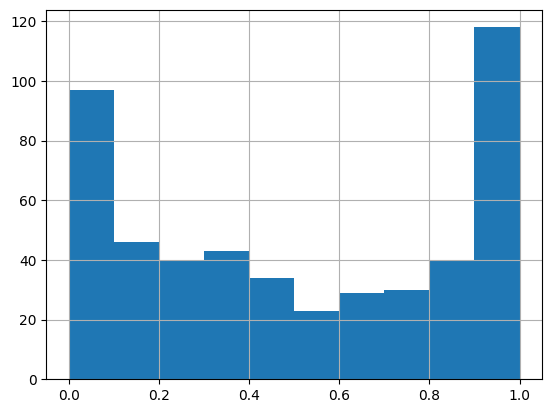

In [6]:
df_tr.propen.hist()

## IHDP

In [ ]:
# Experiment parameters
binary_intervention = True
num_iters = 400
p = 25
z_binary_dims = 19
path = '/Users/linyingyang/Documents/Project/frengression/frengression/data_causl'

# Initialize tracker for valid trials

valid_trials = 0
max_trials = 50  # We want results from 50 valid trials
trial = 0


tracker = {"fr": [], "dr": [], "causalegm":[], "tarnet":[], "cfrnet":[], "cevae":[], "dragonnet":[]}
best_hps = {model: None for model in ["tarnet","cfrnet","cevae","dragonnet"]}

while valid_trials < max_trials:
    print(f"Checking trial = {trial}")
    df_tr, df_te = process_data(path=path, trial=trial)

    # Skip this trial if any y_factual in df_tr exceeds 20
    if (df_tr['y_factual'] > 20).any():
        print(f"Skipping trial {trial} because y_factual > 20")
        trial += 1
        continue

    print(f"Running on valid trial = {trial}")
    
    # Prepare tensors for training
    z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_tr = torch.tensor(df_tr['treatment'].values, dtype=torch.float32).view(-1, 1)
    y_tr = torch.tensor(df_tr['y_factual'].values, dtype=torch.float32).view(-1, 1)
    ate_sample = torch.tensor(np.mean(df_tr['mu1'].values - df_tr['mu0'].values), dtype=torch.float32).view(-1, 1)
    
    # DR ATE estimation
    z_tr_np = df_tr[[f"X{i}" for i in range(1, p + 1)]].values
    x_tr_np = df_tr['treatment'].values
    y_tr_np = df_tr['y_factual'].values

    z_te_np = df_te[[f"X{i}" for i in range(1, p + 1)]].values
    z_te = torch.tensor(df_te[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_te_np = df_te['treatment'].values
    y_te_np = df_te['y_factual'].values
    hat_dr, _ = dr_ate(x_tr_np, y_tr_np, z_tr_np, x_te_np, y_te_np, z_te_np)

    # Initialize Frengression model
    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                        noise_dim=1, num_layer=3, hidden_dim=400, 
                        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
                        x_binary=binary_intervention, z_binary_dims=19)


    model.train_y(x_tr, z_tr, y_tr, num_iters=1000, lr=1e-3, print_every_iter=100,tol=0.01)


    # Sample model distributions
    P0 = model.predict_causal(torch.tensor([0], dtype=torch.int32), sample_size=1000).numpy()
    P1 = model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=1000).numpy().reshape(-1, 1)
    ate_fr = np.mean(P1) - np.mean(P0)
    # ate_fr = cross_fit_frengression(df_tr, binary_intervention, p, outcome_reg=False, k_folds=5, num_iters=1000, lr=1e-4, sample_size=1000)['ATE']


    # DR Estimation
    ate_dr, _ = dr_ate(x_tr_np, y_tr_np, z_tr_np ,x_te_np, y_te_np, z_te_np)

    for model in ["tarnet","cfrnet","cevae","dragonnet"]:
        if valid_trials == 0:
            ite, best_hps[model] = tune_and_eval(
                model,
                z_tr_np, x_tr_np, y_tr_np,
                z_tr_np, x_tr_np, y_tr_np,
                z_te_np, x_te_np,y_te_np,
                provided_params=None,
                n_trials=20
            )
        else:
            ite = tune_and_eval(
                model,
                z_tr_np, x_tr_np, y_tr_np,
                z_tr_np, x_tr_np, y_tr_np,
                z_te_np, x_te_np,y_te_np,
                provided_params=best_hps[model]
            )
        tracker[model].append(ite.mean())


    cegm_params = {'dataset': 'Semi_acic', 
                    'output_dir': '.', 
                    'v_dim': z_tr.shape[1], 
                    'z_dims': [1, 1, 1, 1], 
                    'lr': 0.0002, 
                    'alpha': 1, 
                    'beta': 1, 
                    'gamma': 10, 
                    'g_d_freq': 5, 
                    'g_units': [64, 64, 64, 64, 64], 
                    'e_units': [64, 64, 64, 64, 64], 
                    'f_units': [64, 32, 8], 
                    'h_units': [64, 32, 8], 
                    'dz_units': [64, 32, 8], 
                    'dv_units': [64, 32, 8], 'save_res': False, 'save_model': False, 'binary_treatment': True, 'use_z_rec': True, 'use_v_gan': True}
    egm_model = cegm.CausalEGM(params=cegm_params, random_seed=42)
    egm_model.train(data=[x_tr,y_tr,z_tr],n_iter=800, verbose=False)
    ate_causalegm=egm_model.getCATE(z_te).mean()
    tracker['causalegm'].append(ate_causalegm)
    tracker['fr'].append(ate_fr)
    tracker['dr'].append(ate_dr)

    # Increment valid trials counter and move to the next trial
    valid_trials += 1
    trial += 1



In [56]:
with open("result/binary/ihdp.json") as f:
    tracker = json.load(f)
tracker['fr']=[]

In [57]:
# Experiment parameters
binary_intervention = True
num_iters = 400
p = 25
z_binary_dims = 19
path = '/Users/linyingyang/Documents/Project/frengression/frengression/data_causl'

# Initialize tracker for valid trials

valid_trials = 0
max_trials = 50  # We want results from 50 valid trials
trial = 0


# tracker = {"fr": [], "dr": [], "causalegm":[], "tarnet":[], "cfrnet":[], "cevae":[], "dragonnet":[]}
# best_hps = {model: None for model in ["tarnet","cfrnet","cevae","dragonnet"]}

while valid_trials < max_trials:
    print(f"Checking trial = {trial}")
    df_tr, df_te = process_data(path=path, trial=trial)


    # Skip this trial if any y_factual in df_tr exceeds 20
    if (df_tr['y_factual'] > 20).any():
        print(f"Skipping trial {trial} because y_factual > 20")
        trial += 1
        continue
    print(f"Running on valid trial = {trial}")
    
    # Prepare tensors for training
    z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_tr = torch.tensor(df_tr['treatment'].values, dtype=torch.float32).view(-1, 1)
    y_tr = torch.tensor(df_tr['y_factual'].values, dtype=torch.float32).view(-1, 1)
    # ate_sample = torch.tensor(np.mean(df_tr['mu1'].values - df_tr['mu0'].values), dtype=torch.float32).view(-1, 1)
    # df_tr.rename(columns={
    #     'treatment': 'A',
    #     'y_factual': 'y'
    # }, inplace=True)

    # DR ATE estimation
    # z_tr_np = df_tr[[f"X{i}" for i in range(1, p + 1)]].values
    # x_tr_np = df_tr['treatment'].values
    # y_tr_np = df_tr['y_factual'].values

    # z_te_np = df_te[[f"X{i}" for i in range(1, p + 1)]].values
    # z_te = torch.tensor(df_te[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    # x_te_np = df_te['treatment'].values
    # y_te_np = df_te['y_factual'].values
    # hat_dr, _ = dr_ate(x_tr_np, y_tr_np, z_tr_np, x_te_np, y_te_np, z_te_np)

    # Initialize Frengression model
    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                         noise_dim=1, num_layer=3, hidden_dim=400, 
                         device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
                         x_binary=binary_intervention, z_binary_dims=0)
    

    model.train_y(x_tr, z_tr, y_tr, num_iters=1000, lr=1e-4, print_every_iter=100, tol = 0.01)


    # # Sample model distributions
    P0 = model.predict_causal(torch.tensor([0], dtype=torch.int32), sample_size=1000).numpy()
    P1 = model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=1000).numpy().reshape(-1, 1)
    ate_fr = np.mean(P1) - np.mean(P0)
    # ate_fr = cross_fit_frengression(df_tr, binary_intervention, p, outcome_reg=False, k_folds=5, num_iters=1000, lr=1e-4, sample_size=1000)['ATE_marginal']

    tracker['fr'].append(ate_fr)

    # Increment valid trials counter and move to the next trial
    valid_trials += 1
    trial += 1



Checking trial = 0
Running on valid trial = 0
Epoch 1: loss 3.9249,	loss_y 3.1621, 3.1709, 0.0175,	loss_eta 0.7627, 0.7887, 0.0520
Epoch 100: loss 1.3581,	loss_y 0.7625, 1.2839, 1.0428,	loss_eta 0.5956, 1.1865, 1.1818
Stopping at iter 122: |Δy|=-1.3529e-03, |Δη|=-1.1240e-03
Checking trial = 1
Running on valid trial = 1
Epoch 1: loss 5.8511,	loss_y 5.0356, 5.0645, 0.0579,	loss_eta 0.8156, 0.8401, 0.0491
Epoch 100: loss 1.4768,	loss_y 0.8914, 1.6787, 1.5745,	loss_eta 0.5854, 1.1968, 1.2229
Stopping at iter 123: |Δy|=-7.1410e-03, |Δη|=-1.1587e-03
Checking trial = 2
Running on valid trial = 2
Epoch 1: loss 4.6464,	loss_y 3.8676, 3.8882, 0.0412,	loss_eta 0.7788, 0.7980, 0.0384
Epoch 100: loss 1.3273,	loss_y 0.7571, 1.4813, 1.4484,	loss_eta 0.5702, 1.1265, 1.1124
Epoch 200: loss 1.2024,	loss_y 0.6008, 1.2296, 1.2577,	loss_eta 0.6016, 1.0733, 0.9433
Epoch 300: loss 1.0657,	loss_y 0.5341, 1.0886, 1.1089,	loss_eta 0.5316, 1.0053, 0.9474
Epoch 400: loss 1.0177,	loss_y 0.4393, 0.9818, 1.0850,	los

In [ ]:
model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                         noise_dim=1, num_layer=3, hidden_dim=100, 
                         device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
                         x_binary=binary_intervention, z_binary_dims=0)
    

model.train_y(x_tr, z_tr, y_tr, num_iters=1000, lr=1e-4, print_every_iter=100, tol = 0.01)
P0 = model.predict_causal(torch.tensor([0], dtype=torch.int32), sample_size=1000).numpy()
P1 = model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=1000).numpy().reshape(-1, 1)
ate_fr = np.mean(P1) - np.mean(P0)
ate_fr

Epoch 1: loss 6.1241,	loss_y 5.3326, 5.3439, 0.0226,	loss_eta 0.7914, 0.8086, 0.0343
Epoch 100: loss 5.2878,	loss_y 4.6137, 4.7170, 0.2066,	loss_eta 0.6741, 0.8421, 0.3361
Epoch 200: loss 3.3193,	loss_y 2.6796, 3.1593, 0.9594,	loss_eta 0.6397, 1.2997, 1.3199
Epoch 300: loss 1.9385,	loss_y 1.3039, 2.4591, 2.3105,	loss_eta 0.6346, 1.6418, 2.0144
Epoch 400: loss 1.7411,	loss_y 1.1150, 2.2208, 2.2116,	loss_eta 0.6261, 1.4710, 1.6898
Epoch 500: loss 1.6070,	loss_y 0.9744, 2.0403, 2.1318,	loss_eta 0.6326, 1.3701, 1.4751
Epoch 600: loss 1.4740,	loss_y 0.9068, 1.9300, 2.0462,	loss_eta 0.5672, 1.2487, 1.3630
Epoch 700: loss 1.3458,	loss_y 0.7984, 1.8274, 2.0580,	loss_eta 0.5475, 1.2038, 1.3126


In [58]:
import json, os

output_dir = "result/binary"
os.makedirs(output_dir, exist_ok=True)

# Convert each list of (possibly numpy) numbers into plain Python floats
tracker_serializable = {
    model: [float(x) for x in lst]
    for model, lst in tracker.items()
}

with open(os.path.join(output_dir, "ihdp.json"), "w") as f:
    json.dump(tracker_serializable, f, indent=4)

In [255]:
import json
import numpy as np
import pandas as pd

# 1) Load your tracker
with open("result/binary/synthetic_1k.json") as f:
    tracker = json.load(f)

# 2) Define strengths and methods in the order you want
strengths = sorted(tracker.keys(), key=lambda x: float(x))
methods   = ["fr","dr","causalegm","tarnet","cfrnet","cevae","dragonnet"]

# 3) Build a MultiIndex DataFrame
rows = []
index = []
for s in strengths:
    ests = tracker[s]
    # precompute each method’s metrics
    stats = {}
    for m in methods:
        arr = np.array(ests[m])
        stats[m] = {
            "rmse": np.sqrt(((arr - 2.0)**2).mean()),
            "bias": arr.mean() - 2.0,
            "mae":  np.abs(arr - 2.0).mean()
        }
    # for each metric, make one row
    for metric in ["rmse","bias","mae"]:
        index.append((s, metric))
        rows.append([stats[m][metric] for m in methods])

df = pd.DataFrame(rows,
                  index=pd.MultiIndex.from_tuples(index,
                                                  names=["strength","metric"]),
                  columns=methods)

# 4) Formatting function
def fmt(x):
    if 1e-2 <= abs(x) < 1e0:
        return f"{x:.2f}"
    else:
        return f"{x:.3e}"

df_fmt = df.applymap(fmt)

# 5) Print LaTeX
print(df_fmt.to_latex(multicolumn=True, multirow=True, escape=False))


\begin{tabular}{lllllllll}
\toprule
 &  & fr & dr & causalegm & tarnet & cfrnet & cevae & dragonnet \\
strength & metric &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{1.0} & rmse & 0.29 & 0.78 & 0.15 & 1.994e+00 & 1.992e+00 & 2.003e+00 & 0.09 \\
 & bias & -0.19 & 0.52 & -0.14 & -1.994e+00 & -1.992e+00 & -2.002e+00 & 0.07 \\
 & mae & 0.24 & 0.63 & 0.14 & 1.994e+00 & 1.992e+00 & 2.002e+00 & 0.07 \\
\cline{1-9}
\multirow[t]{3}{*}{2.0} & rmse & 0.27 & 1.486e+00 & 0.24 & 1.998e+00 & 1.981e+00 & 2.001e+00 & 0.15 \\
 & bias & -0.12 & 0.96 & -0.22 & -1.998e+00 & -1.981e+00 & -2.000e+00 & 0.12 \\
 & mae & 0.23 & 0.96 & 0.22 & 1.998e+00 & 1.981e+00 & 2.000e+00 & 0.13 \\
\cline{1-9}
\multirow[t]{3}{*}{3.0} & rmse & 0.37 & 0.81 & 0.31 & 1.996e+00 & 2.002e+00 & 1.994e+00 & 0.17 \\
 & bias & -0.30 & 0.75 & -0.29 & -1.996e+00 & -2.002e+00 & -1.994e+00 & 0.15 \\
 & mae & 0.33 & 0.77 & 0.29 & 1.996e+00 & 2.002e+00 & 1.994e+00 & 0.15 \\
\cline{1-9}
\multirow[t]{3}{*}{4.0} & rmse & 0.34 & 0.85 & 0.

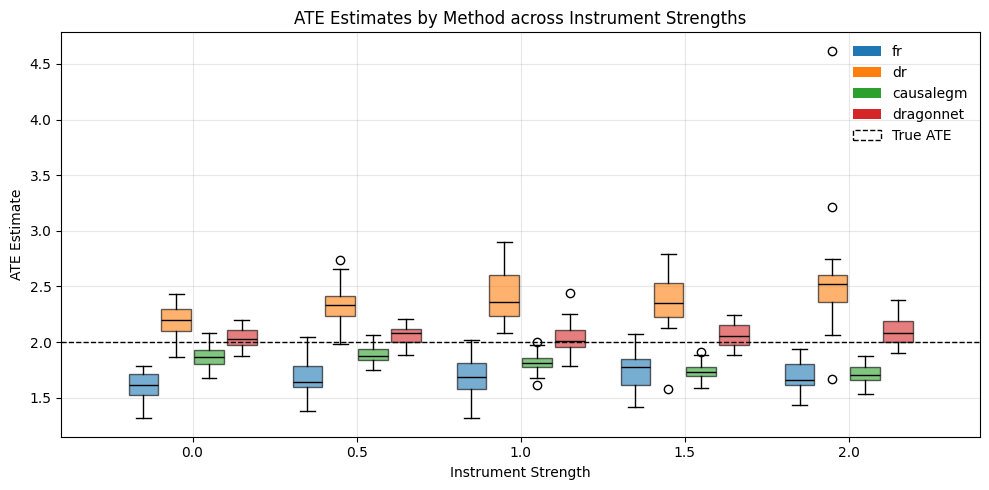

In [24]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load
with open("result/binary/synthetic_1k_v3.json") as f:
    tracker = json.load(f)

strengths = sorted(tracker.keys(), key=lambda x: float(x))
methods   = ["fr","dr","causalegm","dragonnet"]
colors    = {
    "fr":        "#1f77b4",  # blue
    "dr":        "#ff7f0e",  # orange
    "causalegm": "#2ca02c",  # green
    "dragonnet": "#d62728",  # red
}

plt.figure(figsize=(10, 5))
n = len(strengths)
m = len(methods)
width = 0.8 / m

for i, s in enumerate(strengths):
    if i == 1:
        pass 
    for j, meth in enumerate(methods):
        pos = i - 0.4 + j*width + width/2
        data = tracker[s][meth]
        plt.boxplot(data,
                    positions=[pos],
                    widths=width*0.9,
                    patch_artist=True,
                    boxprops=dict(facecolor=colors[meth], alpha=0.6),
                    medianprops=dict(color="black"))

# True ATE line
plt.axhline(2.0, color='black', linestyle='--', linewidth=1)

# Ticks & labels
plt.xticks(ticks=list(range(n)), labels=strengths)
plt.xlabel("Instrument Strength")
plt.ylabel("ATE Estimate")

# Single legend
handles = [Patch(facecolor=colors[m], label=m) for m in methods]
handles.append(Patch(facecolor='none', edgecolor='black', linestyle='--', label='True ATE'))
plt.legend(handles=handles, loc="upper right", frameon=False, ncol=1)

plt.title("ATE Estimates by Method across Instrument Strengths")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


            RMSE   Bias    MAE
method                        
fr         1.648 -0.962  1.361
dr         0.545 -0.002  0.426
causalegm  1.807 -1.671  1.671
tarnet     4.000 -4.000  4.000
cfrnet     4.005 -4.005  4.005
cevae      3.997 -3.997  3.997
dragonnet  0.429  0.095  0.228

LaTeX:
\begin{tabular}{lrrr}
 & RMSE & Bias & MAE \\
method &  &  &  \\
fr & 1.648 & -0.962 & 1.361 \\
dr & 0.545 & -0.002 & 0.426 \\
causalegm & 1.807 & -1.671 & 1.671 \\
tarnet & 4.000 & -4.000 & 4.000 \\
cfrnet & 4.005 & -4.005 & 4.005 \\
cevae & 3.997 & -3.997 & 3.997 \\
dragonnet & 0.429 & 0.095 & 0.228 \\
\end{tabular}



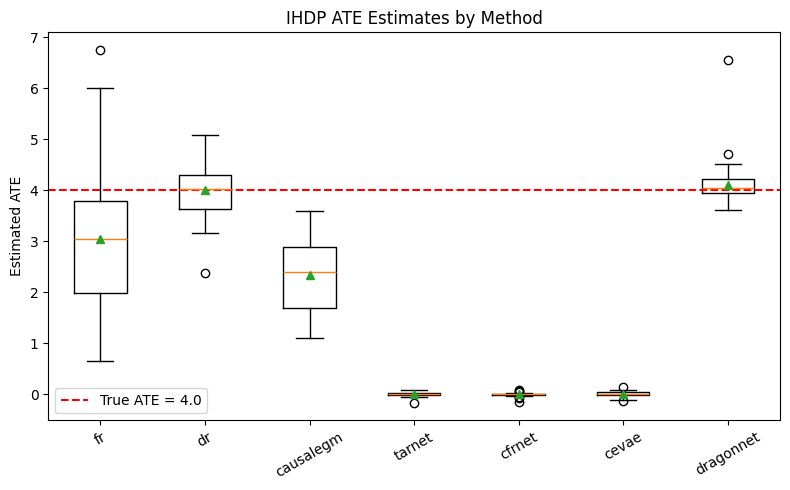

In [59]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1) load your tracker
with open("result/binary/ihdp.json") as f:
    tracker = json.load(f)

true_ate = 4.0
methods = list(tracker.keys())

# 2) compute metrics
rows = []
for m in methods:
    est = np.array(tracker[m])
    rmse = np.sqrt(mean_squared_error(np.full_like(est, true_ate), est))
    bias = est.mean() - true_ate
    mae  = mean_absolute_error(np.full_like(est, true_ate), est)
    rows.append((m, rmse, bias, mae))

df = pd.DataFrame(rows, columns=["method","RMSE","Bias","MAE"]).set_index("method")

# 3) print and latex
print(df.round(3))
print("\nLaTeX:")
print(df.style.format("{:.3f}").to_latex())

# 4) boxplot
plt.figure(figsize=(8,5))
plt.boxplot([tracker[m] for m in methods], labels=methods, showmeans=True)
plt.axhline(true_ate, color="red", linestyle="--", label=f"True ATE = {true_ate}")
plt.ylabel("Estimated ATE")
plt.xticks(rotation=30)
plt.title("IHDP ATE Estimates by Method")
plt.legend()
plt.tight_layout()
plt.show()


In [60]:
tracker

{'fr': [1.8805840015411377,
  1.2293577194213867,
  0.6568965911865234,
  2.7308053970336914,
  6.7533650398254395,
  2.585493803024292,
  3.0861685276031494,
  5.560434818267822,
  3.4496939182281494,
  1.6817498207092285,
  1.768491506576538,
  2.357041358947754,
  3.2762045860290527,
  3.6121296882629395,
  1.6551244258880615,
  2.425121545791626,
  1.7421836853027344,
  4.663026809692383,
  1.9706707000732422,
  3.5590524673461914,
  3.593852996826172,
  0.70867919921875,
  1.2971398830413818,
  3.0945327281951904,
  3.8475189208984375,
  2.3555026054382324,
  2.7034294605255127,
  3.650202512741089,
  3.011929512023926,
  3.8352622985839844,
  2.0407004356384277,
  3.8579959869384766,
  2.9149911403656006,
  3.6666154861450195,
  2.5288898944854736,
  4.005790710449219,
  3.3521881103515625,
  3.1037986278533936,
  4.976897239685059,
  3.2838261127471924,
  2.3750123977661133,
  0.9823637008666992,
  1.7729506492614746,
  4.098163604736328,
  5.935720443725586,
  5.997453689575195